In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.special import i0
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.signal import correlate

In [2]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point, stopping_period_signal_decay,find_qualified_stopping_period, PVA_strength_during_stopPeriod
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import calculate_angle_difference_between_two_time_point,run_ANOVA_for_comparing_across_genotypes,plot_stopping_period_signal,calculate_stop_signal_in_separate_fly,run_fixed_heading_period_analysis_across_trial
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding,moving_wrapped_plot_by_offset
from fly2p_function_TQ.imaging_2p_preprocessing import low_pass_filter_TQ
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude ,calcualteBumpAmplitude_V2_green, calcualteBumpAmplitude_V3, calculateBumpWidth_v1,von_Mises_fitting_dff_TQ, PVA_radian_to_angle,calcualteBumpAmplitude_V4,PVAangleToRoi,strong_PVA_duration

In [3]:
run_vonMises_fitting = 0
stable_PVA_threshold = 67.5
genotype = 'R55G08>iGlu'
celltype = 'delta7-syt7f'
trial_condition = 'dark'
dual_imaging = 0
bump_amplitude_stopping_duration = 20
#200ms bin size
bump_amplitude_stopping_bin_size = 0.2
active_period_before_len =1

In [22]:
data_all = run_fixed_heading_period_analysis_across_trial('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/dark_cl_Ca_imaging/PENb/PENb_EB(syt)_(16_ROI_F)/dark',0,genotype,trial_condition,bump_amplitude_stopping_duration)

In [23]:
data_all.keys()

dict_keys(['output_df_pooled', 'output_bump_amplitude_V3_pooled', 'output_bump_amplitude_V4_pooled', 'output_bump_width_pooled', 'output_PVA_strength_pooled', 'output_Angular_Speed_pooled', 'strong_PVA_chunk_pooled', 'mean_PVA_strength_per_trial_pooled', 'output_stable_PVA_index_pooled', 'circular_variance', 'Average_bump_shape', 'output_flytrial', 'output_flytrial_for_qualified_stop', 'output_second_wise_bump_drift', 'output_second_wise_bump_dwell_difference'])

In [24]:
np.mean(data_all['mean_PVA_strength_per_trial_pooled'])

0.704919912713648

In [25]:
np.mean(data_all['output_bump_width_pooled'])

153.26785714285714

In [26]:
#df =data_all['Average_bump_shape']
#df.to_csv('/home/tianhaoqiu/Pictures/Screenshots/Average-bumpshape-d7-6f-shi-dark-31',encoding = 'utf-8', index=False) 

In [27]:
#df = pd.DataFrame(b, columns=['Column_Name'])
#df.to_csv('/home/tianhaoqiu/a.csv',encoding = 'utf-8', index=False) 

In [28]:
#output_bump_amplitude_V4_pooled.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/output_bump_amplitude_V4_pooled_delta7_iGlu_dark.csv',encoding = 'utf-8', index=False)
#output_bump_amplitude_V3_pooled.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/output_bump_amplitude_V3_pooled_delta7_iGlu_dark.csv',encoding = 'utf-8', index=False)

In [29]:
data_all['output_second_wise_bump_drift']

{'TQfly092': [[array([  56.87434697,  -27.79304285, -307.16700005, -408.58391352,
           -16.38431732,  155.22825407,  -55.31470513,   13.73122866]),
   array([-25.08796771,  27.35840633, -26.70515856,  -4.38304151,
           -4.8562333 ]),
   array([ 92.91533261,  -7.3480001 ,  -7.54845369,  48.4484233 ,
          -71.17294863]),
   array([ 35.03892926,  19.63946872, -20.92963636,   4.09229044,
          -13.89469081,  16.28605897]),
   array([  -8.17376842,   37.3792747 , -153.37511244]),
   array([  5.92496965, -84.07651844, 135.25213311]),
   array([ 43.46787514, -26.55406403,  13.1252832 , -39.83338682,
          -18.63727576, -12.72442279,   5.24283719, -17.94874524,
            2.83702129, -33.96055336,  24.19350271,   3.68066772,
          -12.31481486,  15.2760981 ]),
   array([-38.62819515, -21.89868295,   0.97026267,  -4.52781919,
          -13.49795588,   0.84459147,  20.98365135,  -3.62112523,
            4.62246934, -20.54131903]),
   array([ 26.19100887,  -3.3578917

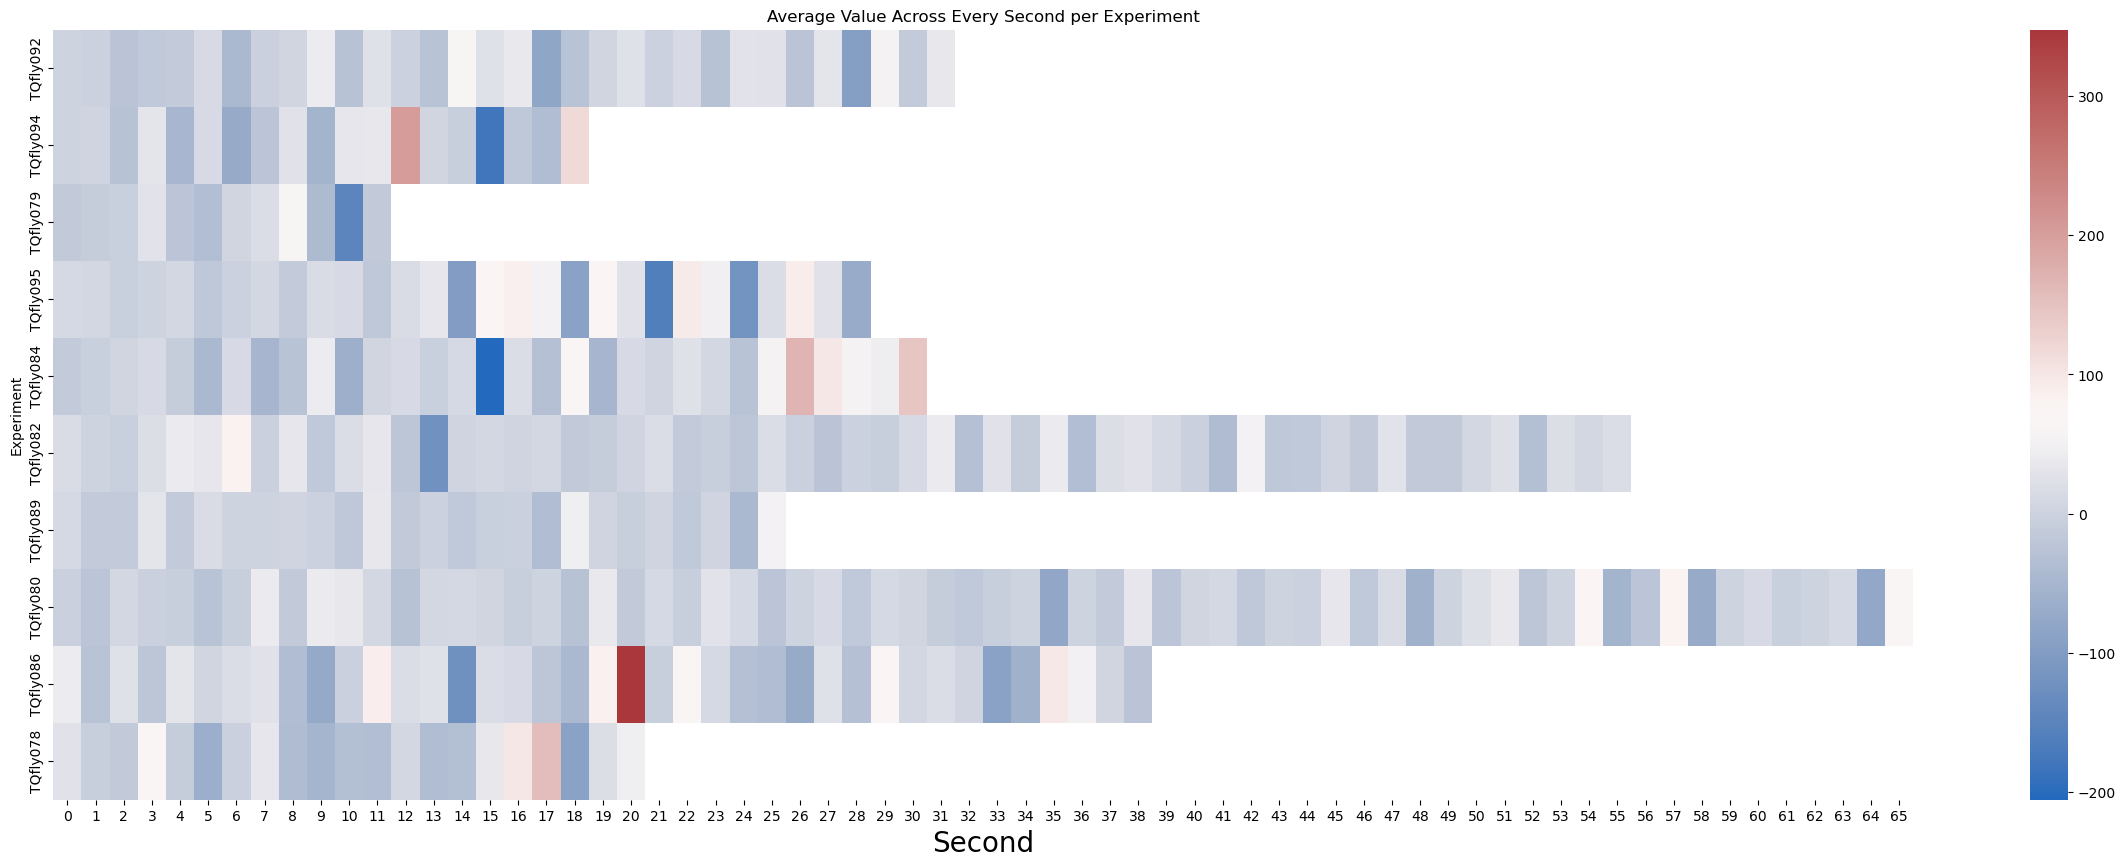

In [30]:

# Initialize a dictionary to store the averaged data for each experiment
experiment_averages = {}

for key, trials in data_all['output_second_wise_bump_drift'].items():
    # Flatten the nested lists for each experiment
    combined_data = []
    for trial in trials:
        for array in trial:
            combined_data.append(array)

    # Find the maximum length of the arrays for padding
    max_length = max(len(arr) for arr in combined_data)

    # Pad arrays to have the same length with NaN
    padded_data = np.array([np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=np.nan) for arr in combined_data])

    # Calculate the average value for each experiment across all trials (ignoring NaNs)
    averaged_data = np.nanmean(padded_data, axis=0)
    
    # Store the averaged data in the dictionary
    experiment_averages[key] = averaged_data

# Find the maximum length of all averaged arrays
max_length_all = max(len(arr) for arr in experiment_averages.values())

# Pad each array in experiment_averages to the maximum length
for key in experiment_averages:
    experiment_averages[key] = np.pad(experiment_averages[key], (0, max_length_all - len(experiment_averages[key])), 'constant', constant_values=np.nan)

# Convert the dictionary to a DataFrame for heatmap
df = pd.DataFrame(experiment_averages).T  # Transpose to get experiments as rows

# Plot heatmap
plt.figure(figsize=(30, 10))
#cmap = sns.cubehelix_palette(rot = .2, as_cmap = True)
sns.heatmap(df, cmap= "vlag", annot=False)
plt.title('Average Value Across Every Second per Experiment')
plt.xlabel('Second',fontsize =20)
plt.ylabel('Experiment')
plt.show()


Plotting combined heatmap for experiment: TQfly092


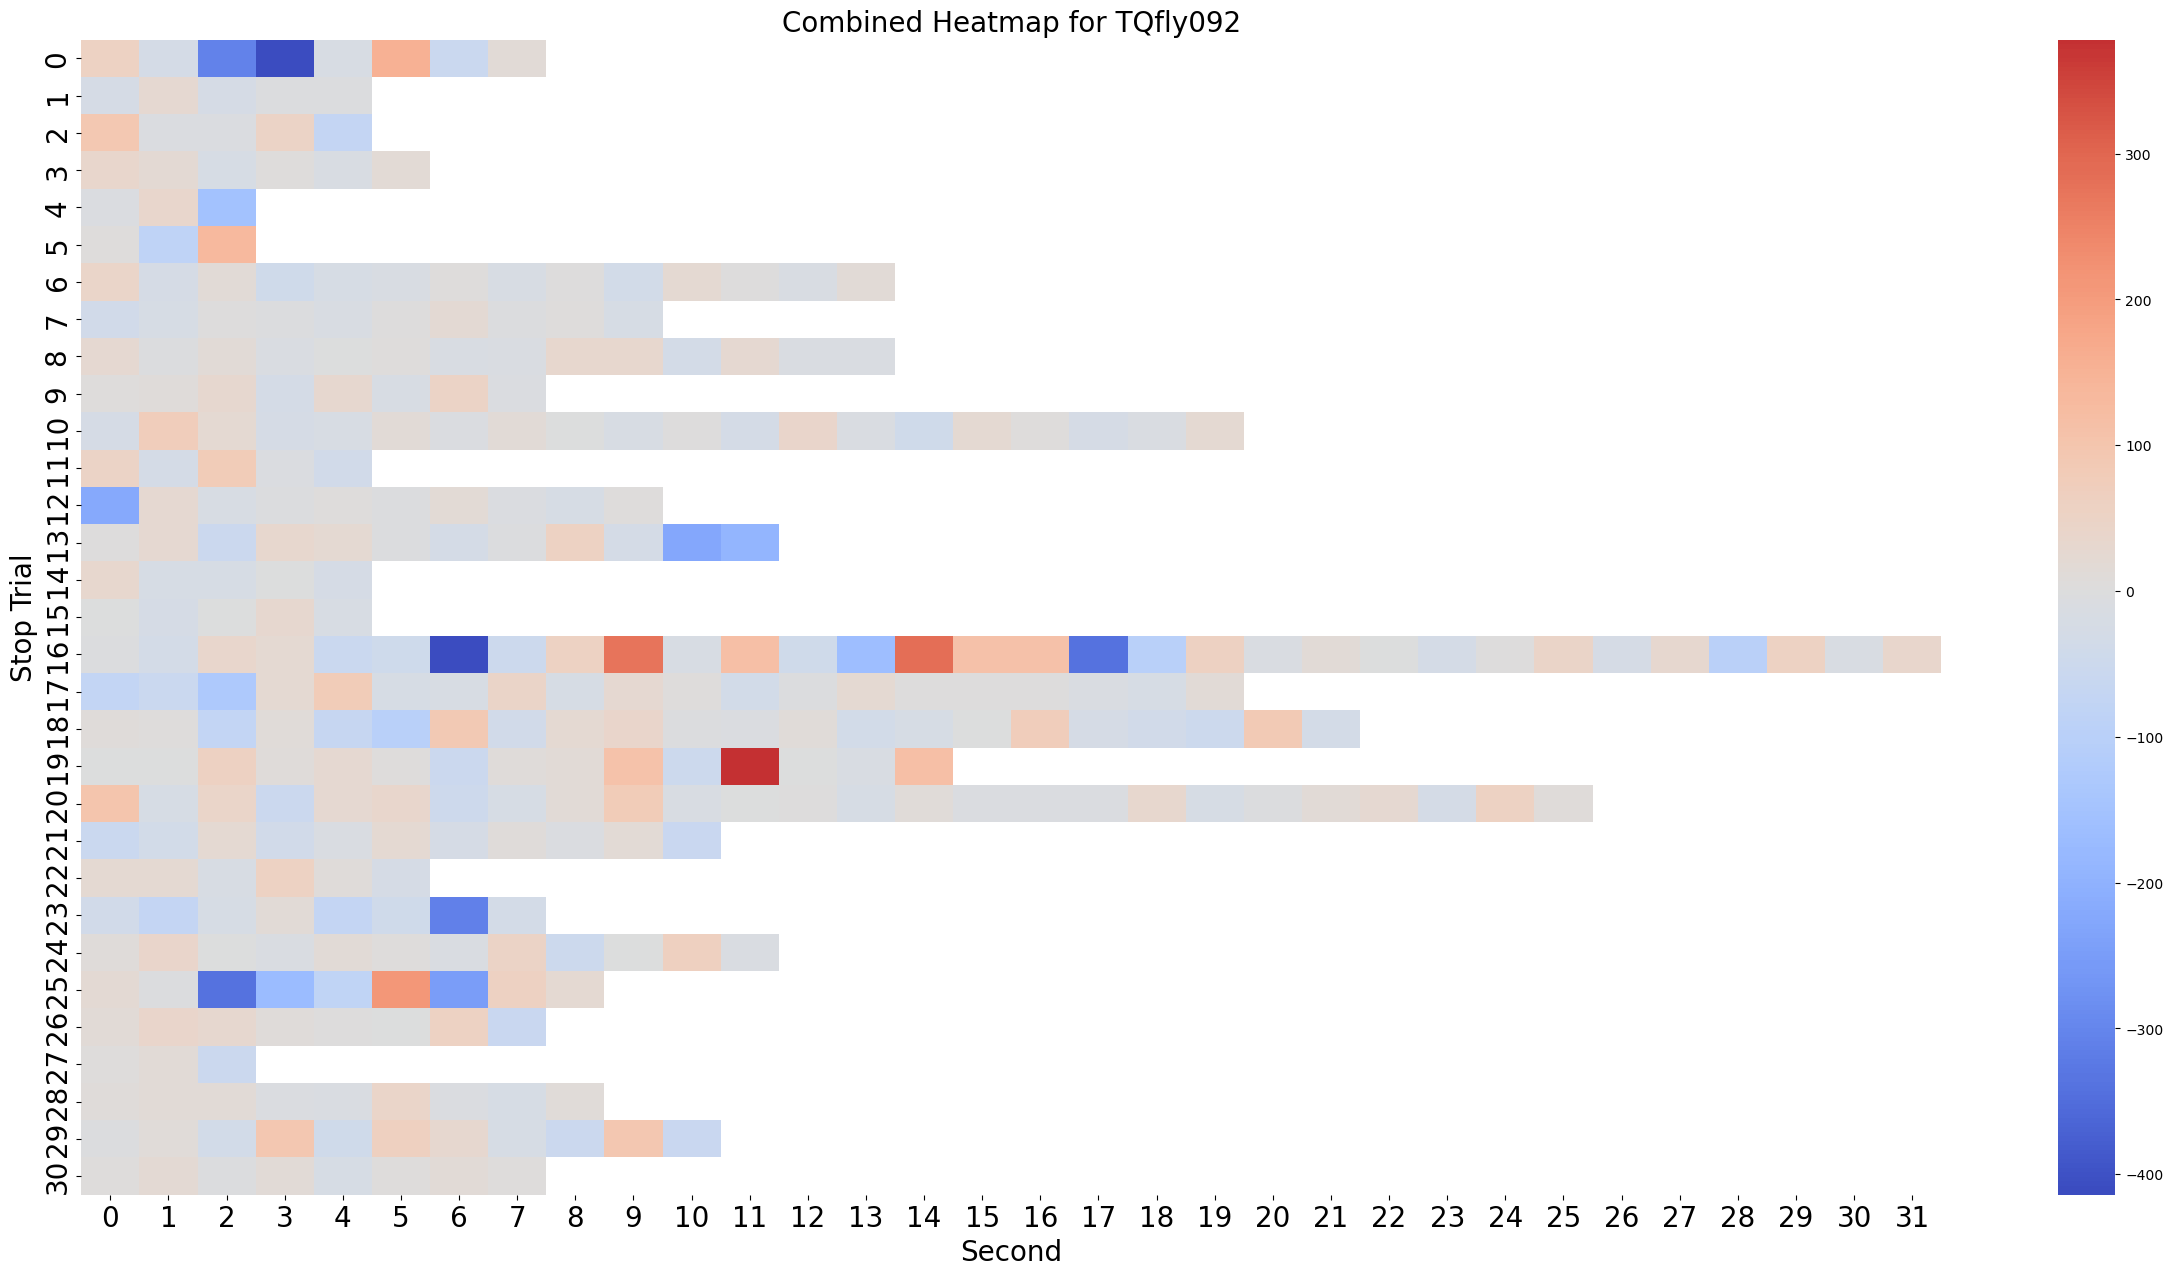

Plotting combined heatmap for experiment: TQfly094


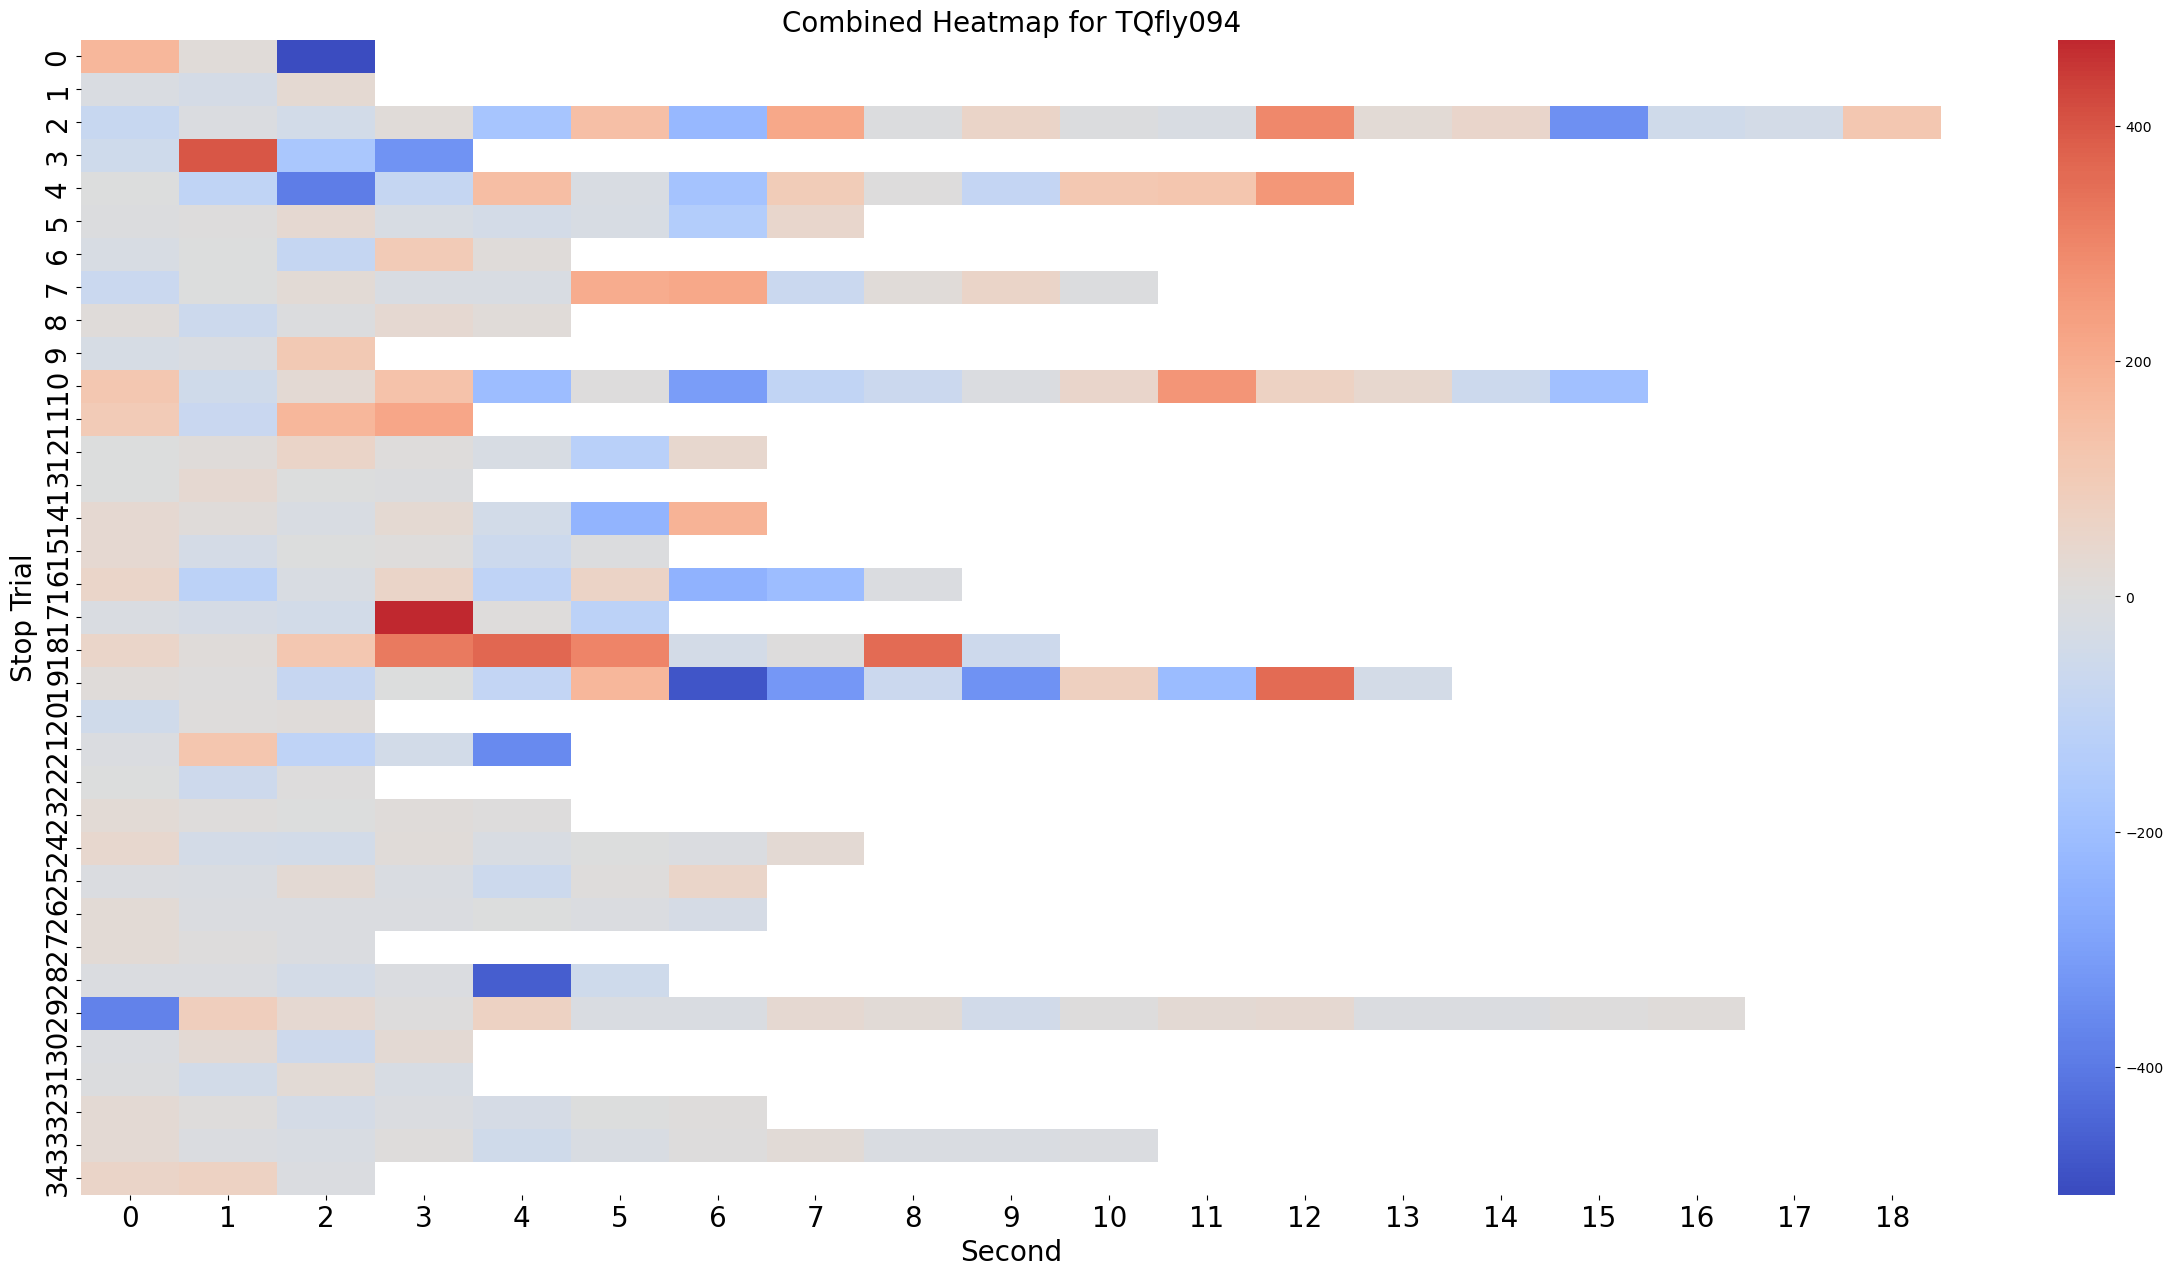

Plotting combined heatmap for experiment: TQfly079


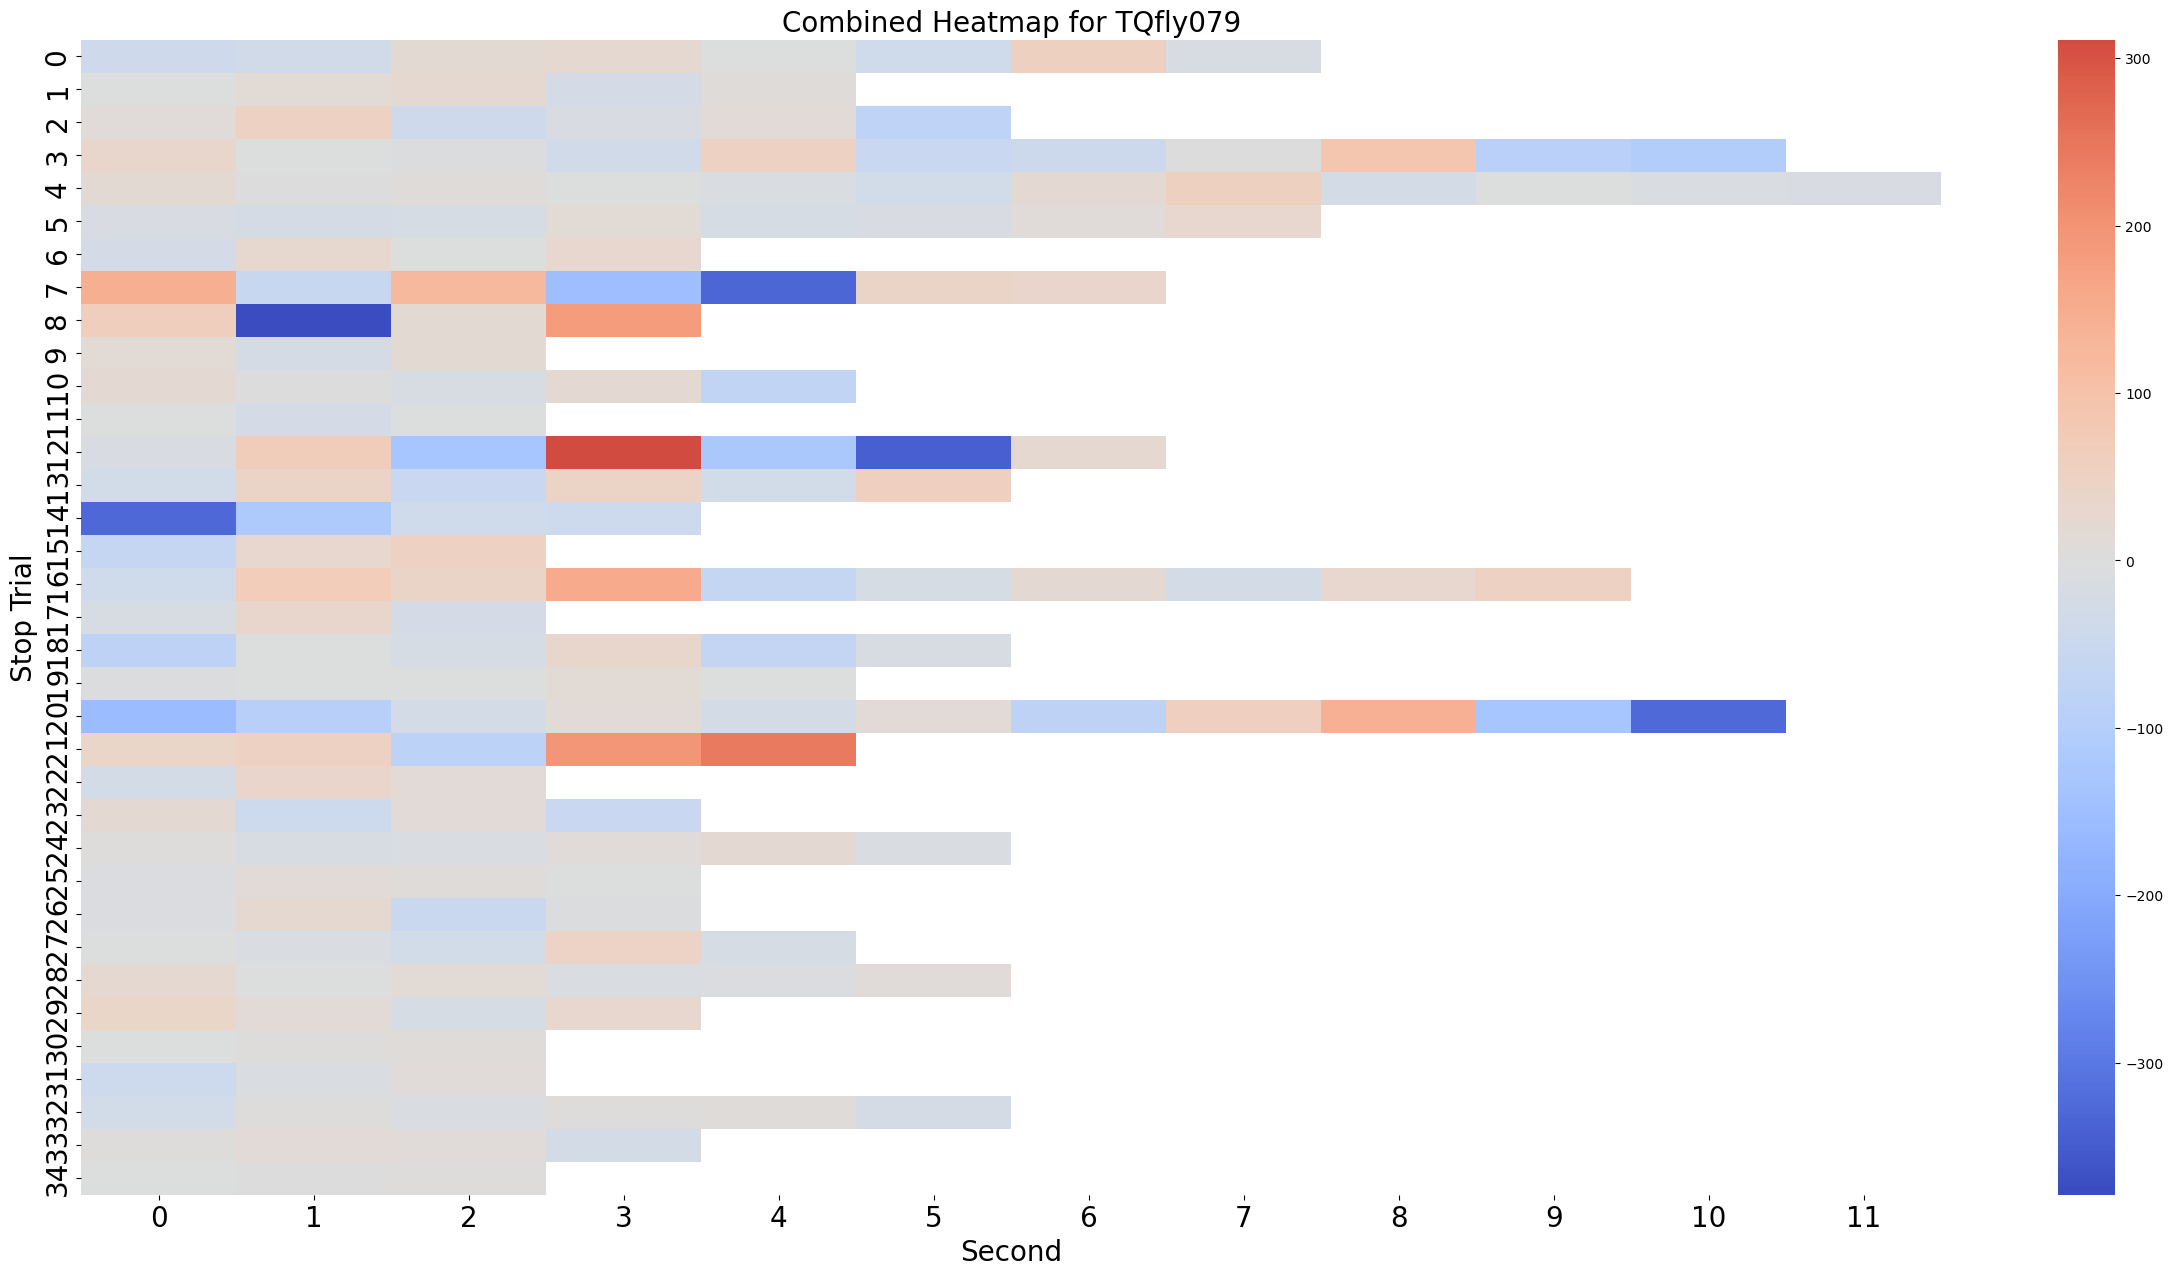

Plotting combined heatmap for experiment: TQfly095


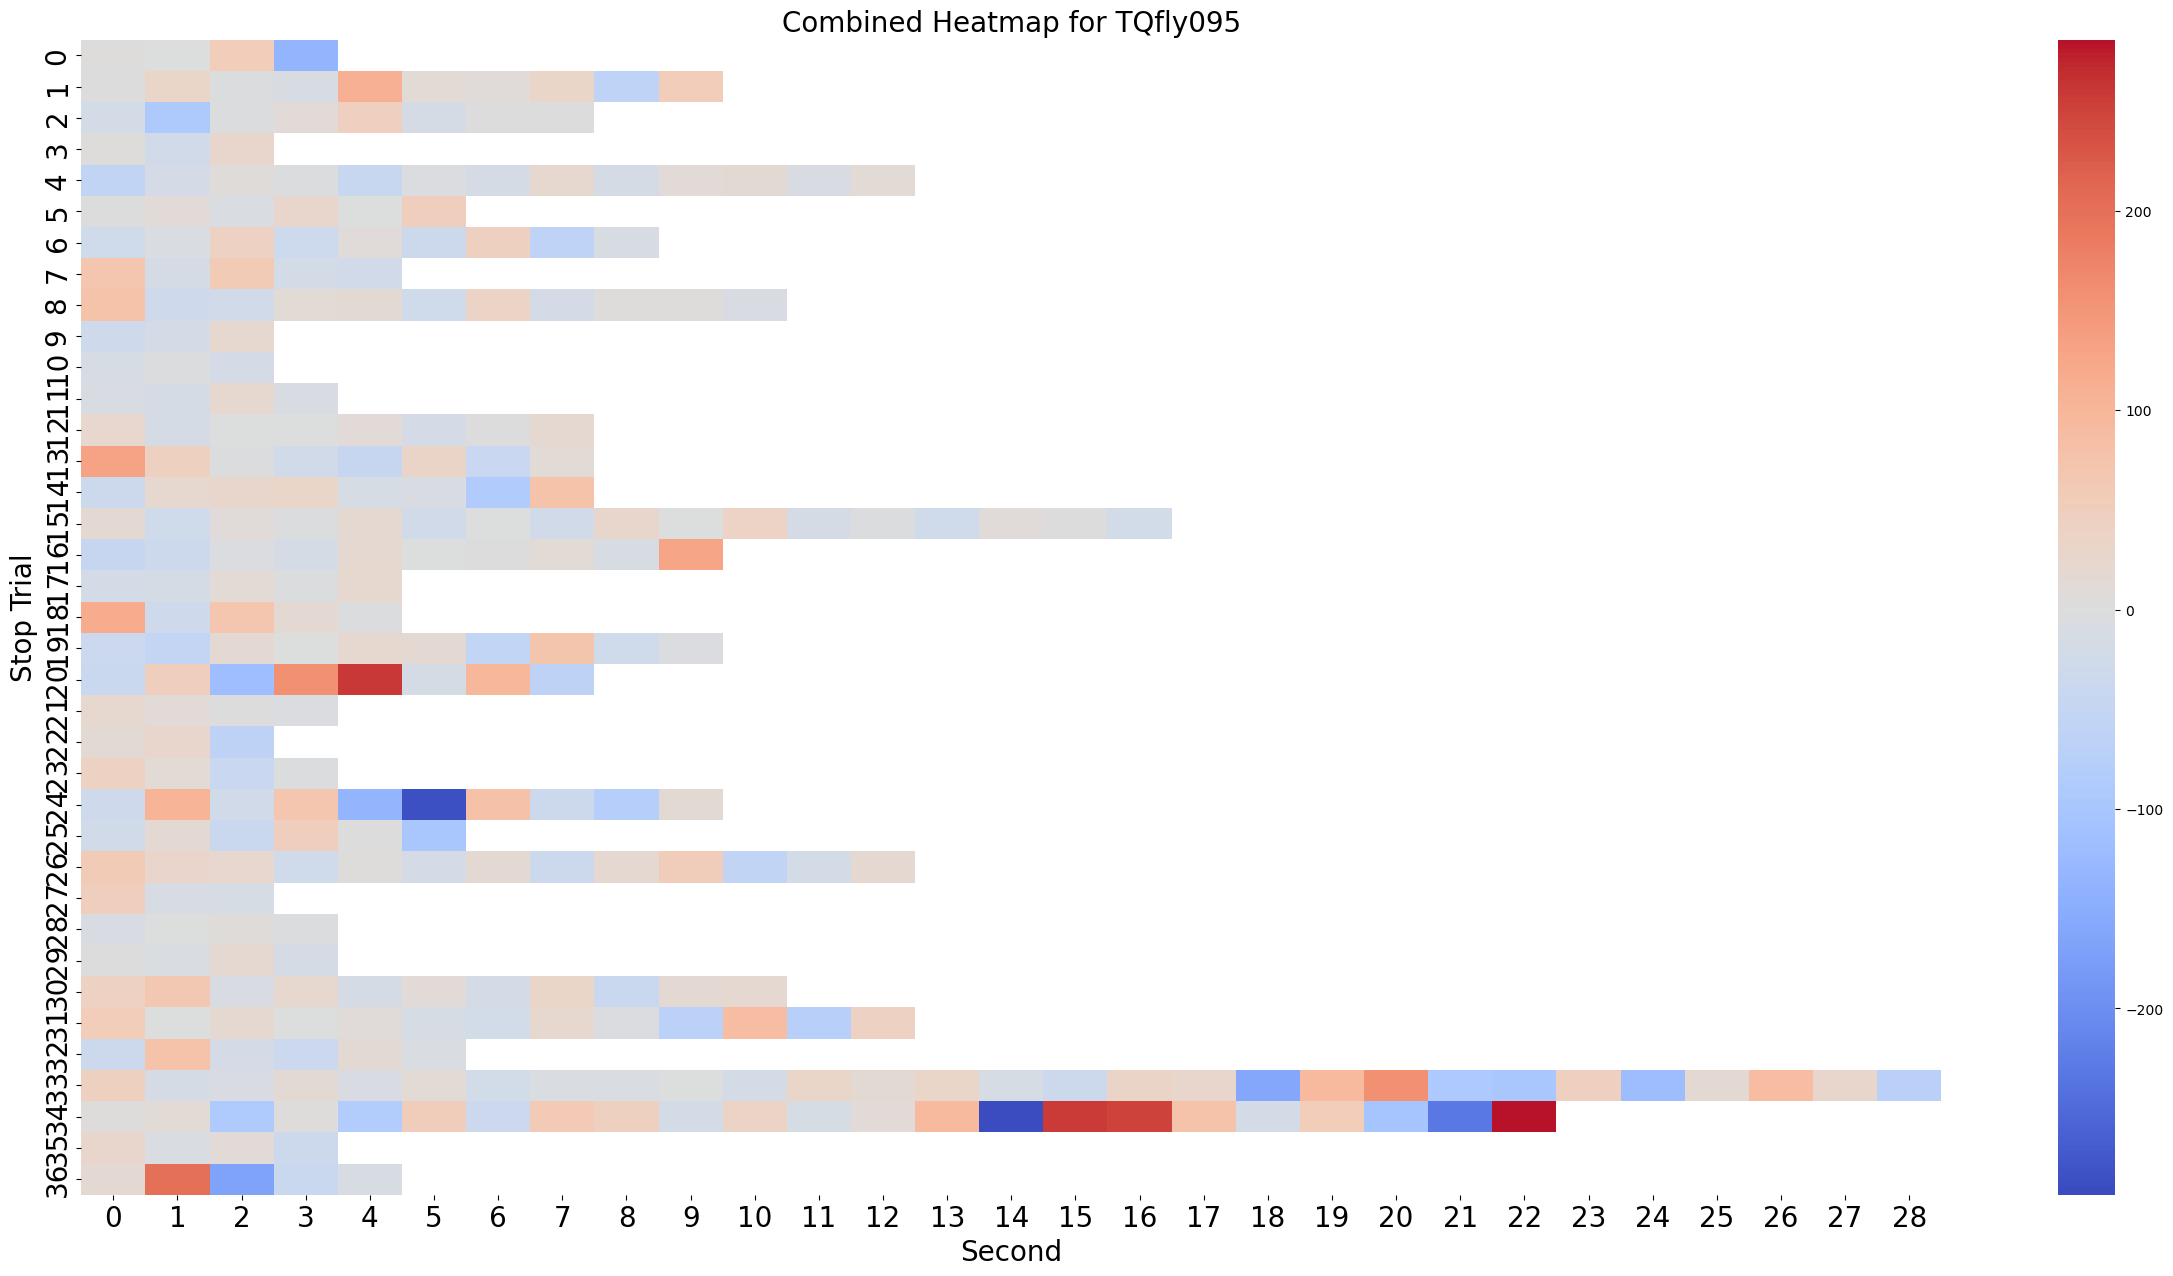

Plotting combined heatmap for experiment: TQfly084


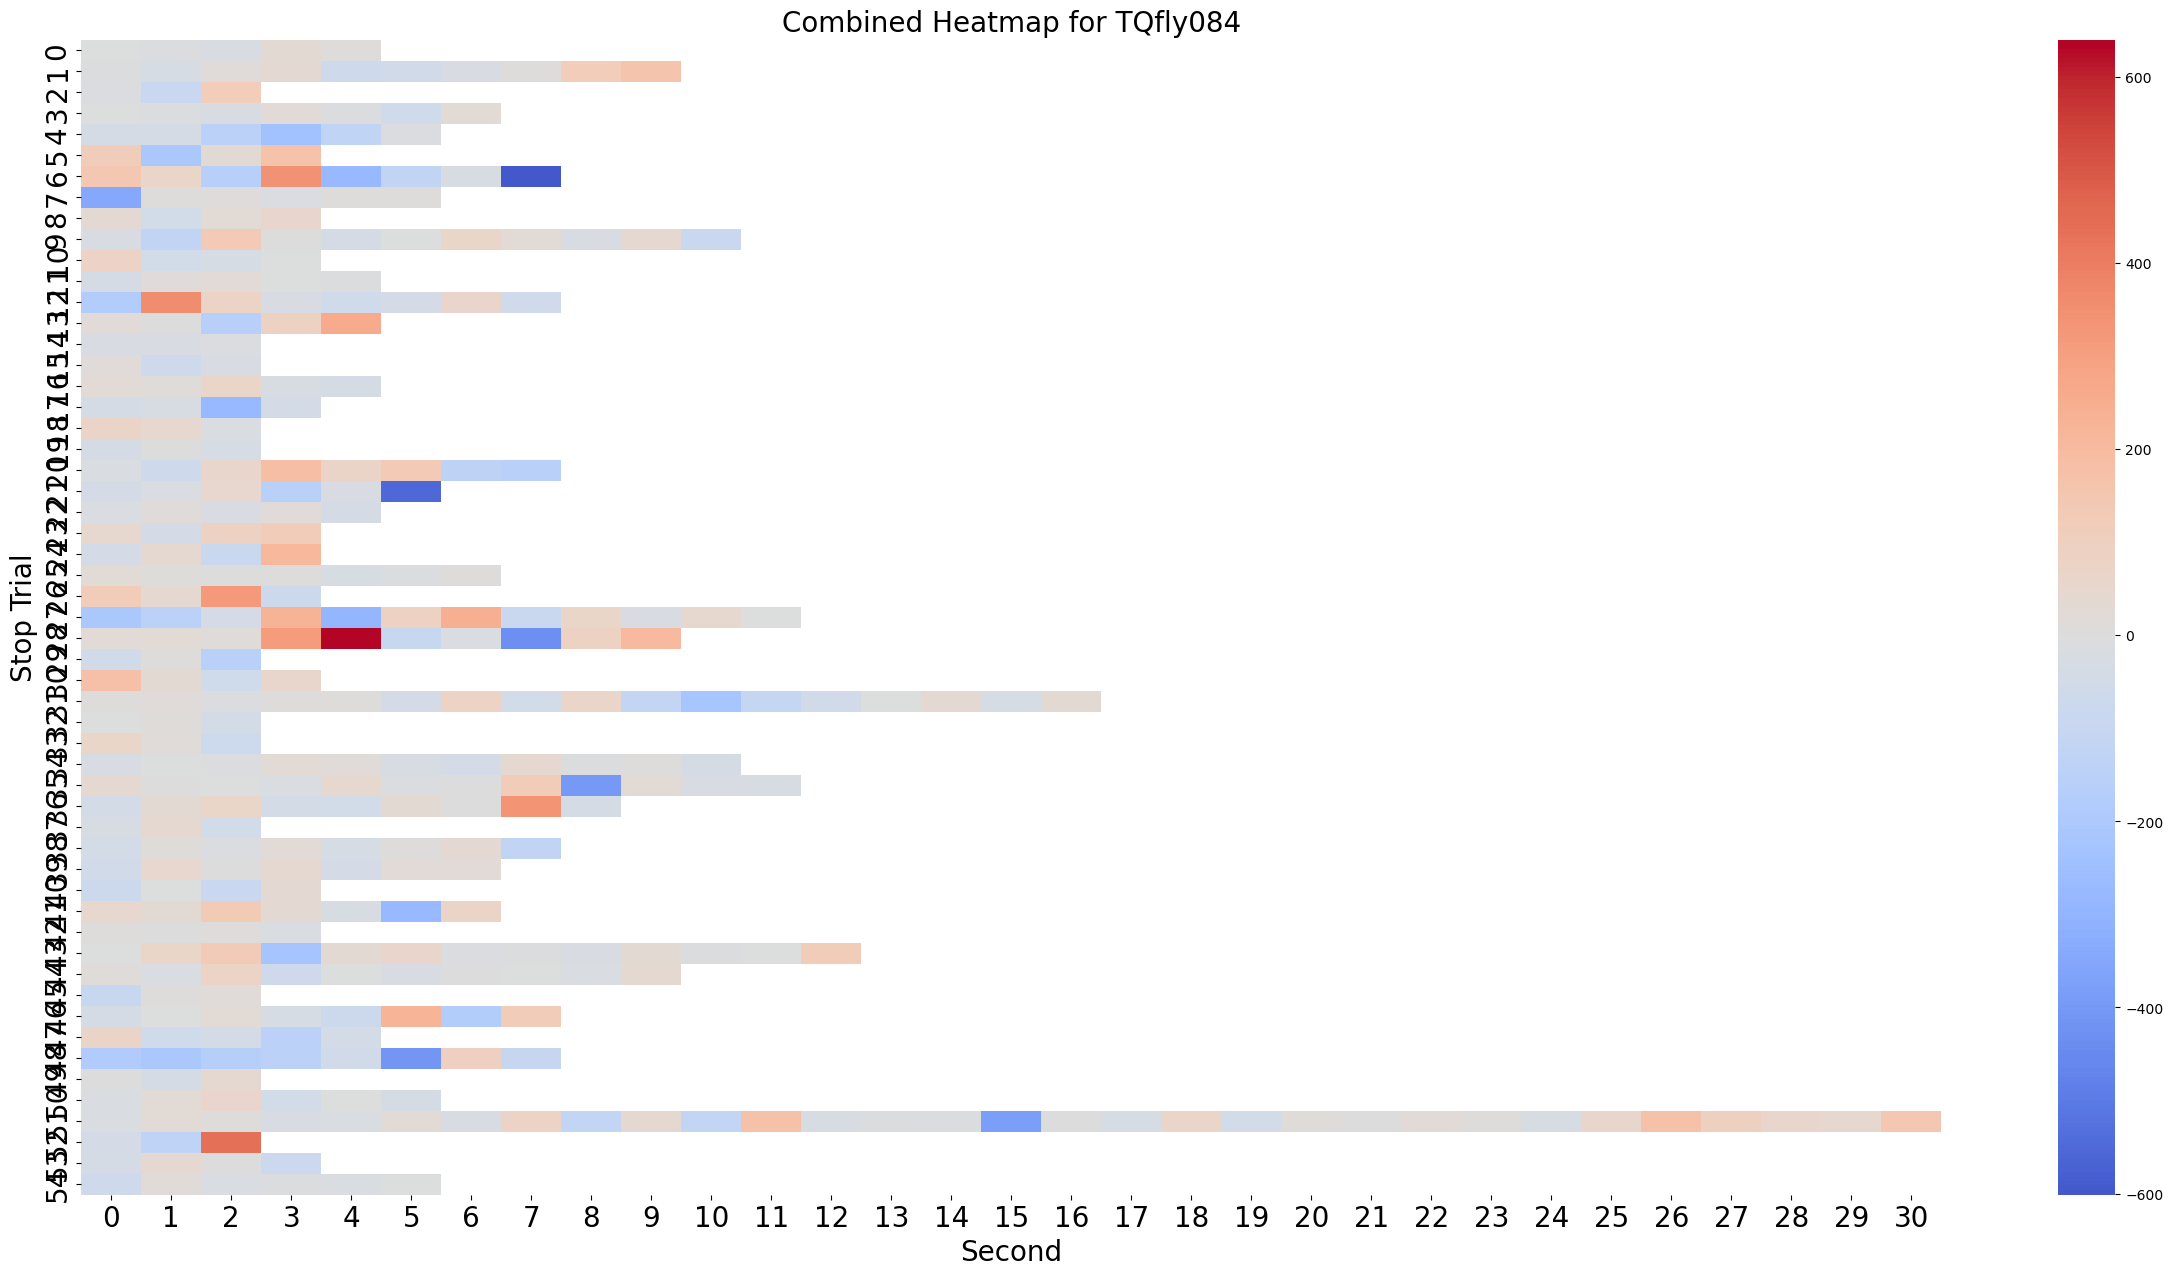

Plotting combined heatmap for experiment: TQfly082


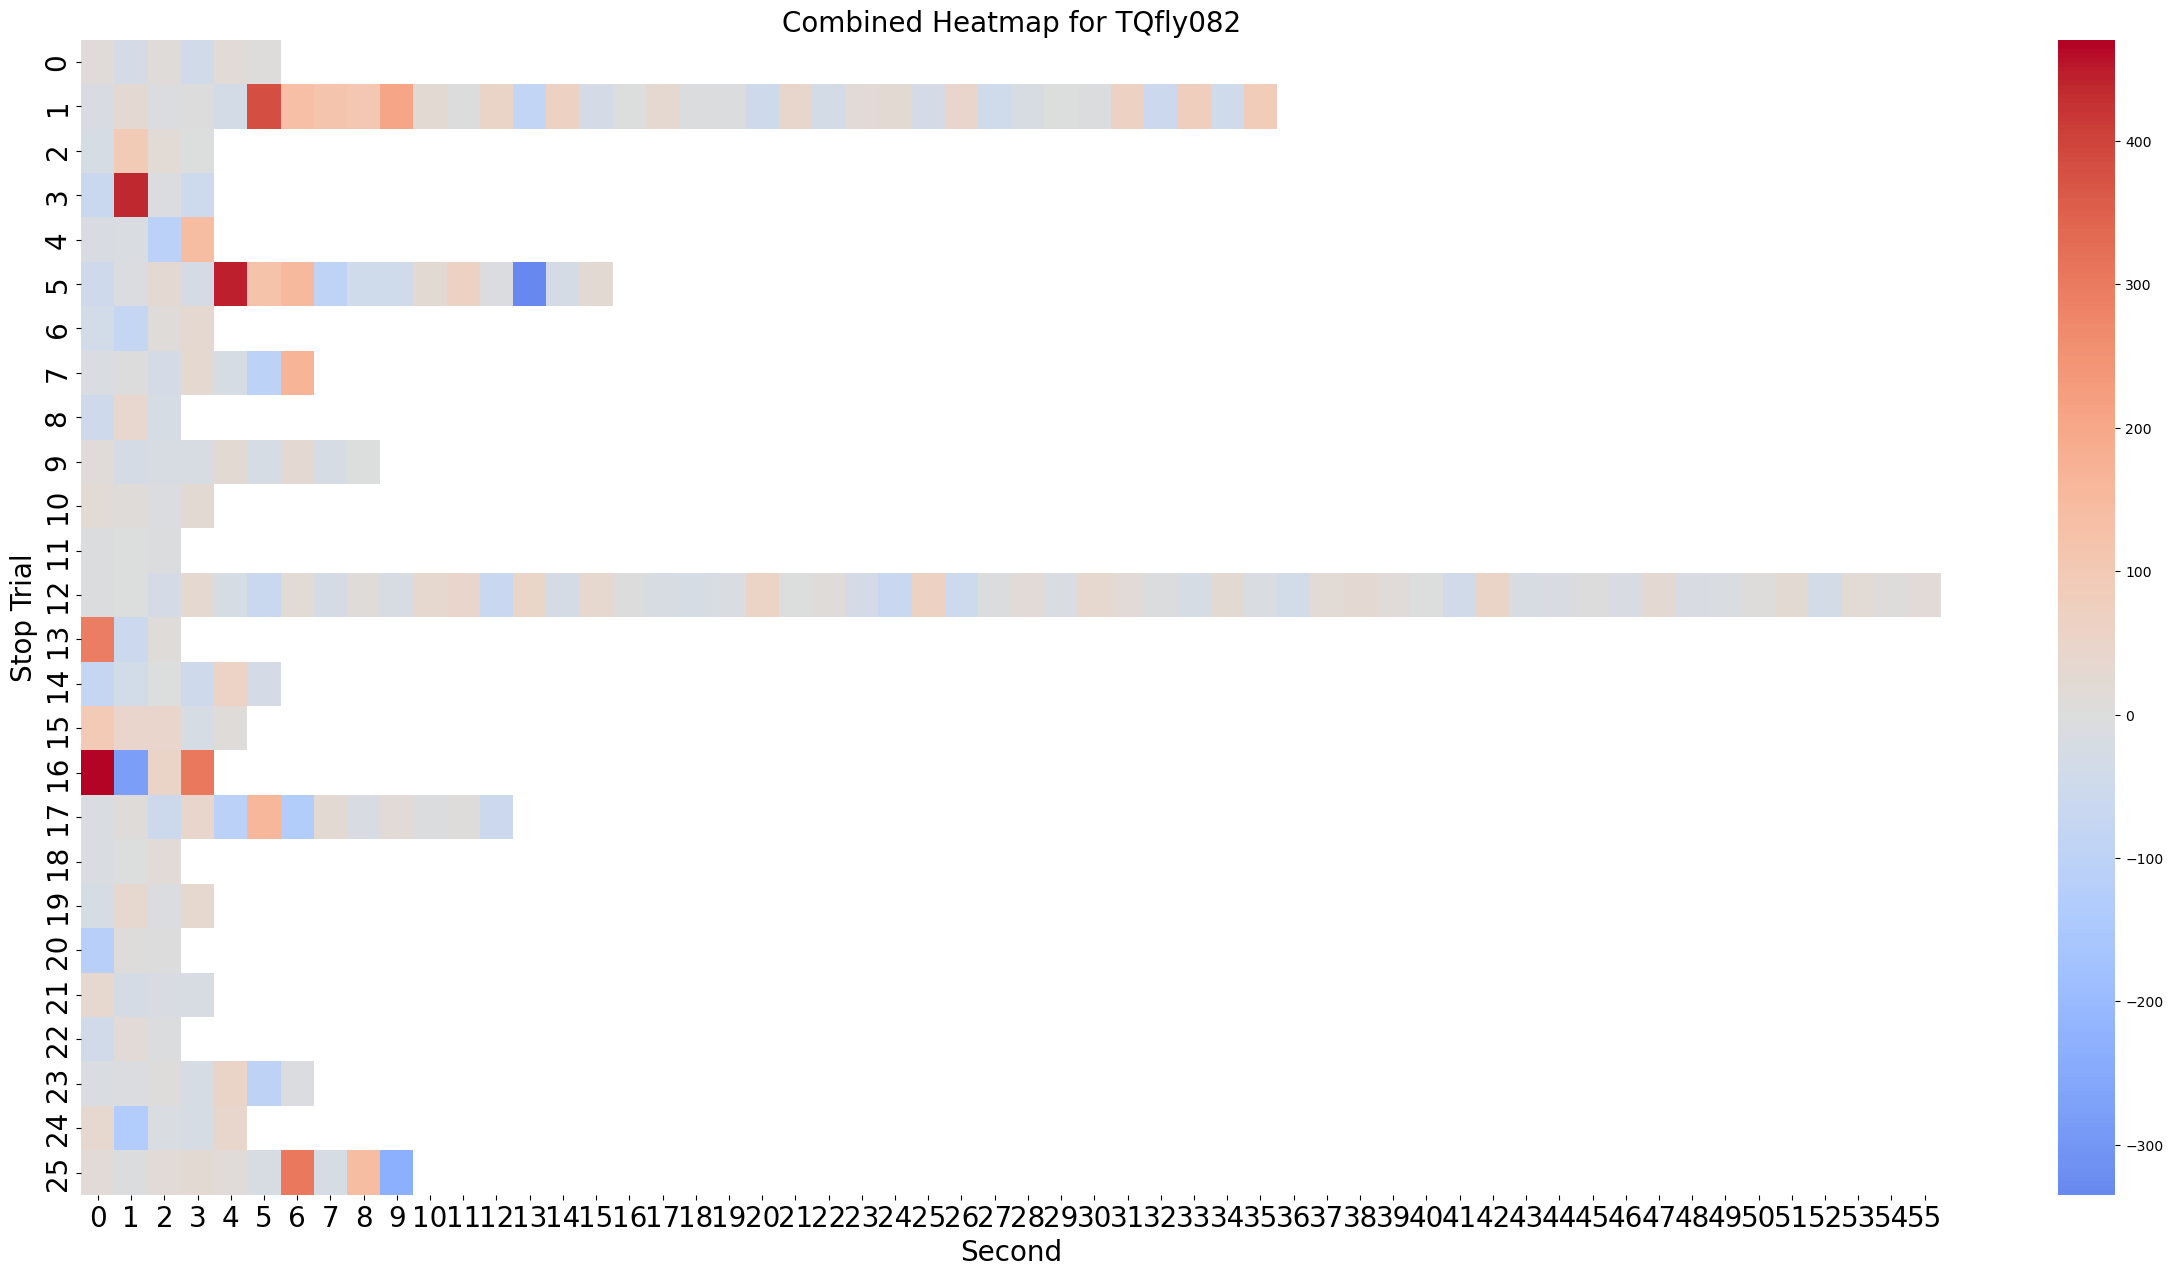

Plotting combined heatmap for experiment: TQfly089


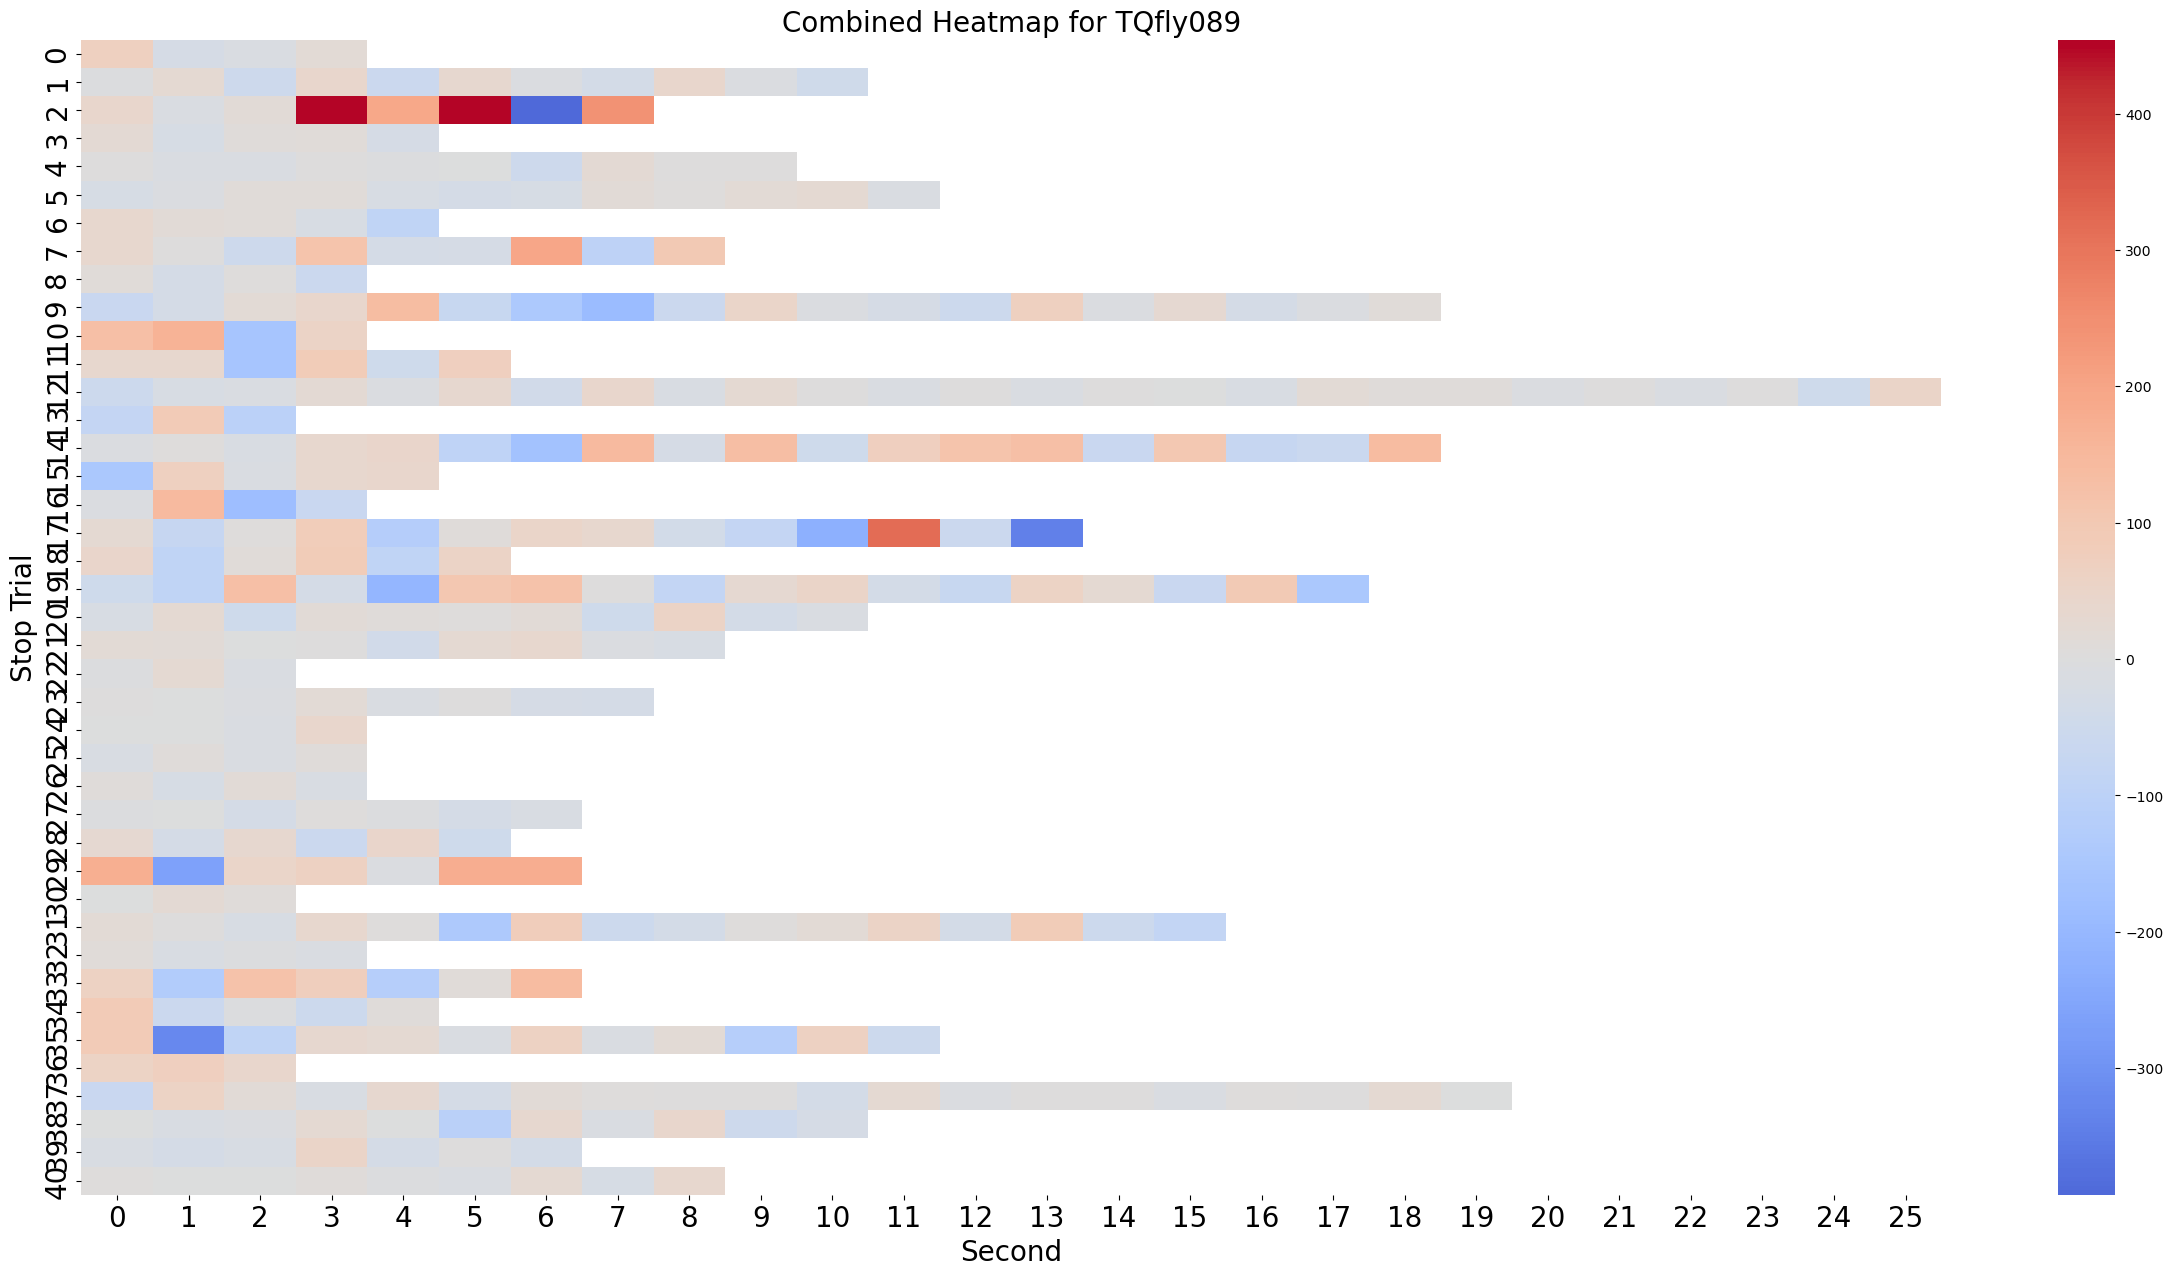

Plotting combined heatmap for experiment: TQfly080


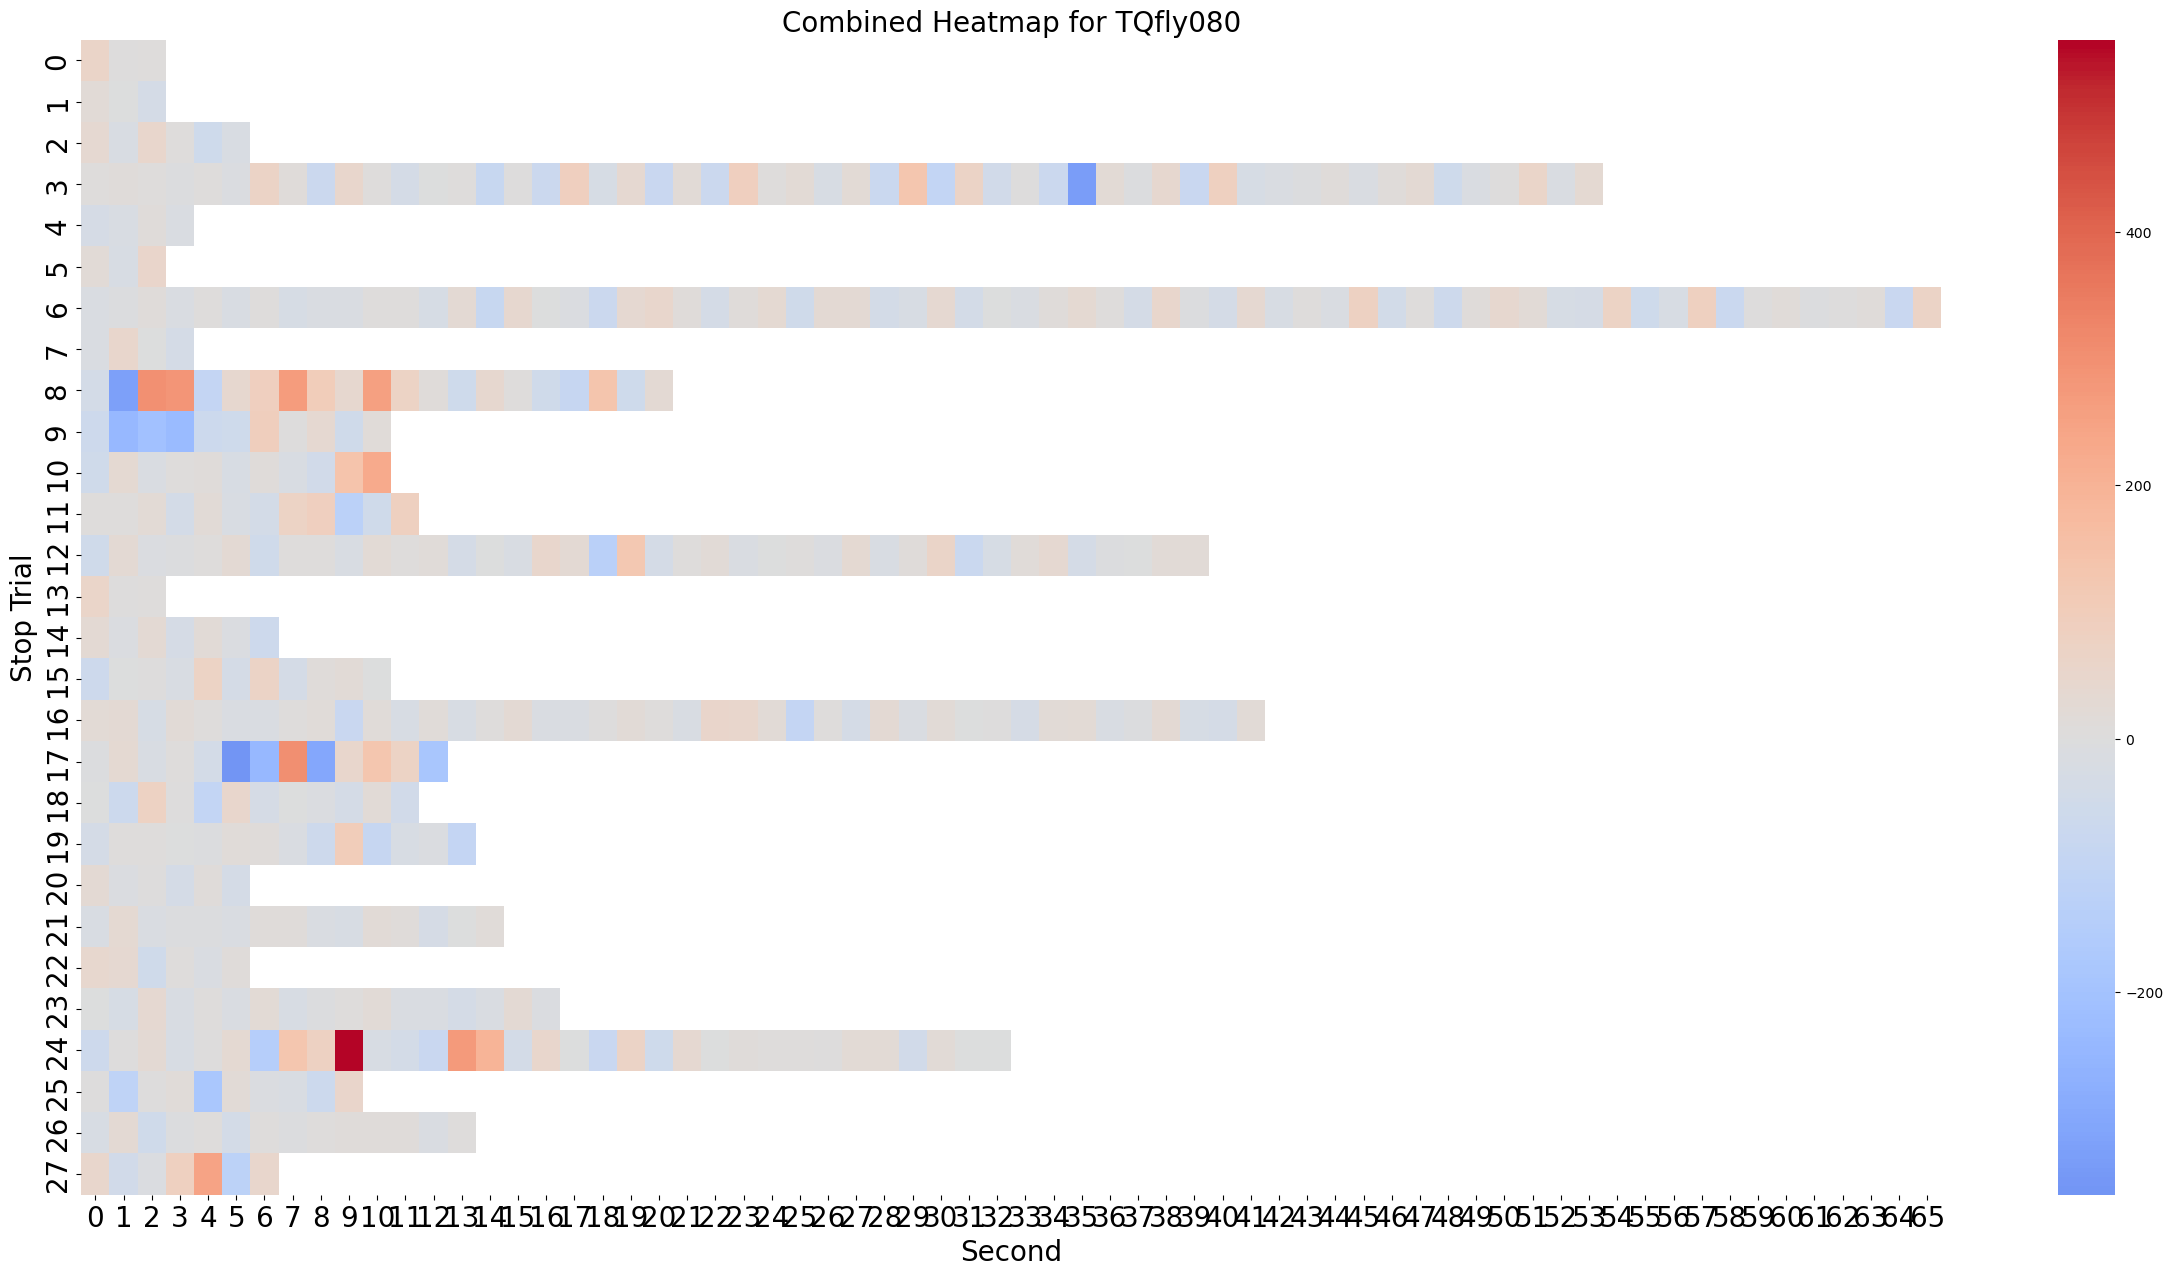

Plotting combined heatmap for experiment: TQfly086


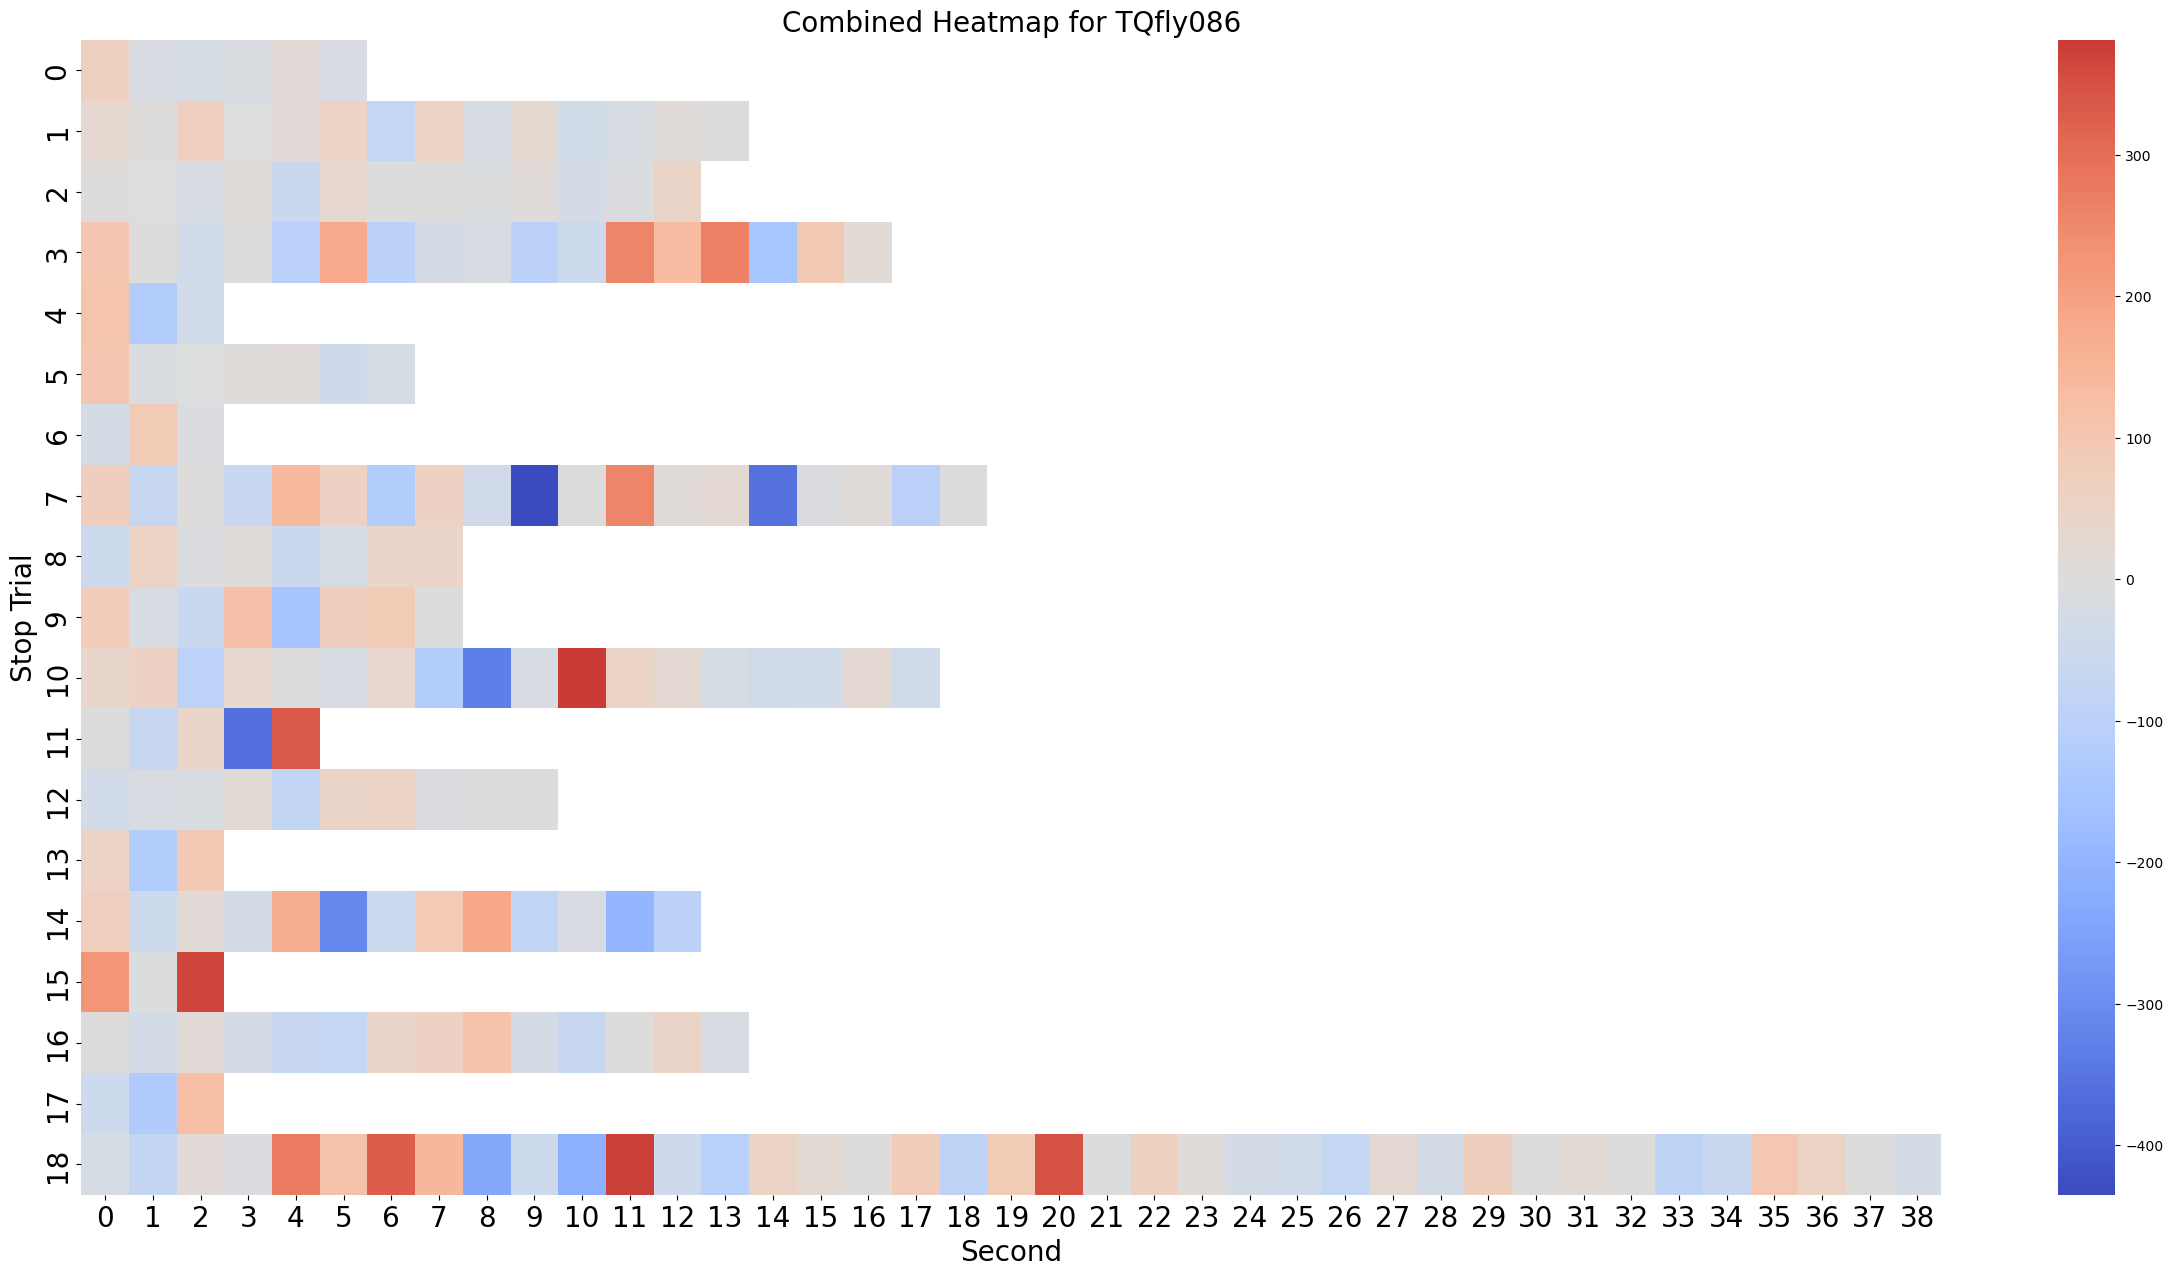

Plotting combined heatmap for experiment: TQfly078


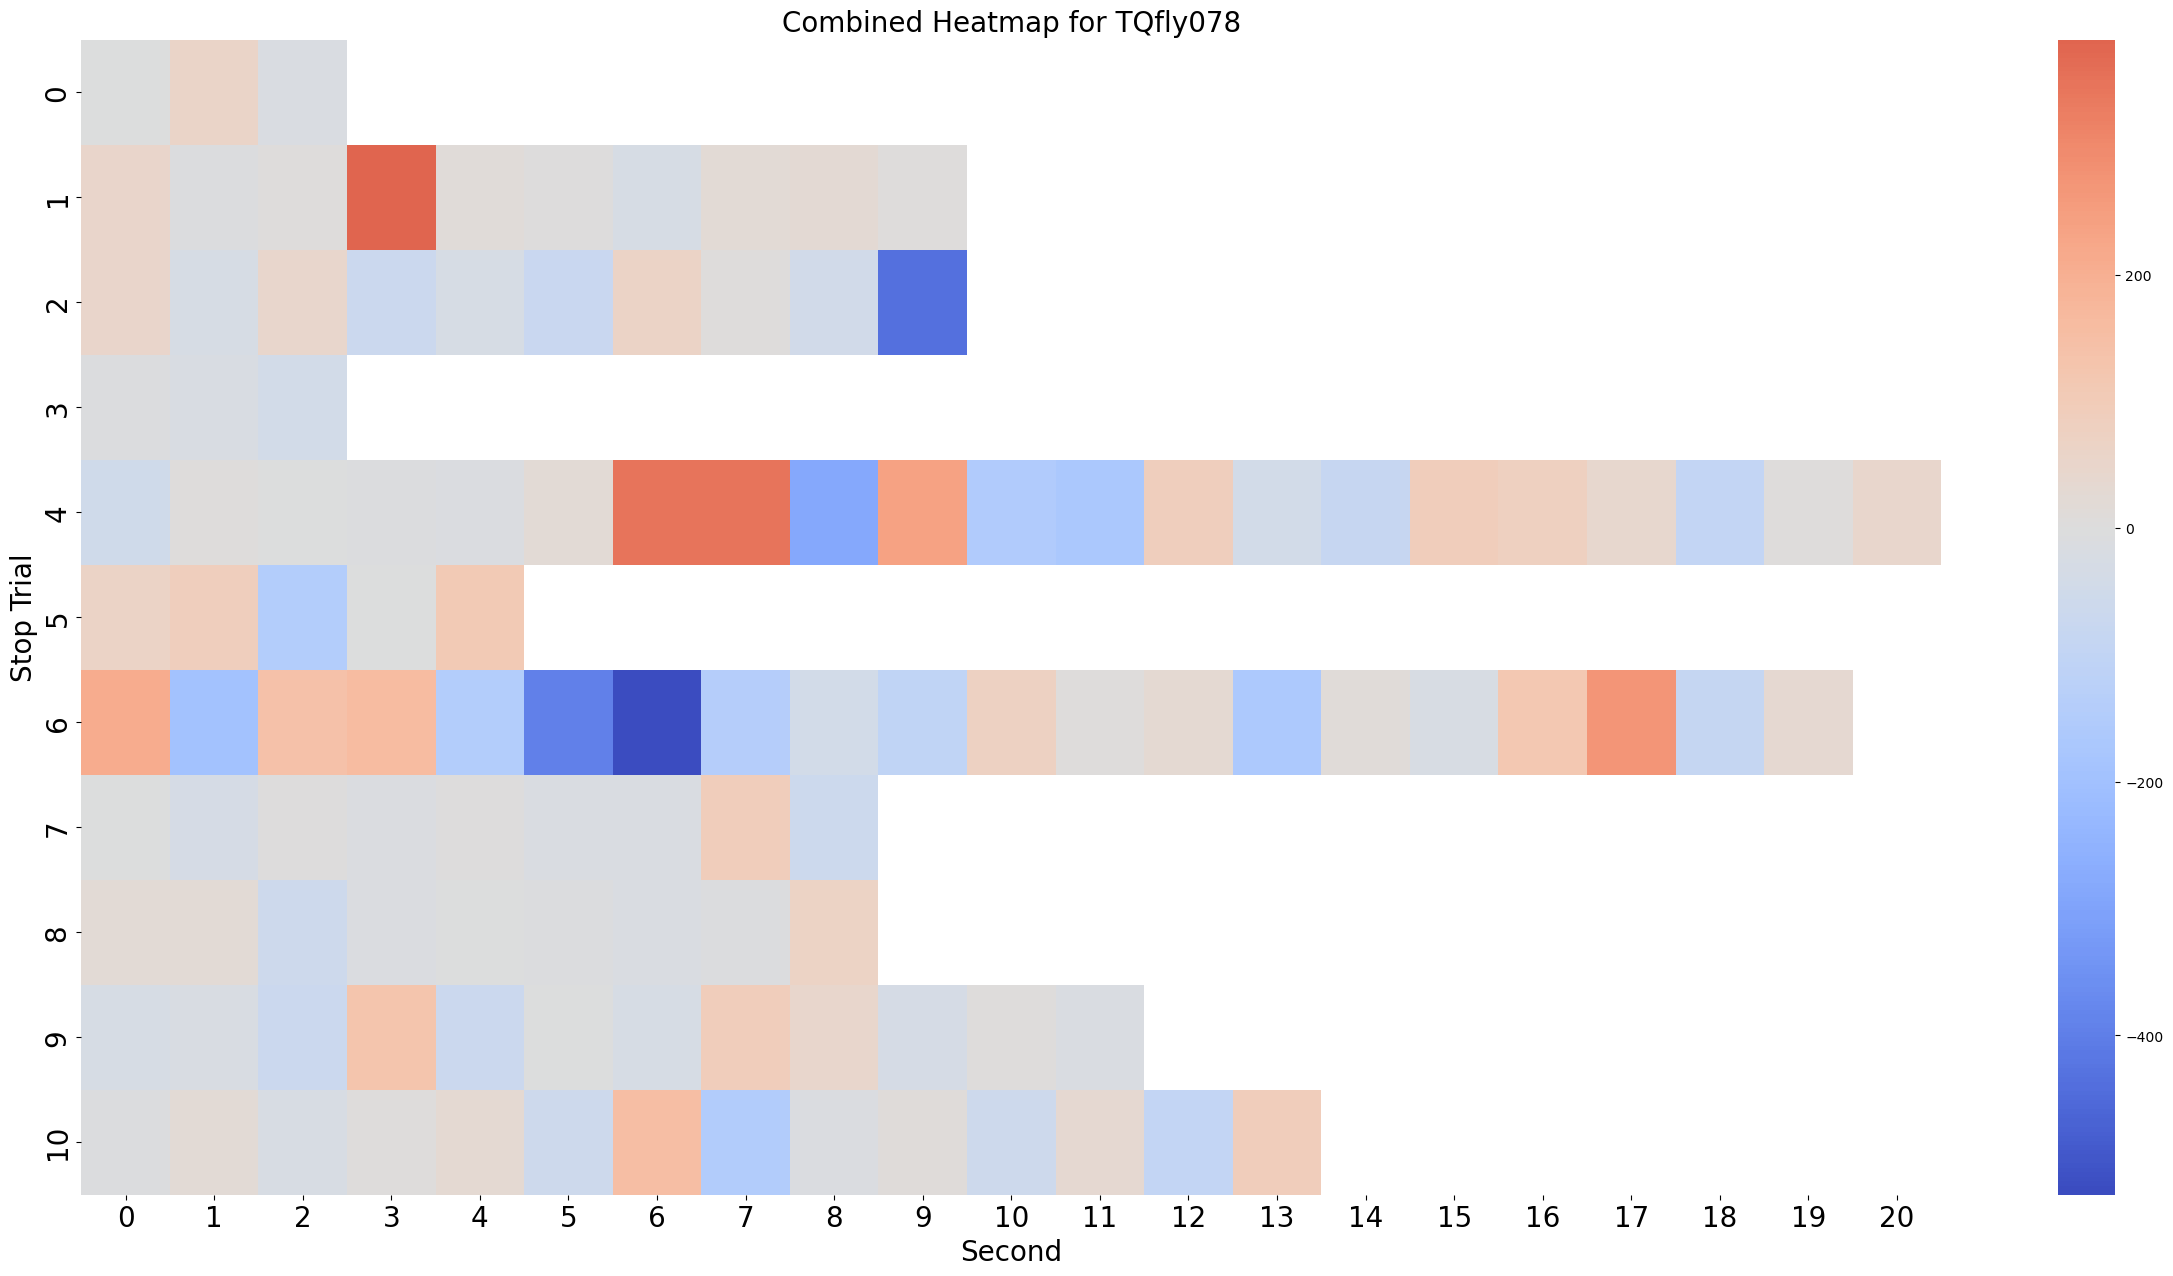

Done plotting all combined heatmaps.


In [31]:
# Function to plot heatmap for combined trials of each experiment
def plot_heatmap(data, title):
    plt.figure(figsize=(30, 15))
    sns.heatmap(data, cmap="coolwarm", annot=False, center=0)
    plt.title(title, fontsize=20)
    plt.xlabel('Second', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Stop Trial', fontsize=20)
    plt.show()

# Loop through each experiment and its trials
for key, trials in data_all['output_second_wise_bump_drift'].items():
    print(f"Plotting combined heatmap for experiment: {key}")
    combined_data = []
    
    for trial in trials:
        # Flatten the nested lists for each trial
        trial_data = []
        for array in trial:
            if len(array) > 0: 
                trial_data.append(array)
        
        if len(trial_data) > 0:
            # Find the maximum length of the arrays for padding
            max_length = max(len(arr) for arr in trial_data)

            # Pad arrays to have the same length with NaN
            padded_data = np.array([np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=np.nan) for arr in trial_data])

            # Append padded data to combined_data
            combined_data.extend(padded_data)
    
    # Convert the combined data to a DataFrame
    df = pd.DataFrame(combined_data)

    # Plot heatmap for combined trials
    plot_heatmap(df, f'Combined Heatmap for {key}')
    # Plot heatmap for each trial
    #plot_heatmap(df, f'Heatmap for {key} - Trial {i+1}')

print("Done plotting all combined heatmaps.")

Plotting combined heatmap for experiment: TQfly092


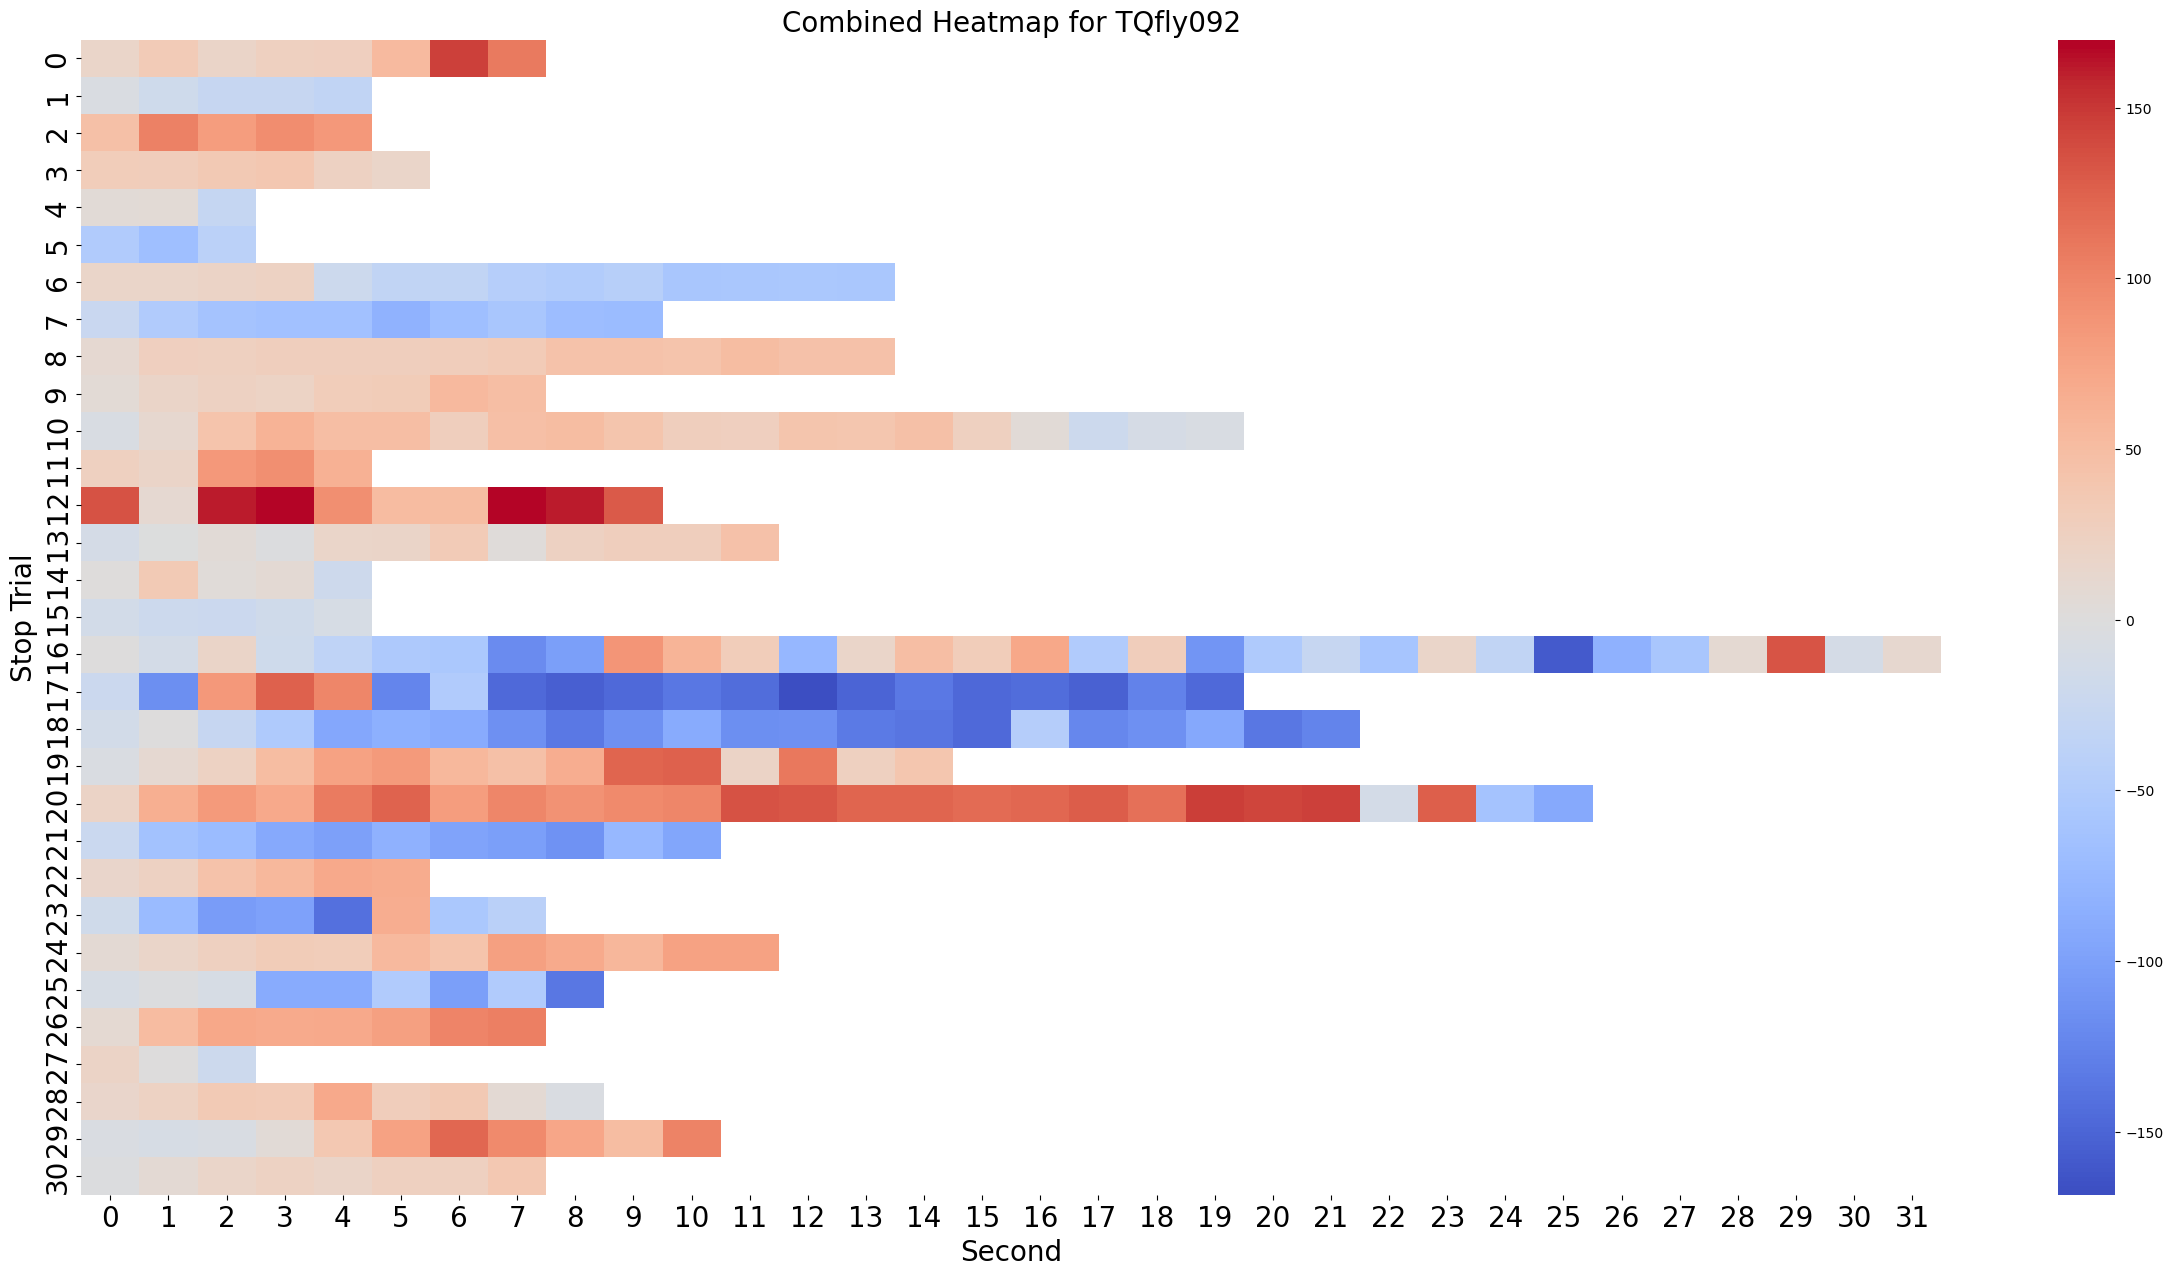

Plotting combined heatmap for experiment: TQfly094


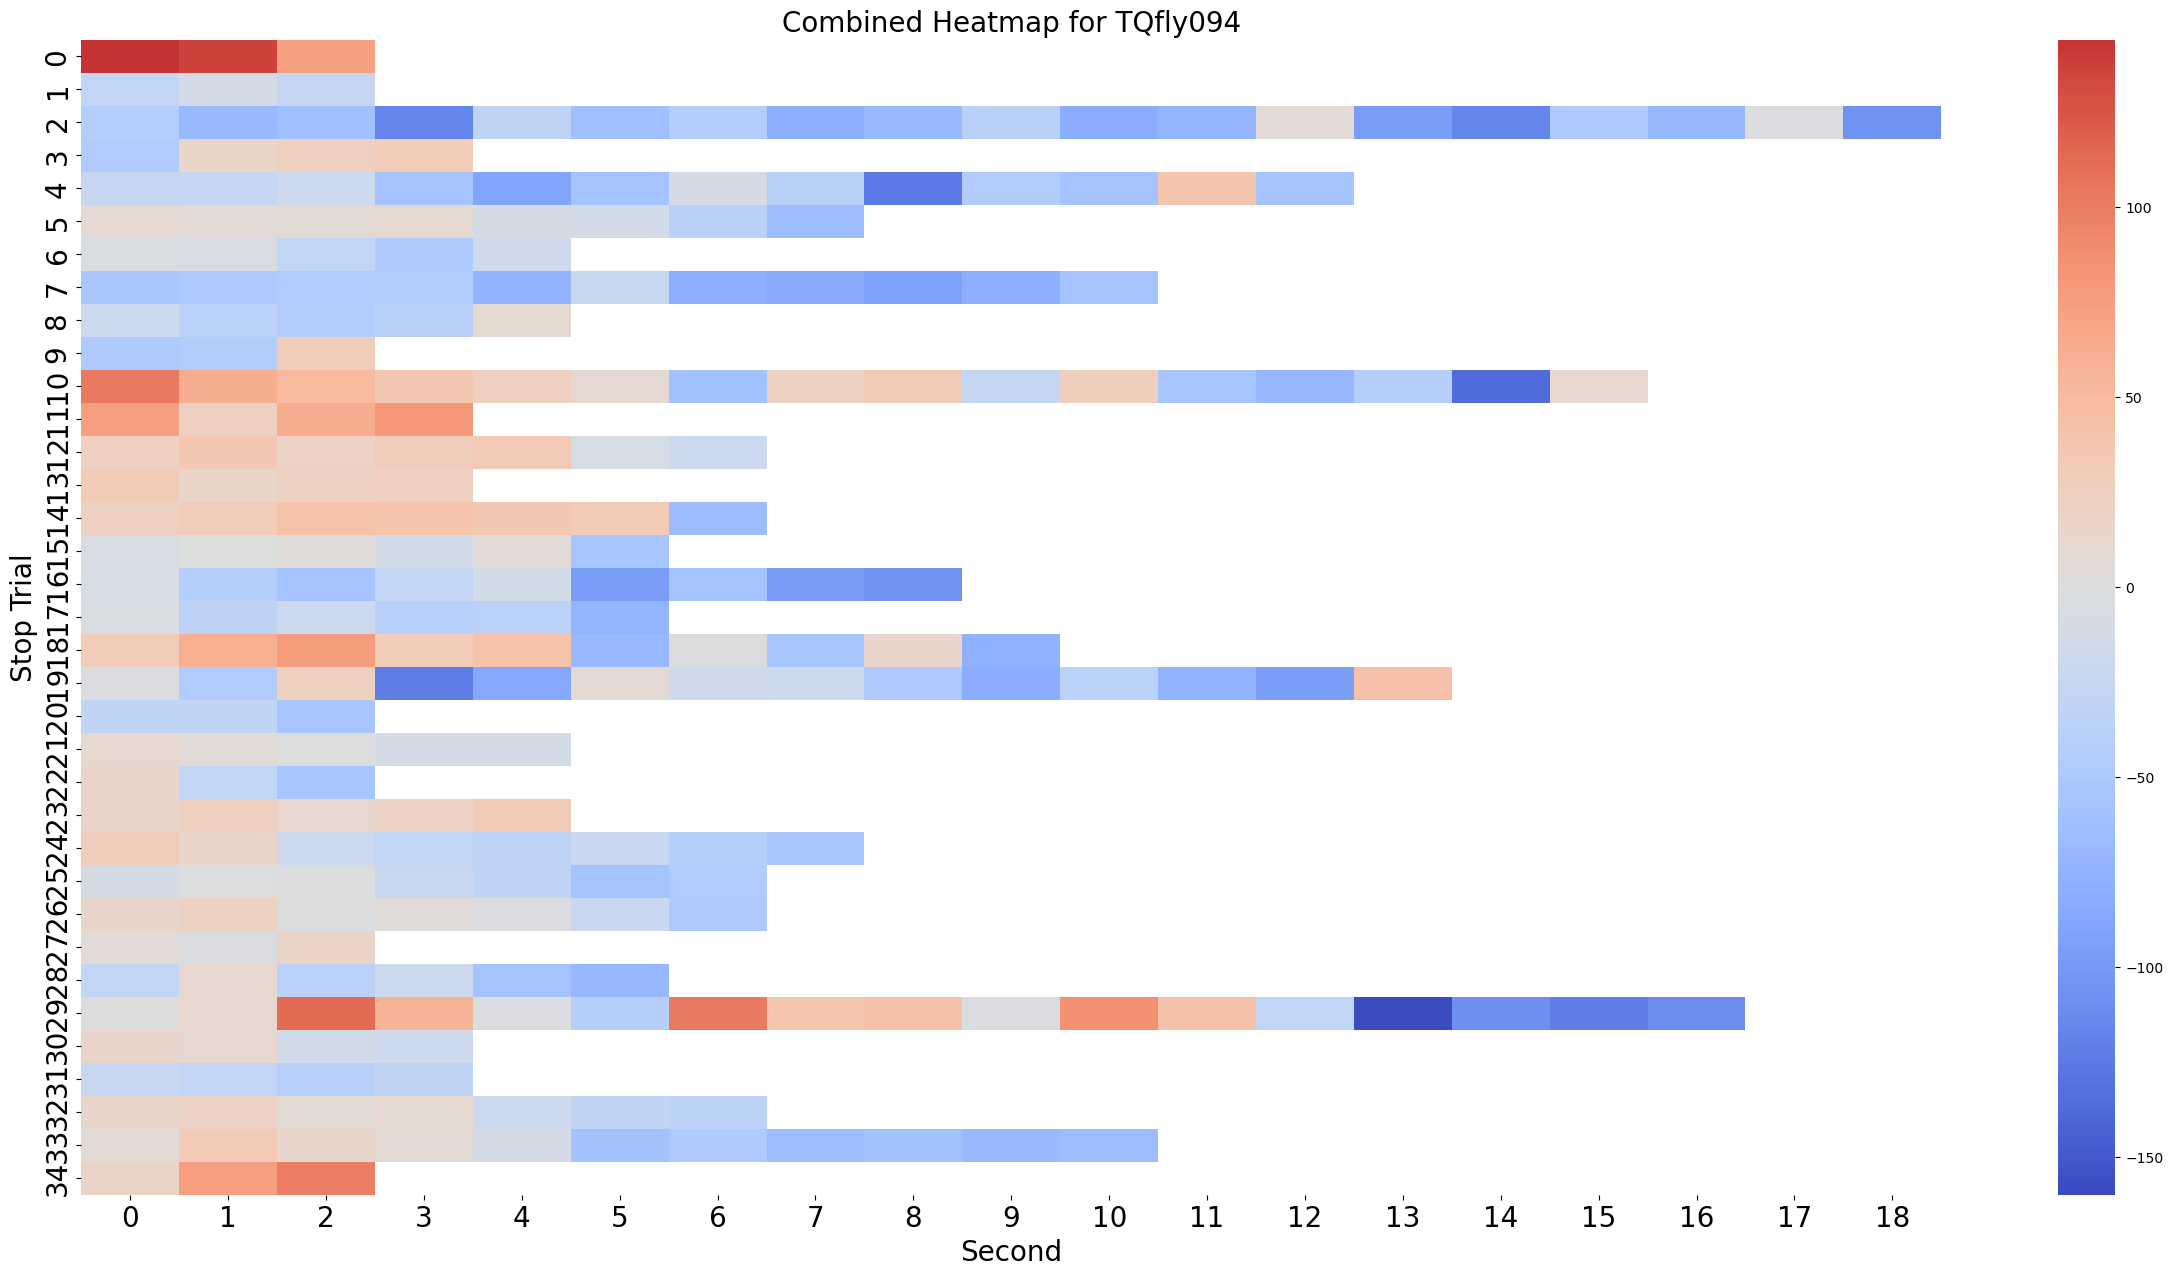

Plotting combined heatmap for experiment: TQfly079


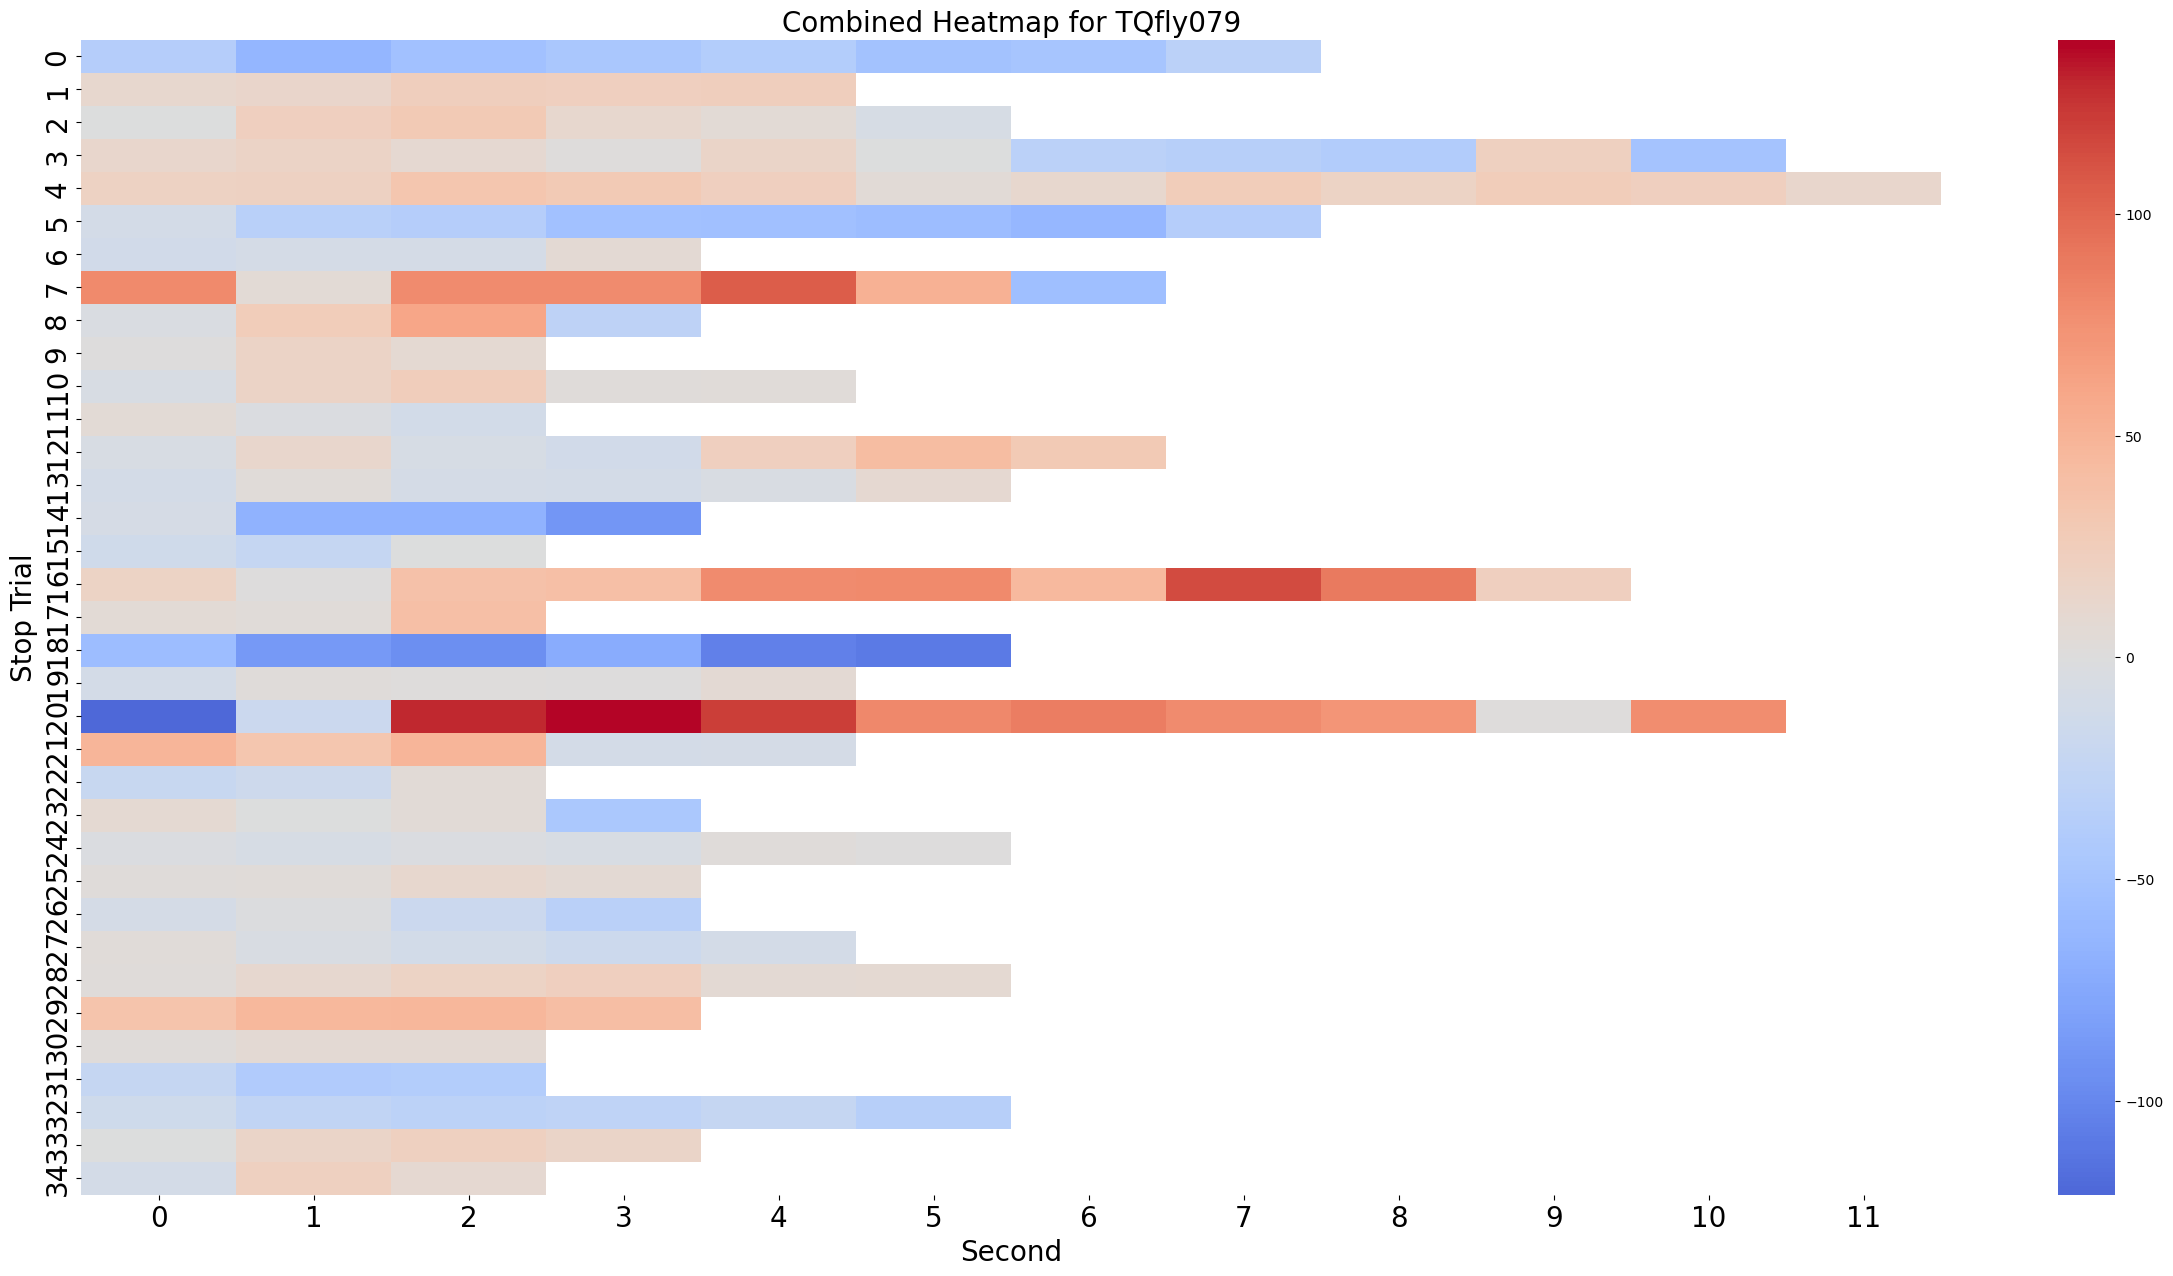

Plotting combined heatmap for experiment: TQfly095


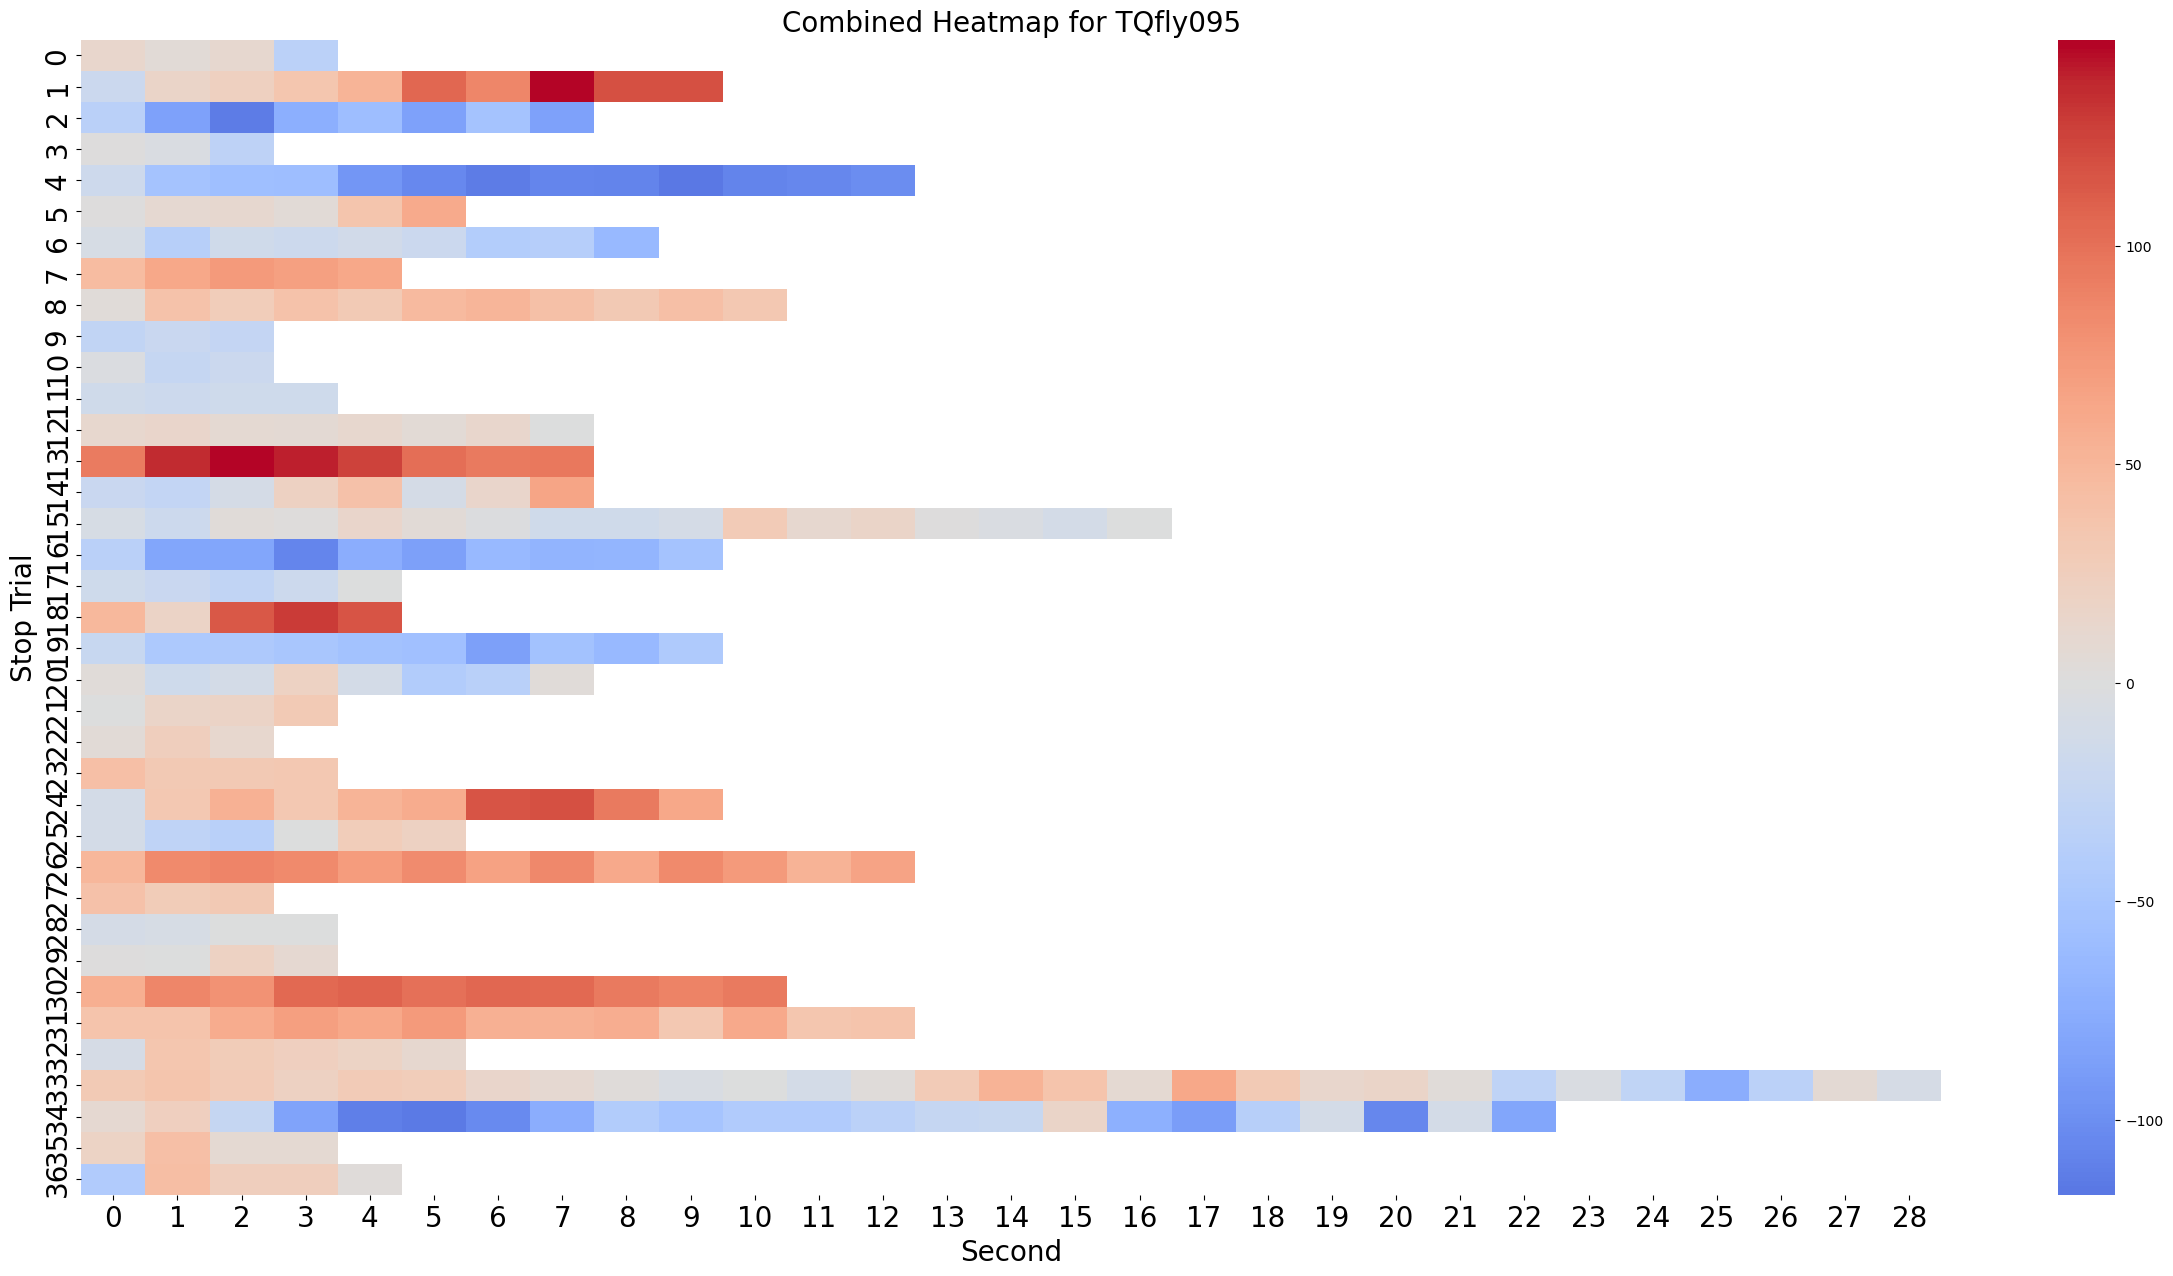

Plotting combined heatmap for experiment: TQfly084


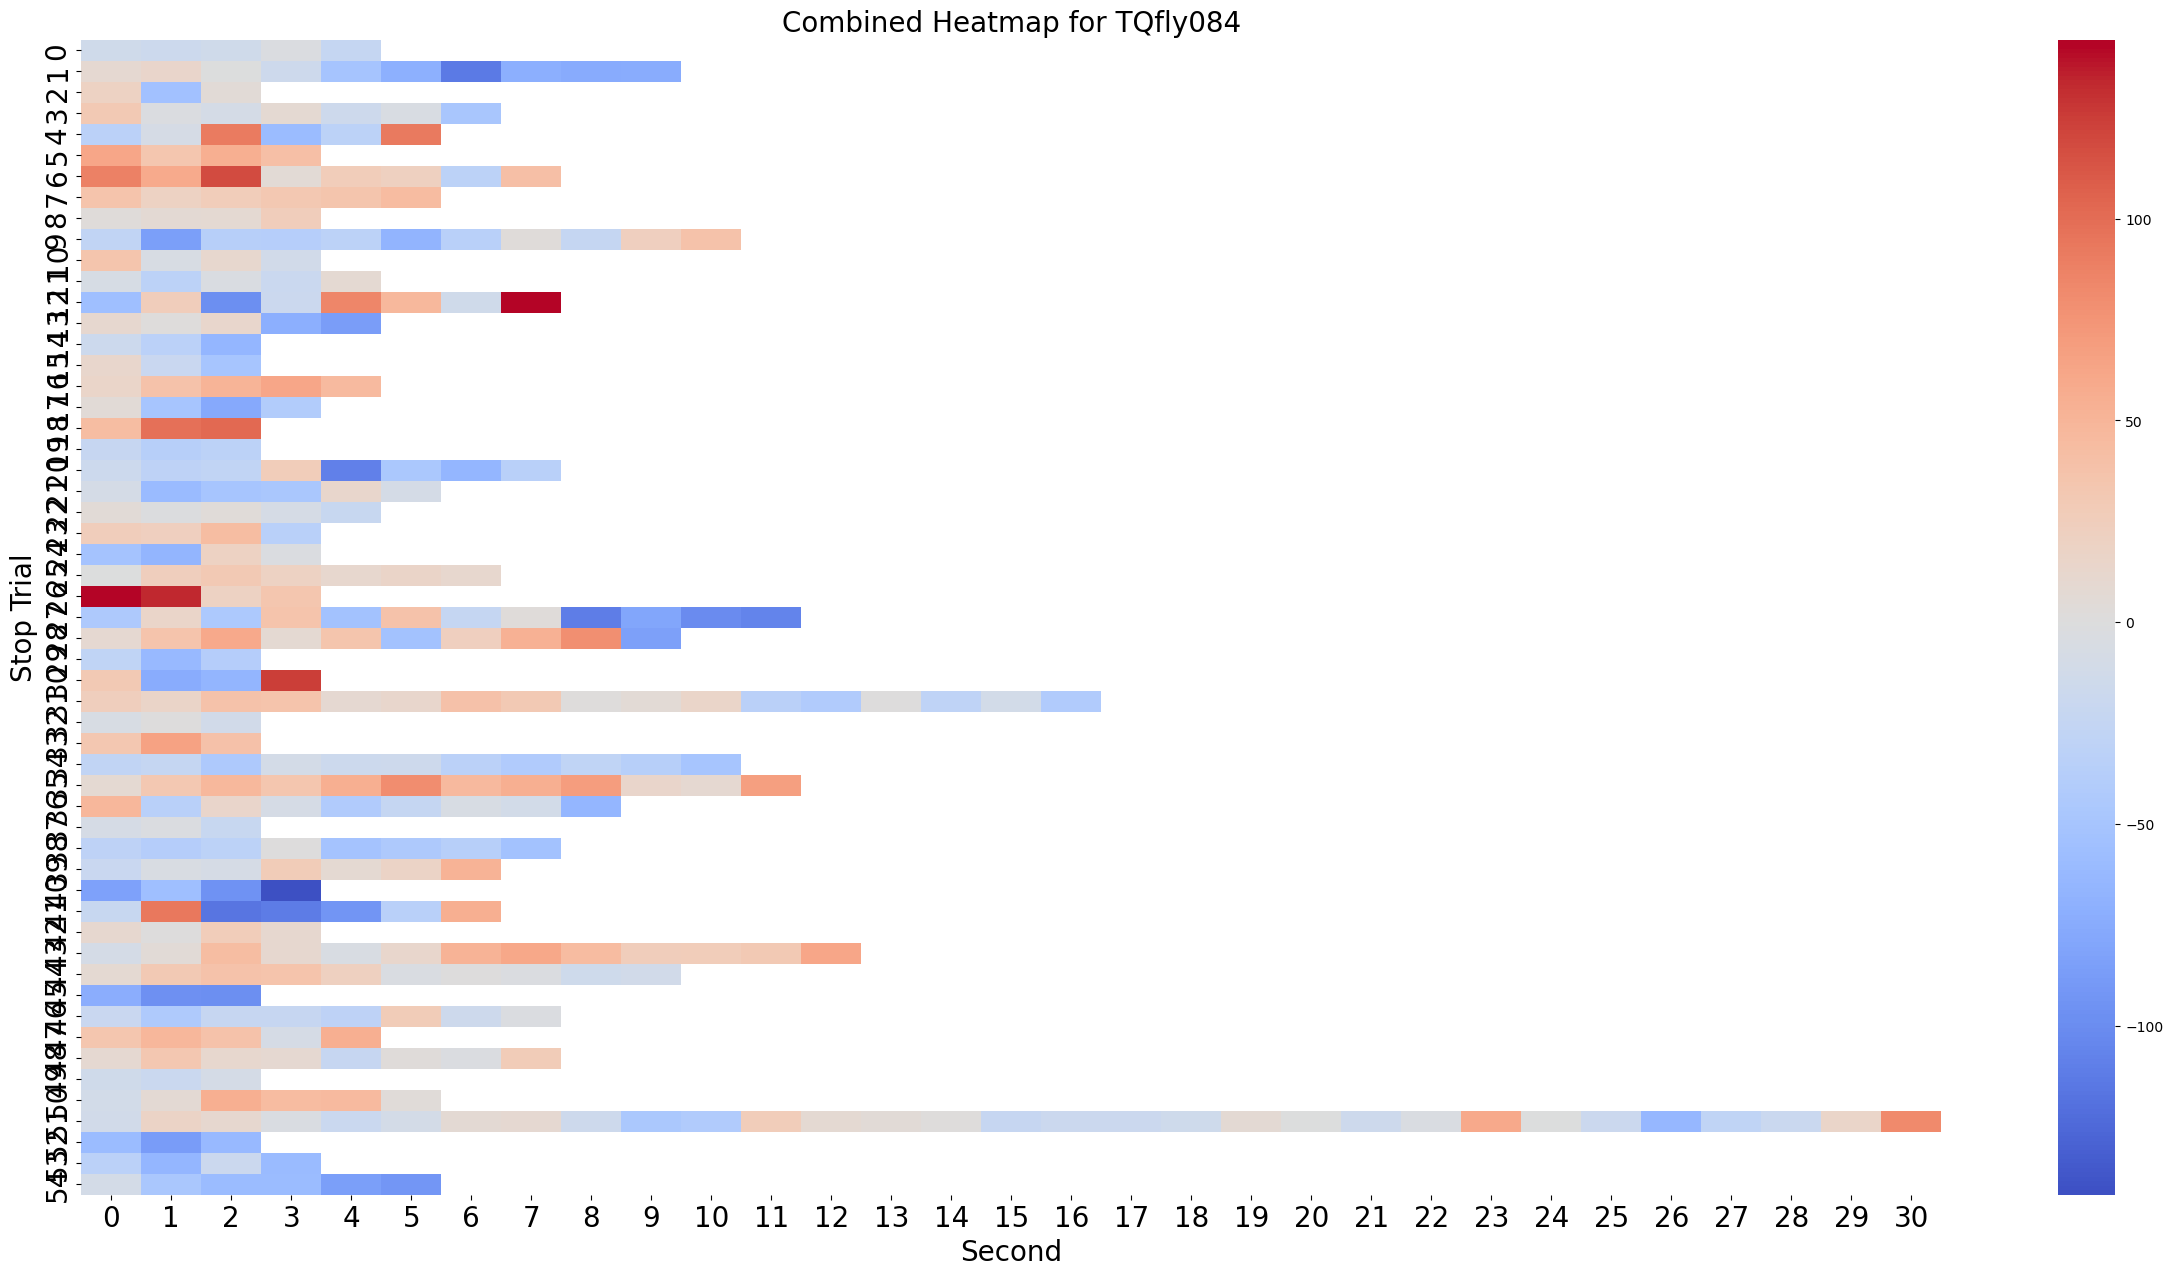

Plotting combined heatmap for experiment: TQfly082


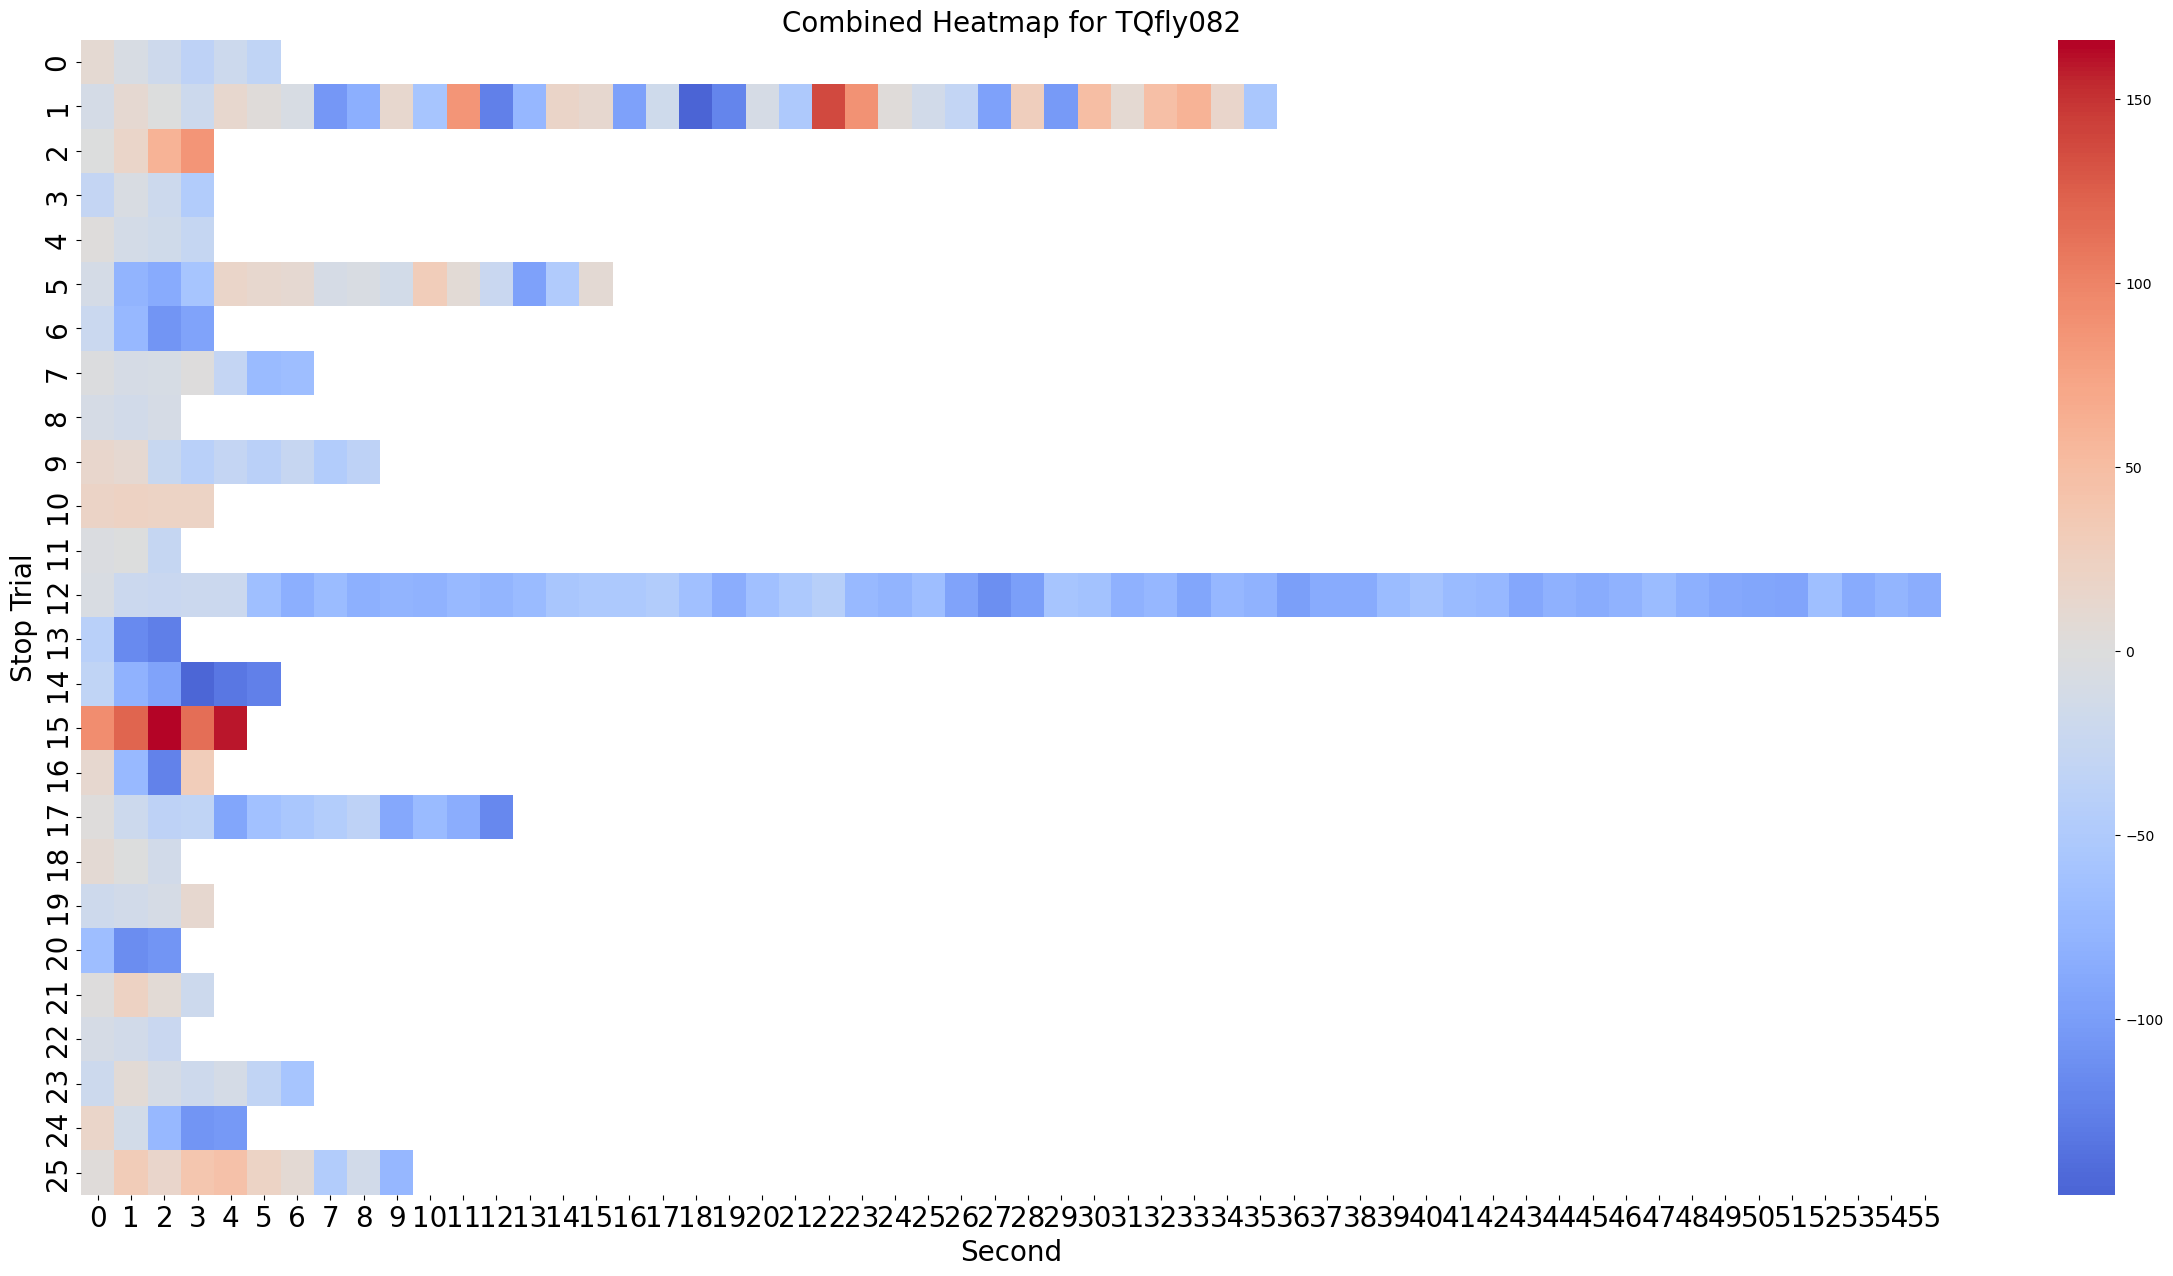

Plotting combined heatmap for experiment: TQfly089


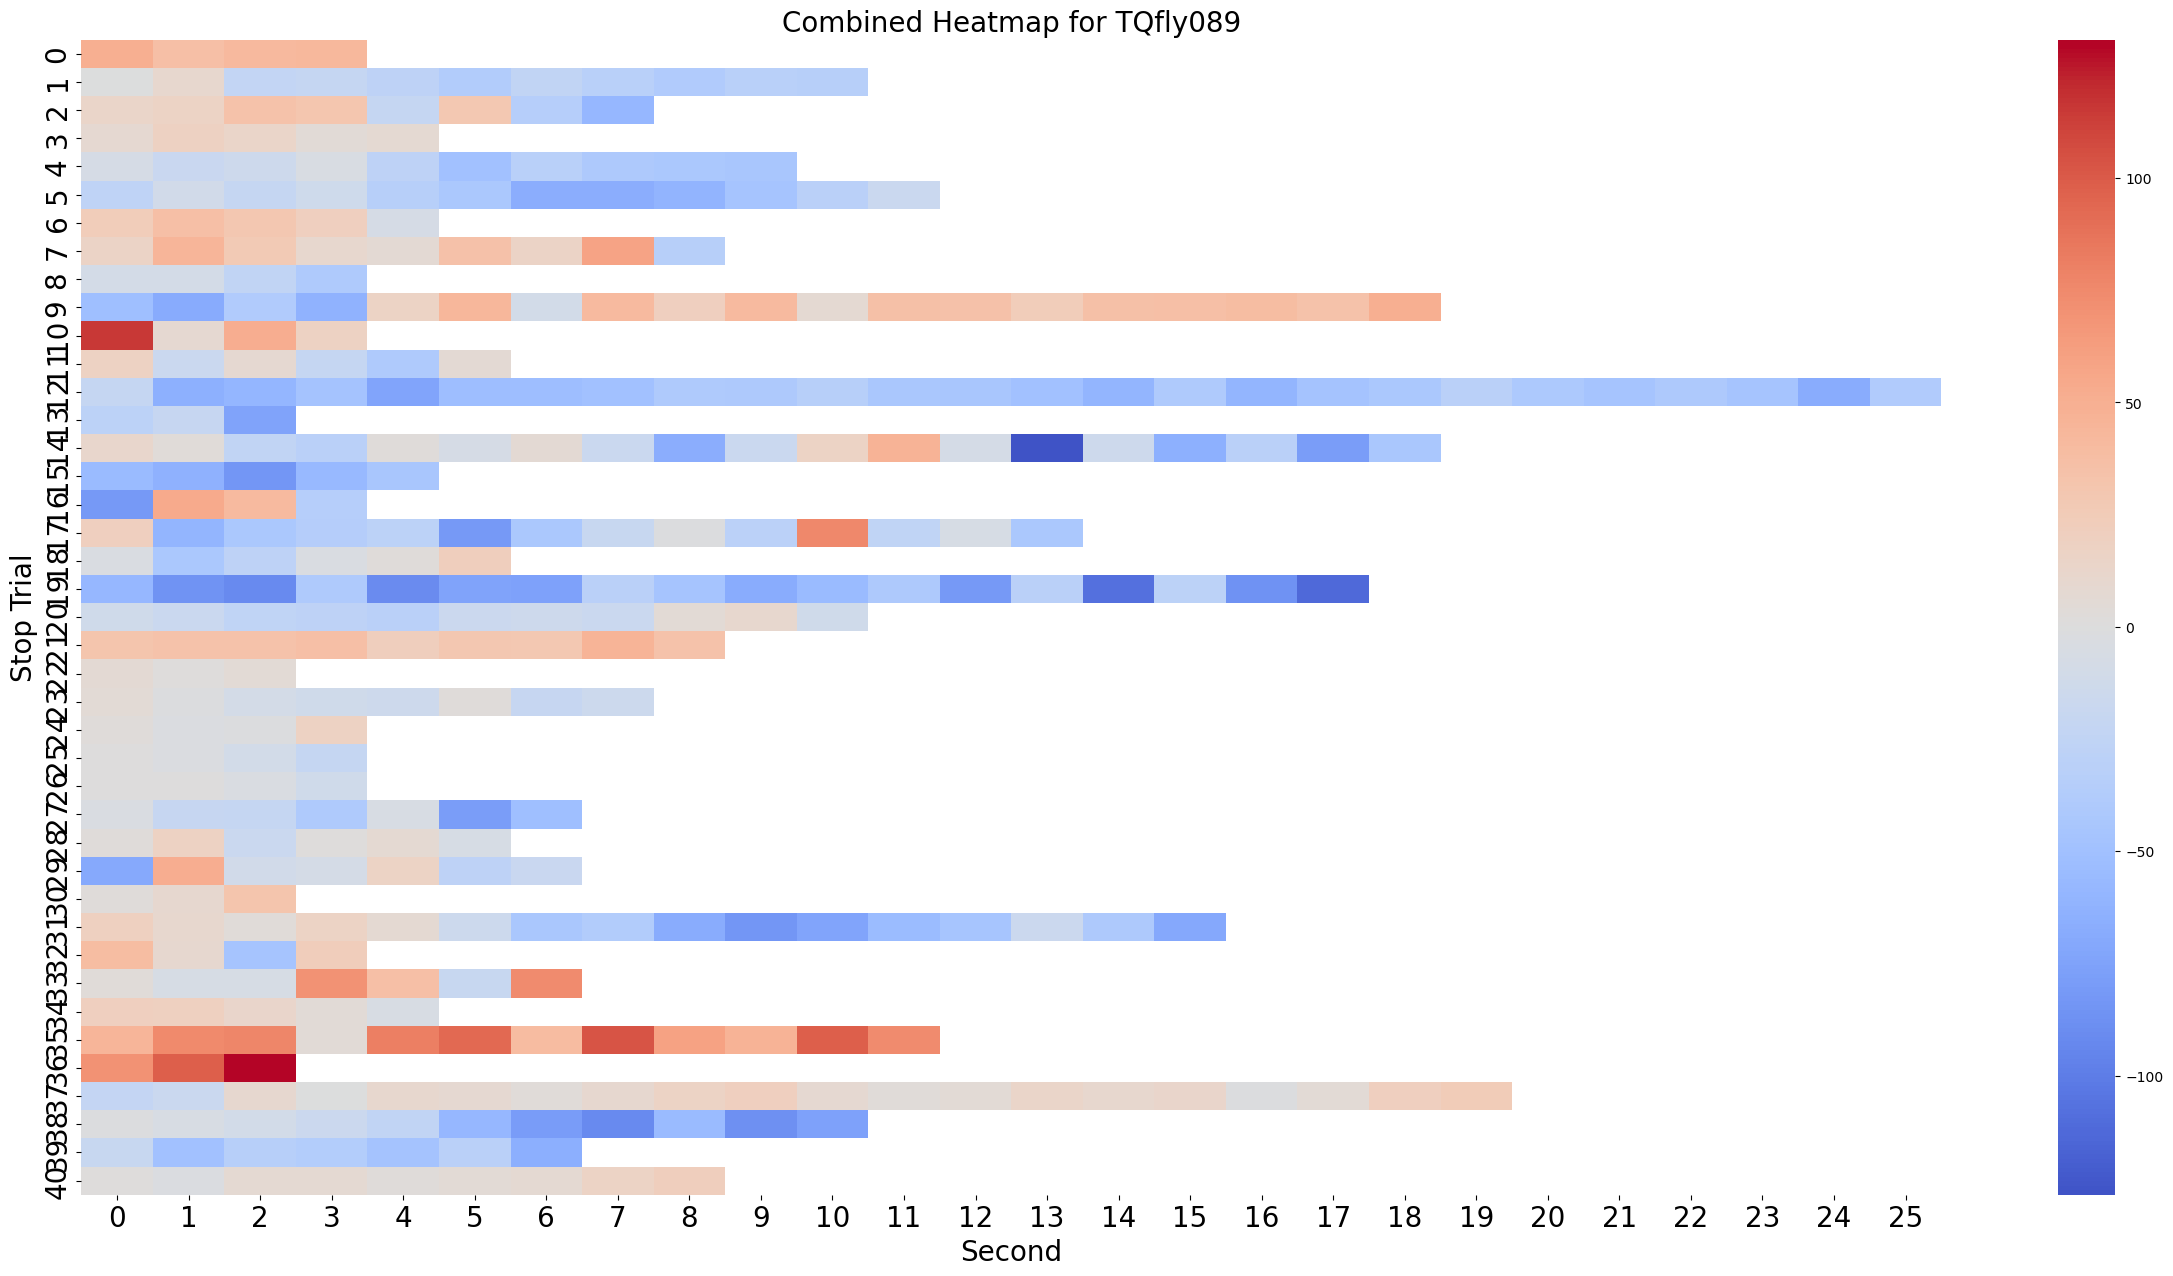

Plotting combined heatmap for experiment: TQfly080


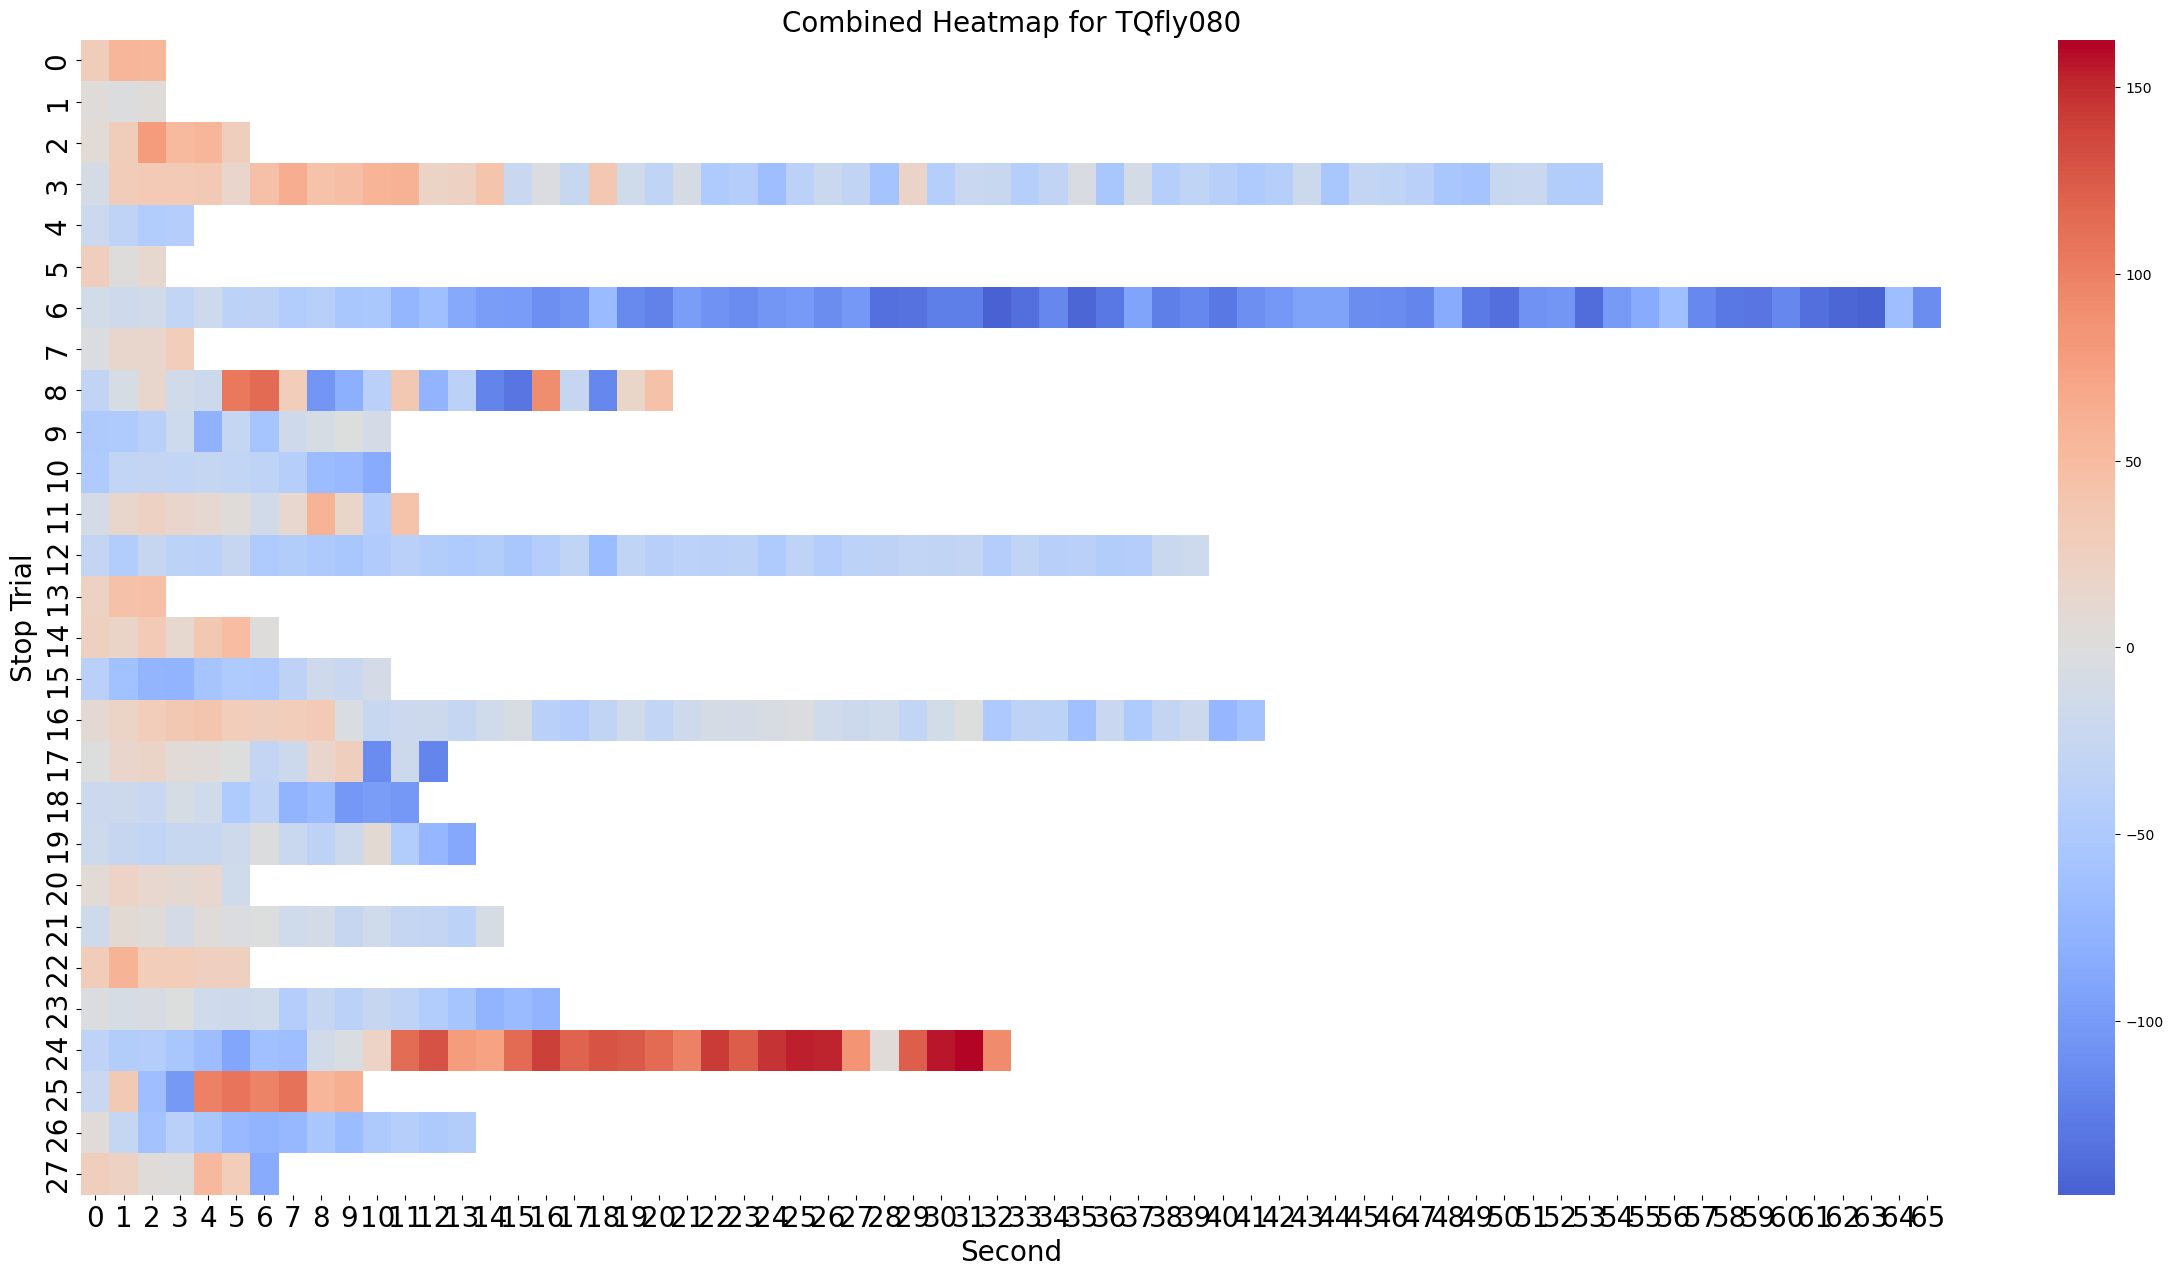

Plotting combined heatmap for experiment: TQfly086


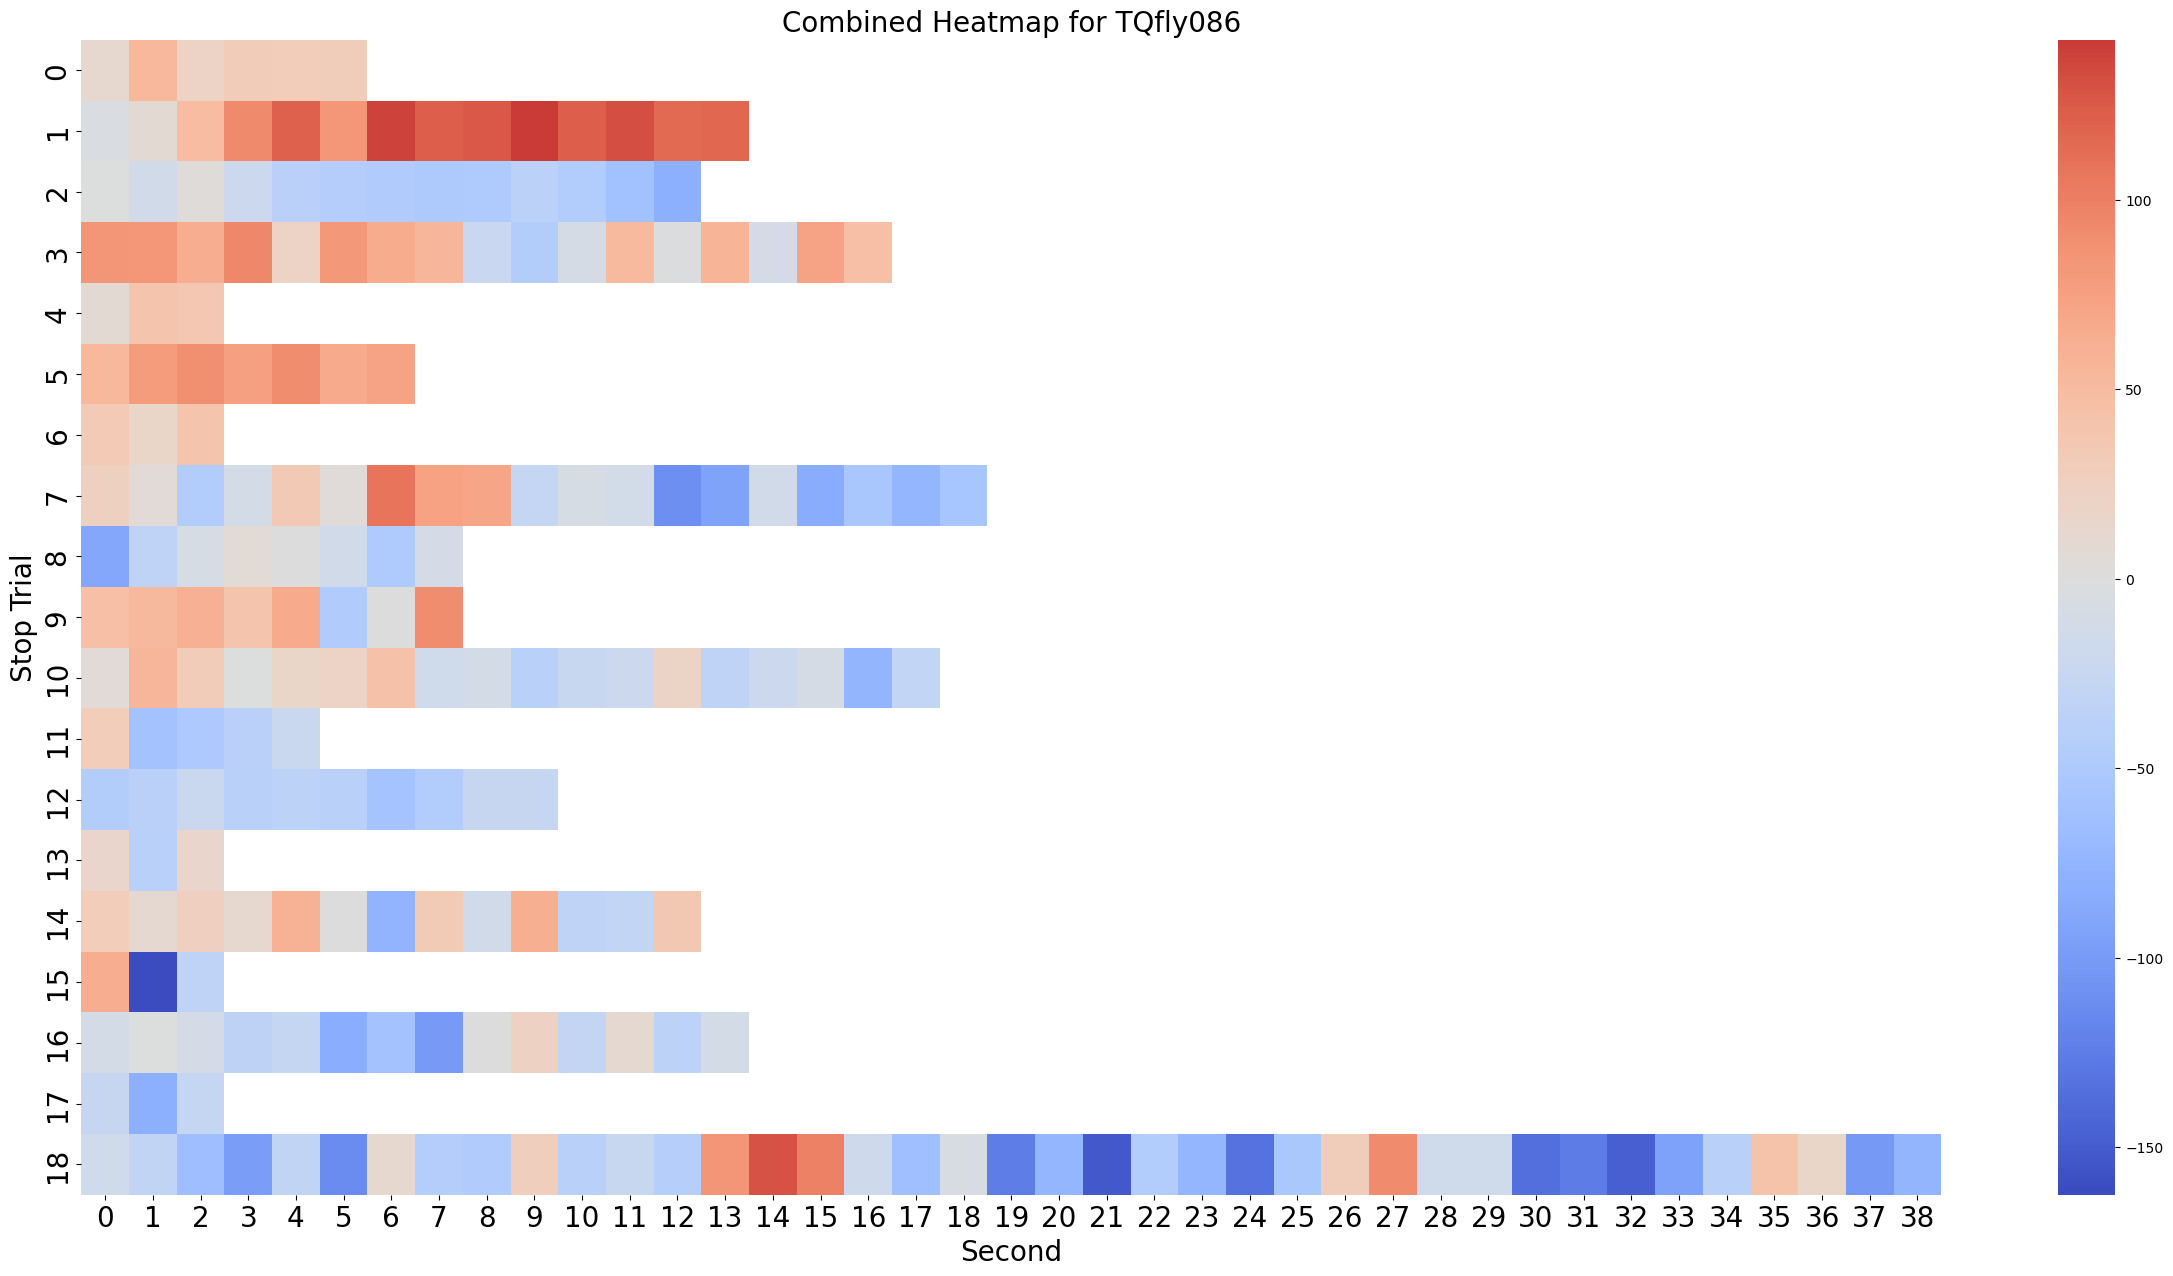

Plotting combined heatmap for experiment: TQfly078


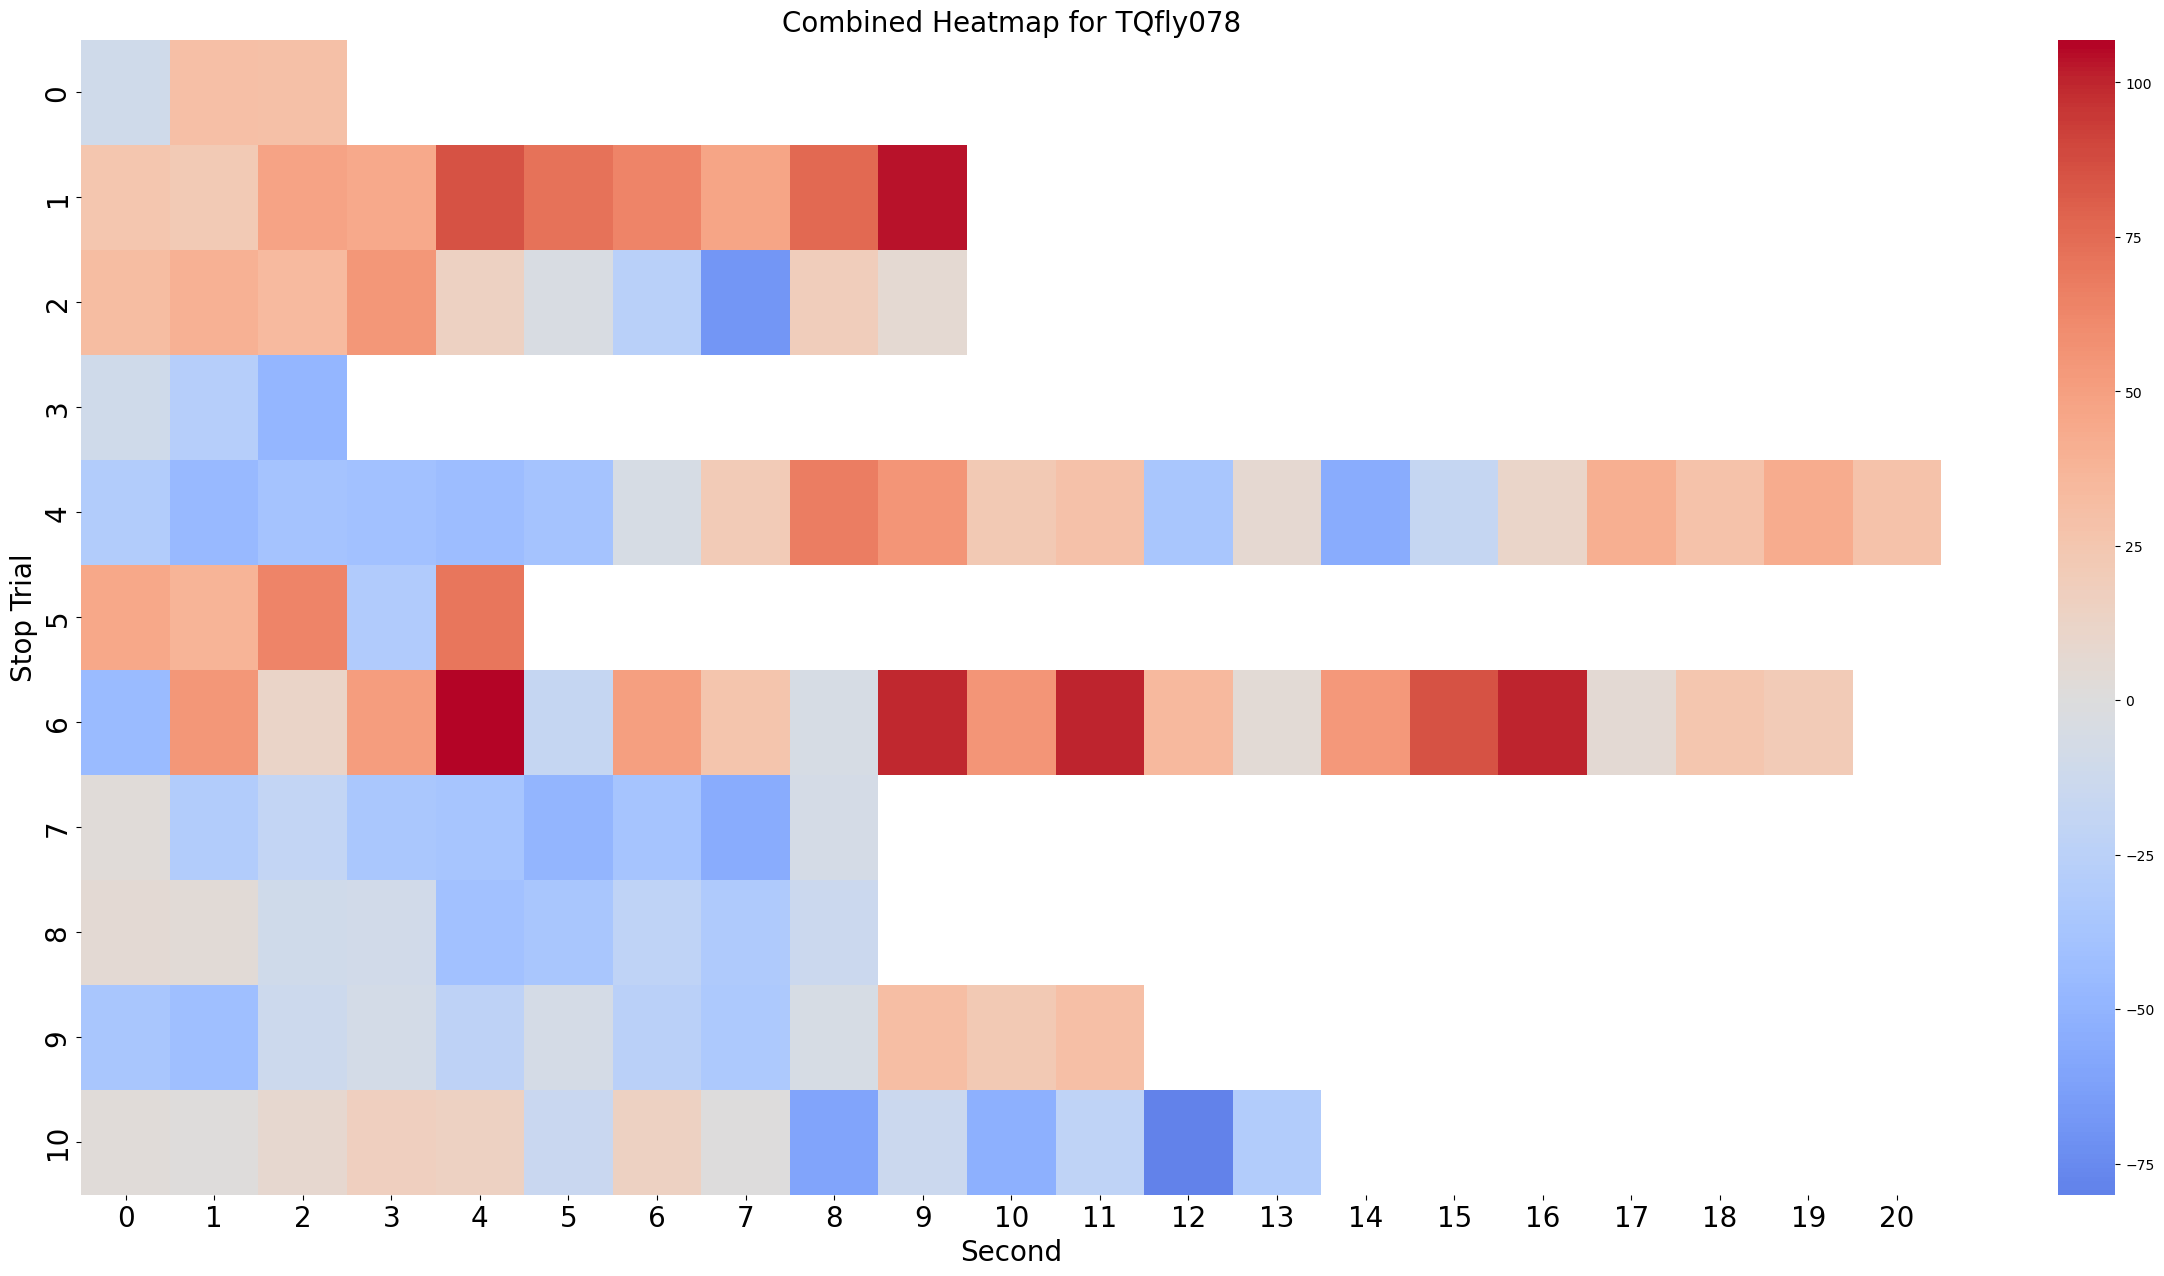

In [32]:
# Function to plot heatmap for combined trials of each experiment
def plot_heatmap(data, title):
    plt.figure(figsize=(30, 15))
    sns.heatmap(data, cmap="coolwarm", annot=False, center=0)
    plt.title(title, fontsize=20)
    plt.xlabel('Second', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Stop Trial', fontsize=20)
    plt.show()

# Loop through each experiment and its trials
for key, trials in data_all['output_second_wise_bump_dwell_difference'].items():
    print(f"Plotting combined heatmap for experiment: {key}")
    combined_data = []
    
    for trial in trials:
        # Flatten the nested lists for each trial
        trial_data = []
        for array in trial:
              if len(array) > 0:  # Check if the array is not empty
                    trial_data.append(array)
        if len(trial_data) > 0: 
            # Find the maximum length of the arrays for padding
            max_length = max(len(arr) for arr in trial_data)

            # Pad arrays to have the same length with NaN
            padded_data = np.array([np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=np.nan) for arr in trial_data])

            # Append padded data to combined_data
            combined_data.extend(padded_data)
    
    # Convert the combined data to a DataFrame
    df = pd.DataFrame(combined_data)

    # Plot heatmap for combined trials
    plot_heatmap(df, f'Combined Heatmap for {key}')
    # Plot heatmap for each trial
    #plot_heatmap(df, f'Heatmap for {key} - Trial {i+1}')


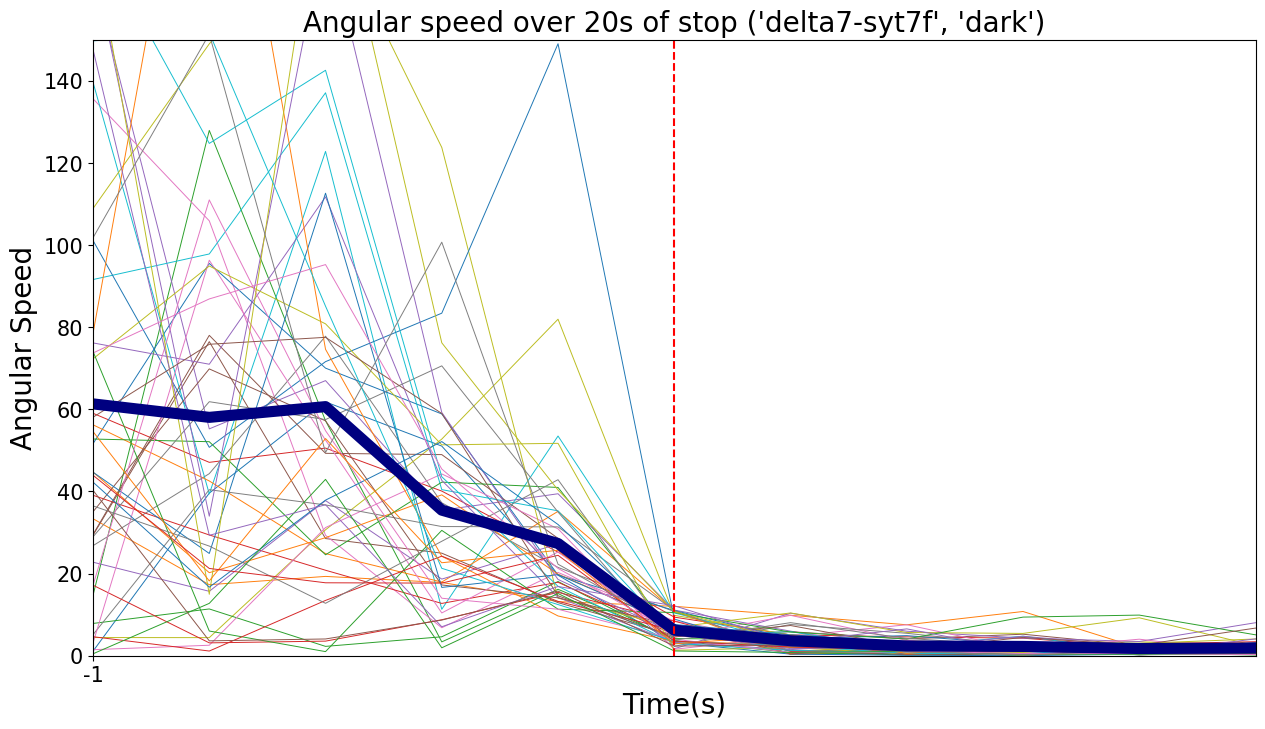

In [41]:
time_array_decay = np.arange(len(data_all['output_Angular_Speed_pooled'].mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(data_all['output_Angular_Speed_pooled'].columns)):
    plt.plot(time_array_decay,data_all['output_Angular_Speed_pooled'][i],linewidth = 0.7)
plt.plot(time_array_decay,data_all['output_Angular_Speed_pooled'].mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,2)
plt.ylim(0,150)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Angular Speed', fontsize=20)
plt.title(f"Angular speed over {bump_amplitude_stopping_duration}s of stop {celltype, trial_condition}",fontsize =20)
plt.show()


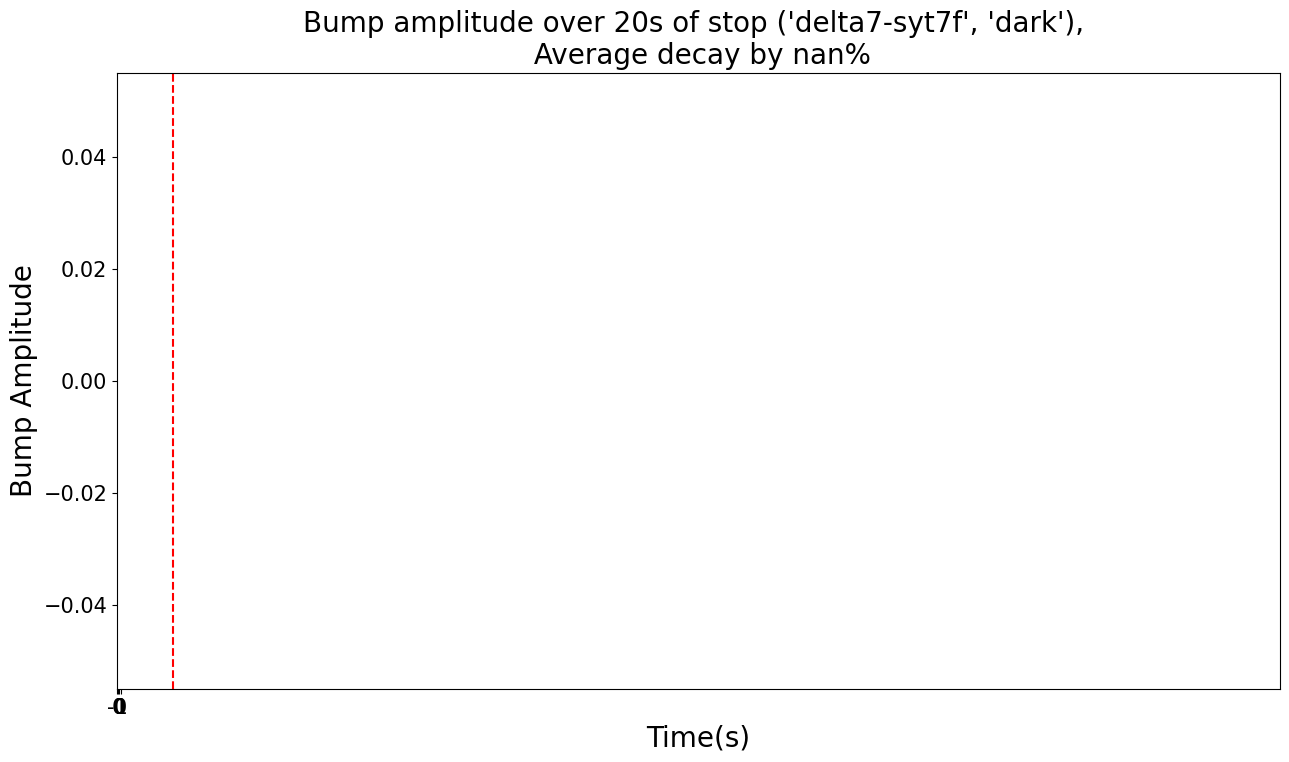

In [13]:
plot_stopping_period_signal(data_all['output_bump_amplitude_V3_pooled'],stopping_bin_size_s=bump_amplitude_stopping_bin_size,decay_start_from_exact_stop=1,decay_length_s=bump_amplitude_stopping_duration ,active_period_length_s=active_period_before_len,run_spline_fit=False,celltype=celltype, trial_condition=trial_condition)

In [13]:
if dual_imaging == 1:
    plot_stopping_period_signal(data_all['output_bump_amplitude_V4_pooled_red'],stopping_bin_size_s=bump_amplitude_stopping_bin_size,decay_start_from_exact_stop=1,decay_length_s=bump_amplitude_stopping_duration ,active_period_length_s=active_period_before_len,run_spline_fit=False,celltype=celltype, trial_condition=trial_condition)

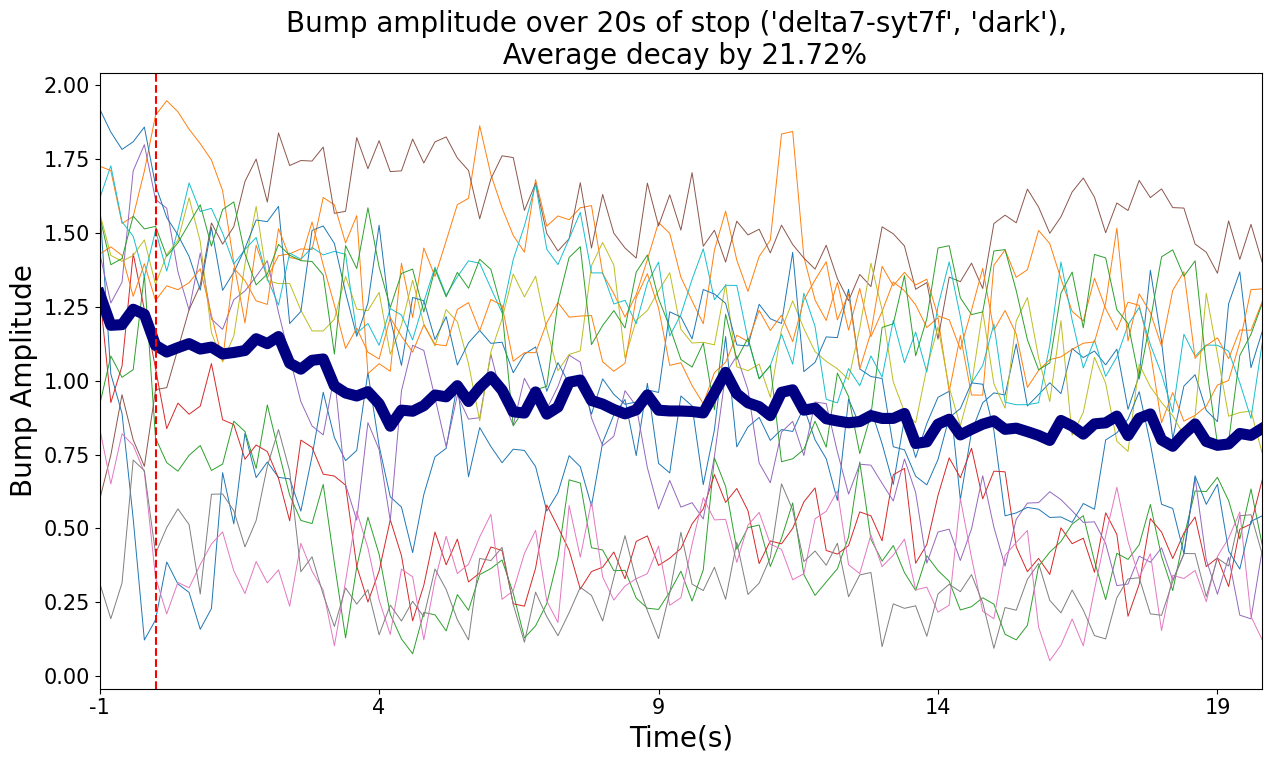

In [14]:
plot_stopping_period_signal(data_all['output_PVA_strength_pooled'] ,stopping_bin_size_s=bump_amplitude_stopping_bin_size,decay_start_from_exact_stop=1,decay_length_s=bump_amplitude_stopping_duration ,active_period_length_s=active_period_before_len,run_spline_fit=False,celltype=celltype, trial_condition=trial_condition)

In [17]:
fly_list = np.array(list(set(data_all['output_flytrial'])))

In [13]:
Bump_amp_V3_stable = pd.DataFrame()
Bump_amp_V3_unstable = pd.DataFrame()
for i in range(len(data_all['output_stable_PVA_index_pooled'])):
    if data_all['output_stable_PVA_index_pooled'][i] == 0:
        if i == 0:
            Bump_amp_V3_unstable = data_all['output_bump_amplitude_V3_pooled'][i]
        else:
            Bump_amp_V3_unstable = pd.concat([Bump_amp_V3_unstable,data_all['output_bump_amplitude_V3_pooled'][i]],ignore_index=True, axis =1)
    else:
        if i == 0:
            Bump_amp_V3_stable =data_all['output_bump_amplitude_V3_pooled'][i]
        else:
            Bump_amp_V3_stable = pd.concat([Bump_amp_V3_stable,data_all['output_bump_amplitude_V3_pooled'][i]],ignore_index=True, axis =1)          

In [14]:
output_bump_amplitude_V4_pooled_average_by_fly = calculate_stop_signal_in_separate_fly(output_bump_amplitude_V4_pooled,flylist = fly_list,trial_list=output_flytrial,stability_list=output_stable_PVA_index_pooled, separate_stableY_N=0)

NameError: name 'output_bump_amplitude_V4_pooled' is not defined

In [16]:
#output_bump_amplitude_V3_pooled_average_by_fly.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/data/dark_average_by_fly/output_bump_amplitude_V3_pooled_averagebyfly_delta7_iGlu_PB_cl.csv',encoding = 'utf-8', index=False)
#output_bump_amplitude_V4_pooled_average_by_fly.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/data/dark_average_by_fly/output_bump_amplitude_V4_pooled_averagebyfly_delta7_iGlu_PB_cl.csv',encoding = 'utf-8', index=False)

ValueError: x and y must have same first dimension, but have shapes (55,) and (105,)

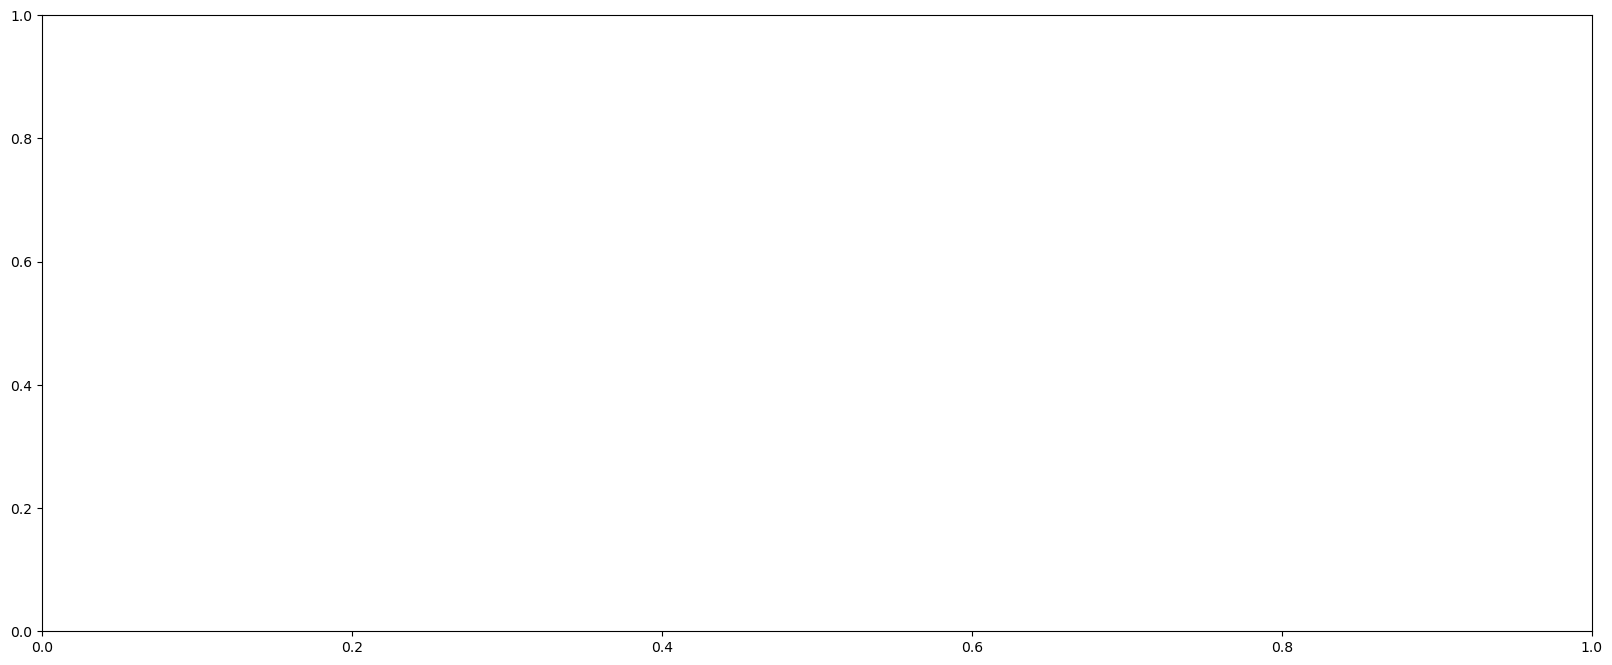

In [13]:
pooled_decay_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/darkcl imaging bump decay/decay curve/Average_Bump_amplitude_V4_decay_20s _syt7f_only.csv')
new_column_names = [0,1,2,3,4,5,6]
pooled_decay_df.columns = new_column_names
palette = sns.color_palette("tab20b_r", len(pooled_decay_df.columns))

a =plt.figure(figsize=(20, 8))

for i in range(len(pooled_decay_df.columns)):
    if i >= 5:
        plt.plot(time_array_decay, gaussian_filter1d(pooled_decay_df[i], sigma=3), linewidth=5, color=palette[i])
    else:
        plt.plot(time_array_decay, gaussian_filter1d(pooled_decay_df[i],sigma=3), linewidth=5, color=palette[i])


# Add custom labels and legend
custom_labels = ['E-PG-PB', 'E-PG-EB', 'P-EG-EB', 'PFNd-FB','P-EN2-EB', 'delta7-PB','delta7-iGlu']
plt.legend(custom_labels, fontsize=15)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,bump_amplitude_stopping_duration+0.8)
plt.axvline(x= 1, color = 'r',linestyle ='--',linewidth=2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Amplitude', fontsize=25)
plt.title(f"Average bump amplitude decay over {bump_amplitude_stopping_duration}s of stop",fontsize =30)
plt.show()
#a.savefig('Bump_abplitude_V4_dark_20s_syt7f', format ='svg')

In [49]:
data_all['output_df_pooled'].columns

Index(['FlyTrial', 'Genotype', 'TrialType', 'Period_duration',
       'PVA_before_stop', 'PVA_at_restart', 'PVA_100ms_before_restart',
       'PVA_500ms_before_restart', 'PVA_in_middle', 'PVA_2s_before_restart',
       'PVA_3s_after_stop', 'PVA_5s_after_stop', 'PVA_10s_after_stop',
       'PVA_20s_after_stop', 'PVA_35s_after_stop', 'PVA_60s_after_stop',
       'PVA_angle_drift_per_second', 'PVA_angle_drift_per_second_2',
       'forward_speed_before_stop', 'forward_speed_at_restart',
       'forward_speed_100ms_before_restart',
       'forward_speed_500ms_before_restart', 'forward_speed_in_middle',
       'forward_speed_2s_before_restart', 'forward_speed_3s_after_stop',
       'forward_speed_5s_after_stop', 'forward_speed_10s_after_stop',
       'forward_speed_20s_after_stop', 'forward_speed_35s_after_stop',
       'bump_amplitude_before_stop', 'bump_amplitude_at_restart',
       'bump_amplitude_100ms_before_restart',
       'bump_amplitude_500ms_before_restart', 'bump_amplitude_in_mid

In [50]:
data_all['output_df_pooled']['FlyTrialGroup'] = data_all['output_df_pooled']['FlyTrial'].apply(lambda x: x.split('-')[0])

In [51]:
data_all['output_df_pooled']['angle difference start/5s'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled']['PVA_before_stop'],data_all['output_df_pooled']['PVA_5s_after_stop']))
data_all['output_df_pooled']['angle difference start/10s'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled']['PVA_before_stop'],data_all['output_df_pooled']['PVA_10s_after_stop']))
data_all['output_df_pooled']['angle difference start/20s'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled']['PVA_before_stop'],data_all['output_df_pooled']['PVA_20s_after_stop']))
data_all['output_df_pooled']['angle difference start/restart'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled']['PVA_before_stop'],data_all['output_df_pooled']['PVA_at_restart']))

if dual_imaging == 1:
    data_all['output_df_pooled_red']['angle difference start/5s'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled_red']['PVA_before_stop'],data_all['output_df_pooled_red']['PVA_5s_after_stop']))
    data_all['output_df_pooled_red']['angle difference start/10s'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled_red']['PVA_before_stop'],data_all['output_df_pooled_red']['PVA_10s_after_stop']))
    data_all['output_df_pooled_red']['angle difference start/restart'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled_red']['PVA_before_stop'],data_all['output_df_pooled_red']['PVA_at_restart']))

(array([56., 34., 14., 13., 10.,  4.,  5.,  0.,  2.,  1.]),
 array([  3.67987458,  17.8284588 ,  31.97704301,  46.12562723,
         60.27421144,  74.42279566,  88.57137987, 102.71996409,
        116.86854831, 131.01713252, 145.16571674]),
 <BarContainer object of 10 artists>)

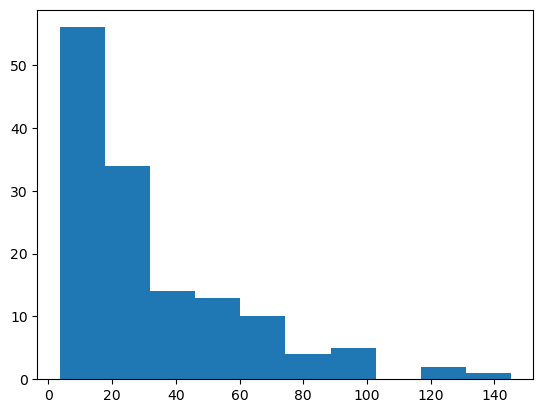

In [52]:
plt.hist(data_all['output_df_pooled']['PVA_angle_drift_per_second'])

(array([35., 55., 17.,  9.,  8.,  6.,  3.,  3.,  2.,  1.]),
 array([ 1.42656026,  4.49089554,  7.55523081, 10.61956609, 13.68390137,
        16.74823665, 19.81257192, 22.8769072 , 25.94124248, 29.00557776,
        32.06991303]),
 <BarContainer object of 10 artists>)

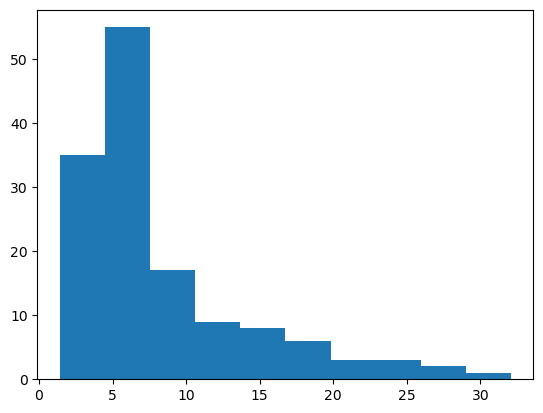

In [53]:
plt.hist(data_all['output_df_pooled']['PVA_angle_drift_per_second_2'])

In [54]:
np.mean(data_all['output_df_pooled']['PVA_angle_drift_per_second'])

32.47703018215184

In [55]:
np.mean(data_all['output_df_pooled']['PVA_angle_drift_per_second_2'])

8.259373157769977

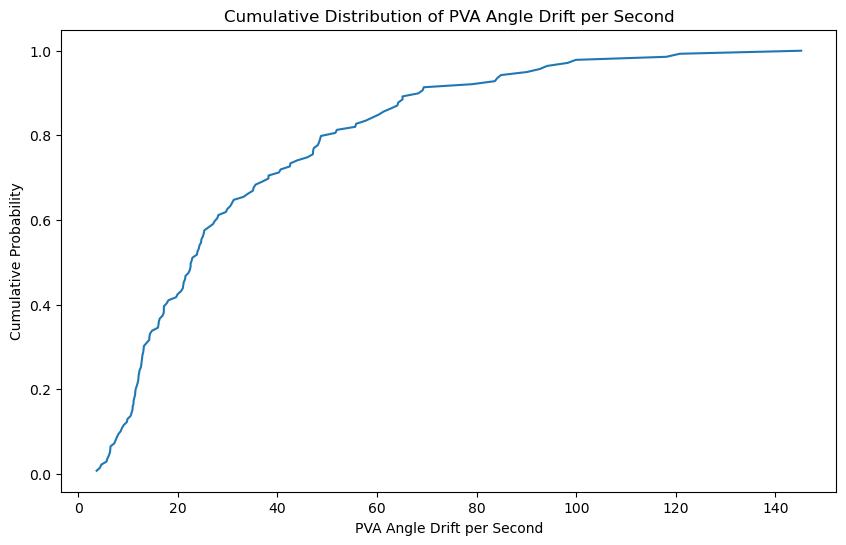

In [56]:
# Extract the series
accumulate_data = data_all['output_df_pooled']['PVA_angle_drift_per_second']

# Sort the data
accumulate_data_sort = np.sort(accumulate_data)

# Compute the cumulative distribution
cdf = np.arange(1, len(accumulate_data_sort) + 1) / len(accumulate_data_sort)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(accumulate_data_sort, cdf)
plt.title('Cumulative Distribution of PVA Angle Drift per Second')
plt.xlabel('PVA Angle Drift per Second')
plt.ylabel('Cumulative Probability')
plt.show()

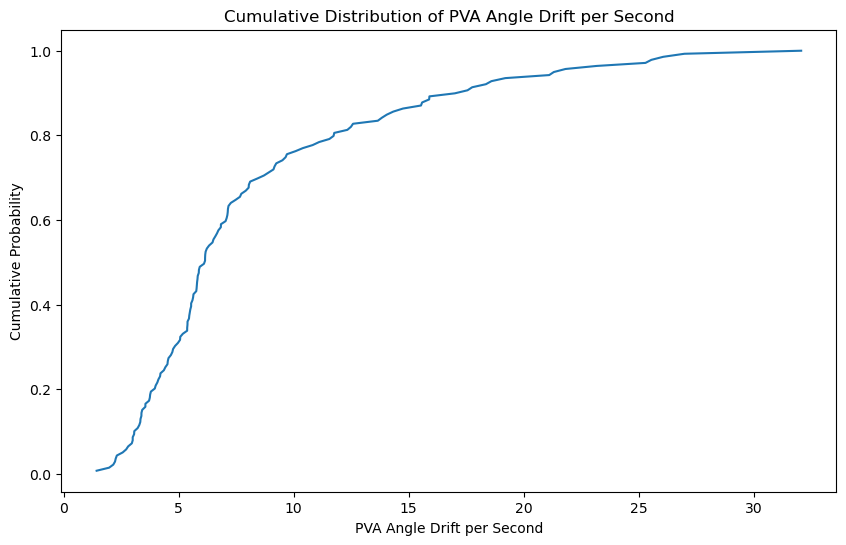

In [57]:
# Extract the series
accumulate_data = data_all['output_df_pooled']['PVA_angle_drift_per_second_2']

# Sort the data
accumulate_data_sort = np.sort(accumulate_data)

# Compute the cumulative distribution
cdf = np.arange(1, len(accumulate_data_sort) + 1) / len(accumulate_data_sort)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(accumulate_data_sort, cdf)
plt.title('Cumulative Distribution of PVA Angle Drift per Second')
plt.xlabel('PVA Angle Drift per Second')
plt.ylabel('Cumulative Probability')
plt.show()

In [58]:
data_all['output_df_pooled']['PVA_angle_drift_per_second'].shape

(139,)

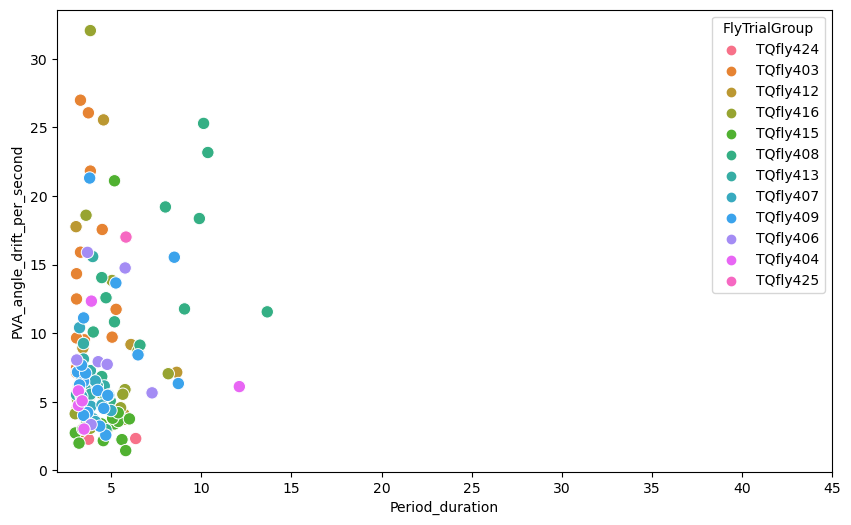

In [59]:
# Create kdeplot (density plot)
plt.figure(figsize=(10, 6))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data=data_all['output_df_pooled'], x='Period_duration', y='PVA_angle_drift_per_second_2',  s =80,hue = 'FlyTrialGroup')
plt.ylabel('PVA_angle_drift_per_second')
plt.xlim(2,45)
plt.show()

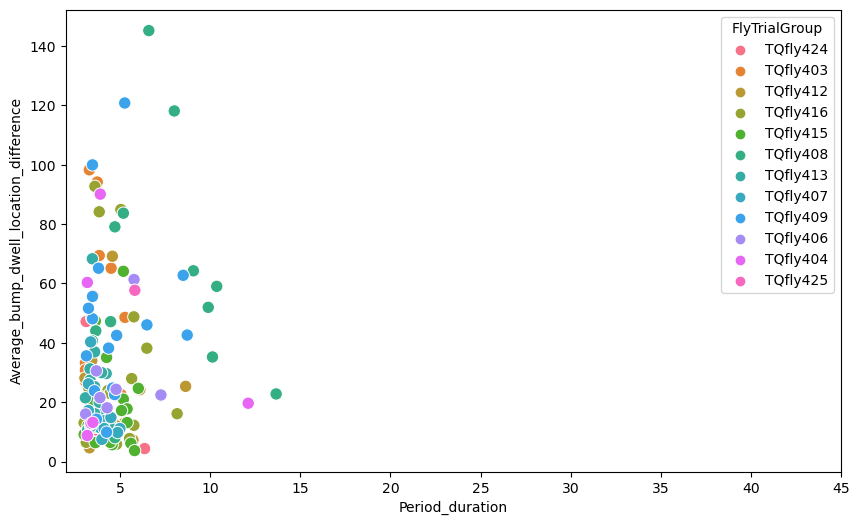

In [60]:
# Create kdeplot (density plot)
plt.figure(figsize=(10, 6))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data=data_all['output_df_pooled'], x='Period_duration', y='PVA_angle_drift_per_second',  s =80,hue = 'FlyTrialGroup')
plt.ylabel('Average_bump_dwell_location_difference')
plt.xlim(2,45)
plt.show()

Pearson correlation coefficient: 0.65, p-value: 2.59e-18


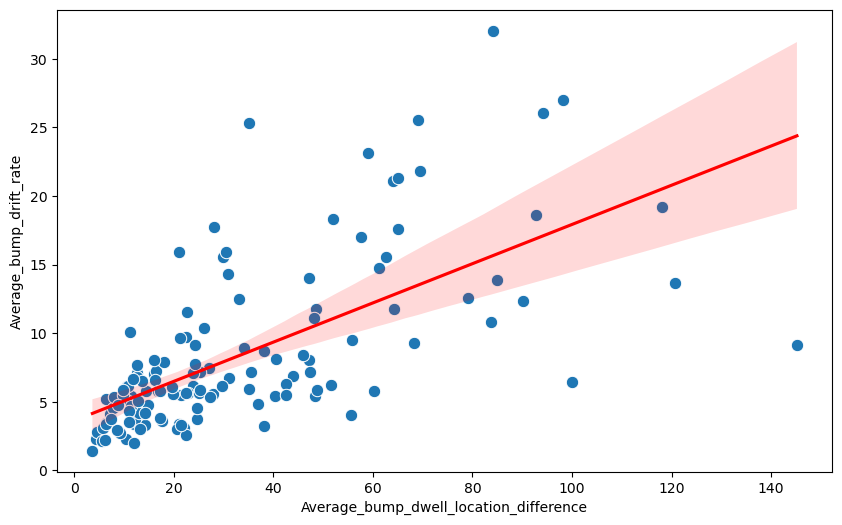

In [61]:
# Create kdeplot (density plot)
plt.figure(figsize=(10, 6))
corr_coef, p_value = pearsonr(data_all['output_df_pooled']['PVA_angle_drift_per_second'], data_all['output_df_pooled']['PVA_angle_drift_per_second_2'])
print(f"Pearson correlation coefficient: {corr_coef:.2f}, p-value: {p_value:.2e}")
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data=data_all['output_df_pooled'], x='PVA_angle_drift_per_second', y='PVA_angle_drift_per_second_2',  s =80)
# Add regression line
sns.regplot(data=data_all['output_df_pooled'], x='PVA_angle_drift_per_second', y='PVA_angle_drift_per_second_2', scatter=False, color='r')
plt.xlabel('Average_bump_dwell_location_difference')
plt.ylabel('Average_bump_drift_rate')
#plt.xlim(2,25)
plt.show()

In [28]:
data_all['output_df_pooled'].to_csv('/home/tianhaoqiu/Pictures/Screenshots/output_signal_at_stop_point_EPG_7b_PB_delta7_attp40_cl.csv',encoding = 'utf-8', index=False)

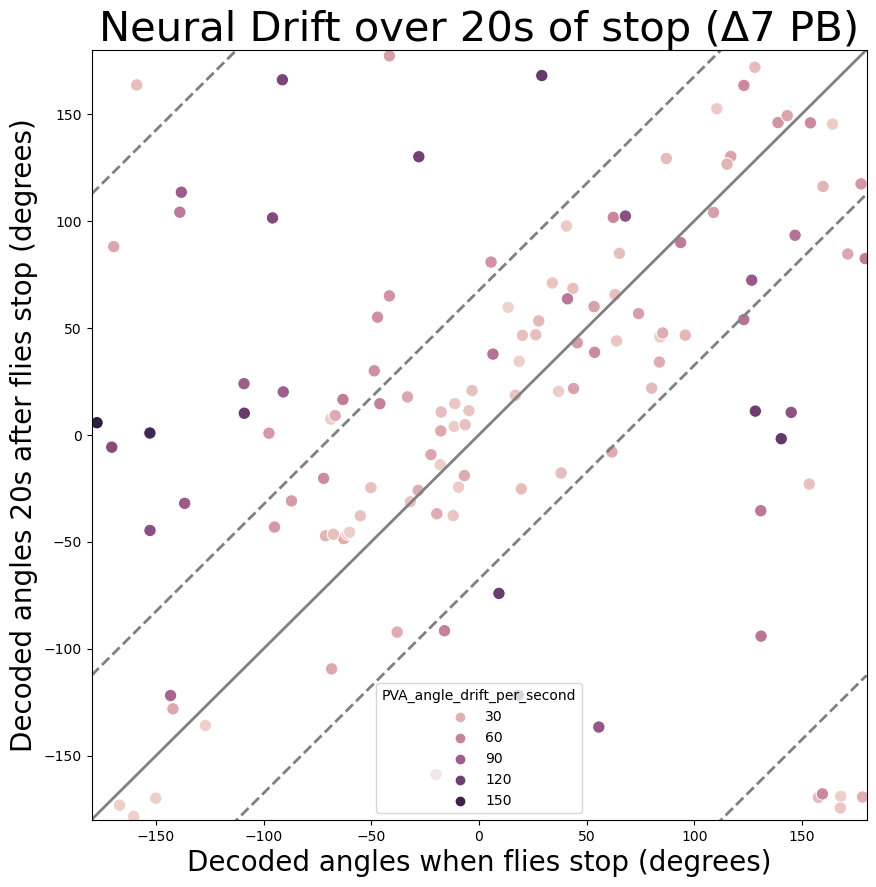

In [42]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = data_all['output_df_pooled'], x='PVA_before_stop', y='PVA_at_restart', s =80, hue = 'PVA_angle_drift_per_second')
#snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
#snsplot = sns.scatterplot(data = output_df_pooled, x='PVA_before_stop', y='PVA_20s_after_stop', hue = 'bump_amplitude_before_stop', s =80)
#snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural Drift over 20s of stop (Δ7 PB)', fontsize =30)
plt.ylabel('Decoded angles 20s after flies stop (degrees)',fontsize= 20)
plt.xlabel('Decoded angles when flies stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
#plt.grid()
plt.show()
#a.savefig('Δ7_syt7f_PB_Bump_Angle_20s_after_dark_no_hue', format ='svg')

In [43]:
if dual_imaging == 1:
    a = plt.figure(figsize= (10,10))
    cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
    snsplot = sns.scatterplot(data = data_all['output_df_pooled_red'], x='PVA_before_stop', y='PVA_20s_after_stop', s =80)
    #snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
    #snsplot = sns.scatterplot(data = output_df_pooled, x='PVA_before_stop', y='PVA_20s_after_stop', hue = 'bump_amplitude_before_stop', s =80)
    #snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
    X_plot = np.linspace(-180, 180, 100)
    Y_plot = X_plot
    plt.plot(X_plot,Y_plot, color='grey', linewidth =2)
    plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =2)
    plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =2)
    plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =2)
    plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =2)
    plt.ylim(-180, 180)
    plt.xlim(-180, 180)
    plt.title('Neural Drift over 20s of stop (Δ7 PB)', fontsize =30)
    plt.ylabel('Decoded angles 20s after flies stop (degrees)',fontsize= 20)
    plt.xlabel('Decoded angles when flies stop (degrees)',fontsize= 20)
    #plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
    #plt.grid()
    plt.show()

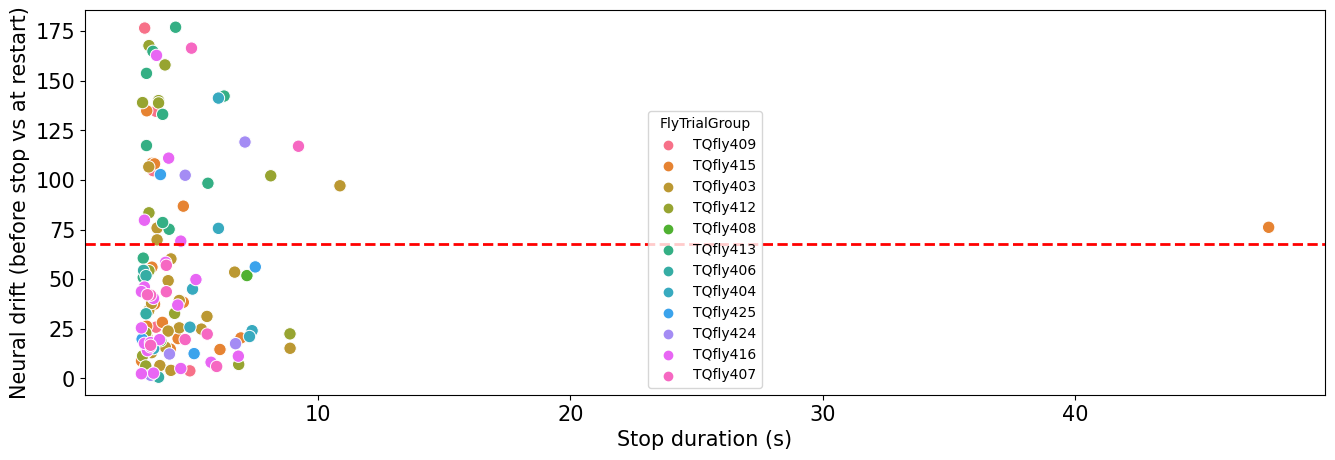

In [44]:
#filtered_data =data_all['output_df_pooled']['Period_duration'] >= 10]
filtered_data = data_all['output_df_pooled']
a = plt.figure(figsize= (16,5))
snsplot = sns.scatterplot(data = filtered_data , x='Period_duration', y='angle difference start/restart', s =80, hue = 'FlyTrialGroup')
plt.ylabel('Neural drift (before stop vs at restart)',fontsize= 15)
plt.xlabel('Stop duration (s)',fontsize= 15)
plt.axhline(y= 67.5, color = 'r',linestyle ='--',linewidth=2)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()
#a.savefig('Δ7_syt7f_EB_Bump_Angle_difference_10s_at_least_dark', format ='svg')

In [32]:
data_all['output_df_pooled']

FlyTrial     Genotype TrialType  Period_duration  PVA_before_stop   
0    TQfly329-003  R55G08>iGlu      dark         14.21970        21.542379  \
1    TQfly329-003  R55G08>iGlu      dark          8.44564       134.506850   
2    TQfly329-003  R55G08>iGlu      dark          3.70574      -117.454607   
3    TQfly329-003  R55G08>iGlu      dark          3.87810      -119.259228   
4    TQfly329-003  R55G08>iGlu      dark          4.22282        43.119454   
..            ...          ...       ...              ...              ...   
298  TQfly337-003  R55G08>iGlu      dark         38.57320      -155.095997   
299  TQfly337-003  R55G08>iGlu      dark          7.92600        79.020876   
300  TQfly337-003  R55G08>iGlu      dark          6.23512        -8.567911   
301  TQfly337-003  R55G08>iGlu      dark          3.06472        29.595211   
302  TQfly337-003  R55G08>iGlu      dark          6.55216       -37.147316   

     PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart   
0         44.665195                 63.098209                 40.780309  \
1        141.472654                147.016550                146.387009   
2       -129.696847               -130.972819               -121.969230   
3       -123.126728               -121.406991               -122.986539   
4         25.207487                 31.767872                 27.896015   
..              ...                       ...                       ...   
298     -130.997372               -124.063197               -139.686861   
299       95.579627                 97.424104                 77.713658   
300       -8.504833                -12.477722                 -9.702049   
301        0.222200                  6.842487                 20.914962   
302      -57.230278                -57.666054                -56.353914   

     PVA_in_middle  PVA_2s_before_restart  ...   
0        36.246078              49.204478  ...  \
1       140.311358             145.915253  ...   
2      -116.840683            -120.817764  ...   
3      -122.067600            -125.695197  ...   
4        36.466577              36.298673  ...   
..             ...                    ...  ...   
298    -141.671851            -147.484378  ...   
299      87.433103              87.525781  ...   
300     -12.327586             -15.951382  ...   
301      19.184874              29.010683  ...   
302     -47.809978             -56.008672  ...   

     PVA_strength_2s_before_restart  PVA_strength_3s_after_stop   
0                          1.367390                    1.082697  \
1                          1.717458                    1.763333   
2                          1.830370                    1.893956   
3                          2.056226                    1.691741   
4                          1.149864                    1.006205   
..                              ...                         ...   
298                        0.724766                    1.464149   
299                        1.099808                    1.354244   
300                        1.922232                    1.805794   
301                        1.765985                    1.548542   
302                        1.725346                    1.530862   

     PVA_strength_5s_after_stop  PVA_strength_10s_after_stop   
0                      1.344769                     1.073758  \
1                      1.653239                          NaN   
2                           NaN                          NaN   
3                           NaN                          NaN   
4                           NaN                          NaN   
..                          ...                          ...   
298                    1.442888                     1.028169   
299                    1.173266                          NaN   
300                    1.992313                          NaN   
301                         NaN                          NaN   
302                    2.098930                          NaN 

In [20]:
if dual_imaging == 1:
    filtered_data_red = data_all['output_df_pooled_red'][data_all['output_df_pooled_red']['Period_duration'] >= 10]
    a = plt.figure(figsize= (16,5))
    snsplot = sns.scatterplot(data = filtered_data_red , x='Period_duration', y='angle difference start/restart', s =80)
    plt.ylabel('Neural drift (before stop vs at restart)',fontsize= 15)
    plt.xlabel('Stop duration (s)',fontsize= 15)
    plt.axhline(y= 67.5, color = 'r',linestyle ='--',linewidth=2)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.show()

(array([24., 25., 14., 17., 11., 16., 11., 11.,  7.]),
 array([  1.084621  ,  20.8532056 ,  40.6217902 ,  60.39037481,
         80.15895941,  99.92754401, 119.69612861, 139.46471322,
        159.23329782, 179.00188242]),
 <BarContainer object of 9 artists>)

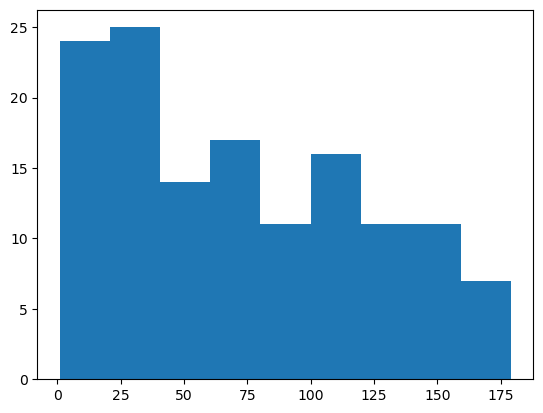

In [21]:
plt.hist(filtered_data['angle difference start/restart'] ,bins='auto')
#plt.hist(filtered_data_red['angle difference start/restart'] ,bins='auto')

In [33]:
# Count the number of values larger than 22.5 in the column 'angle difference start/restart'
num_values_larger_than_22_5 = (filtered_data['angle difference start/20s'] <= 22.5).sum()

print("Number of values larger than 22.5:", num_values_larger_than_22_5)

Number of values larger than 22.5: 0


In [34]:
# Count the number of non-NaN values in the column 'angle difference start/20s'
num_non_nan_values = filtered_data['angle difference start/20s'].notna().sum()

print("Number of non-NaN values:", num_non_nan_values)

Number of non-NaN values: 3


In [35]:
num_non_nan_values = filtered_data['angle difference start/restart'].notna().sum()

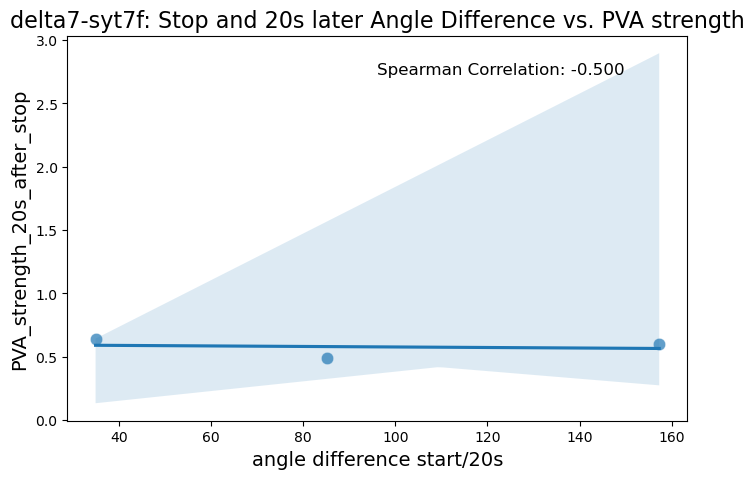

In [39]:
from matplotlib.cm import ScalarMappable


output_df_pooled_cleaned = data_all['output_df_pooled'].dropna(subset=['angle difference start/20s', 'PVA_strength_20s_after_stop'])
# Create a scatter plot with the 'viridis' colormap
plt.figure(figsize=(8, 5))
scatter = sns.scatterplot(
    data=output_df_pooled_cleaned,
    x='angle difference start/20s',
    y='PVA_strength_20s_after_stop',
    s=80,
    #cmap='plasma',
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

# Customize labels and title
plt.xlabel('Angle Difference (start vs 20s)', fontsize=14)
plt.ylabel('PVA strength 20s After Stop', fontsize=14)
plt.title(f'{celltype}: Stop and 20s later Angle Difference vs. PVA strength', fontsize=16)


# Fit a linear regression model
regression_model = LinearRegression()
X = output_df_pooled_cleaned[['angle difference start/20s']]
y = output_df_pooled_cleaned['PVA_strength_20s_after_stop']
regression_model.fit(X, y)

sns.regplot(
    x='angle difference start/20s',
    y='PVA_strength_20s_after_stop',
    data=output_df_pooled_cleaned,
    scatter=False,  # To remove individual data points from the regression plot
    ax=scatter.axes  # Use the same axes as the scatter plot
)


# Get R-squared value
y_pred = regression_model.predict(X)
r_squared = r2_score(y, y_pred)

# Display R-squared value on the plot
#plt.text(0.5, 0.95, f'R-squared: {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='center')


#Calculate Spearman correlation coefficient
spearman_corr, _ = spearmanr(output_df_pooled_cleaned['angle difference start/20s'], output_df_pooled_cleaned['PVA_strength_20s_after_stop'])
# Display Spearman correlation coefficient on the plot
plt.text(0.5, 0.9, f'Spearman Correlation: {spearman_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='left')


# Create a ScalarMappable for colorbar
sm = ScalarMappable(cmap='viridis')
sm.set_array([])  # You need to set an array for the ScalarMappable


# Show the plot
plt.show()

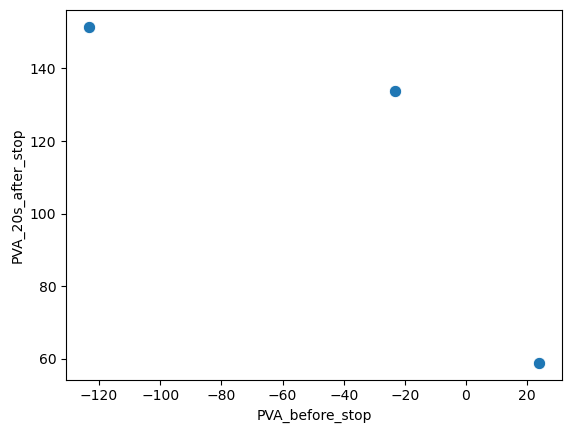

In [38]:
snsplot = sns.scatterplot(data = data_all['output_df_pooled'], x='PVA_before_stop', y='PVA_20s_after_stop', s =80)

NameError: name 'output_df_pooled' is not defined

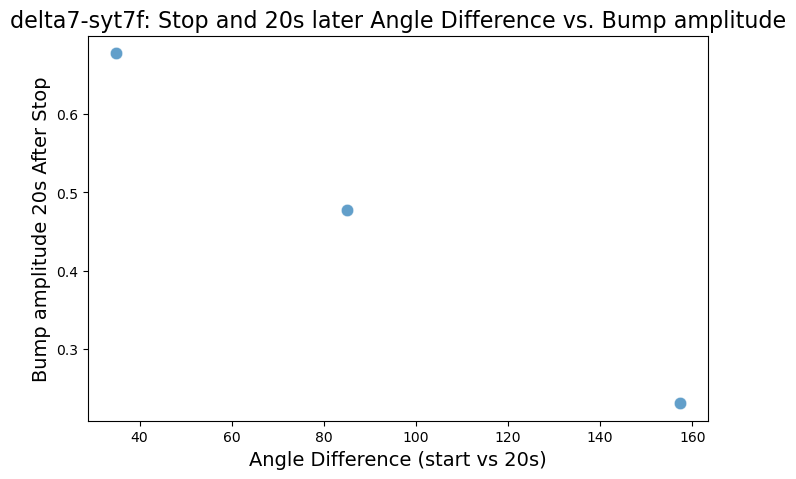

In [40]:
# Create a scatter plot with the 'viridis' colormap
output_df_pooled_cleaned = data_all['output_df_pooled'].dropna(subset=['angle difference start/20s', 'bump_amplitude_20s_after_stop'])
plt.figure(figsize=(8, 5))
scatter = sns.scatterplot(
    data=output_df_pooled_cleaned,
    x='angle difference start/20s',
    y='bump_amplitude_20s_after_stop',
    s=80,
    #cmap='plasma',
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

# Customize labels and title
plt.xlabel('Angle Difference (start vs 20s)', fontsize=14)
plt.ylabel('Bump amplitude 20s After Stop', fontsize=14)
plt.title(f'{celltype}: Stop and 20s later Angle Difference vs. Bump amplitude', fontsize=16)


# Fit a linear regression model
regression_model = LinearRegression()
X = output_df_pooled_cleaned[['angle difference start/20s']]
y = output_df_pooled_cleaned['bump_amplitude_20s_after_stop']
regression_model.fit(X, y)


sns.regplot(
    x='angle difference start/20s',
    y='bump_amplitude_20s_after_stop',
    data=output_df_pooled,
    scatter=False,  # To remove individual data points from the regression plot
    ax=scatter.axes  # Use the same axes as the scatter plot
)


# Get R-squared value
y_pred = regression_model.predict(X)
r_squared = r2_score(y, y_pred)

# Calculate Pearson correlation coefficient
spearman_corr, _ = spearmanr(output_df_pooled_cleaned['angle difference start/20s'], output_df_pooled_cleaned['bump_amplitude_20s_after_stop'])

# Display R-squared value on the plot
#plt.text(0.5, 0.95, f'R-squared: {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='center')

# Display Pearson correlation coefficient on the plot
plt.text(0.5, 0.9, f'Spearman Correlation: {spearman_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='left')

# Create a ScalarMappable for colorbar
sm = ScalarMappable(cmap='viridis')
sm.set_array([])  # You need to set an array for the ScalarMappable


# Show the plot
plt.show()

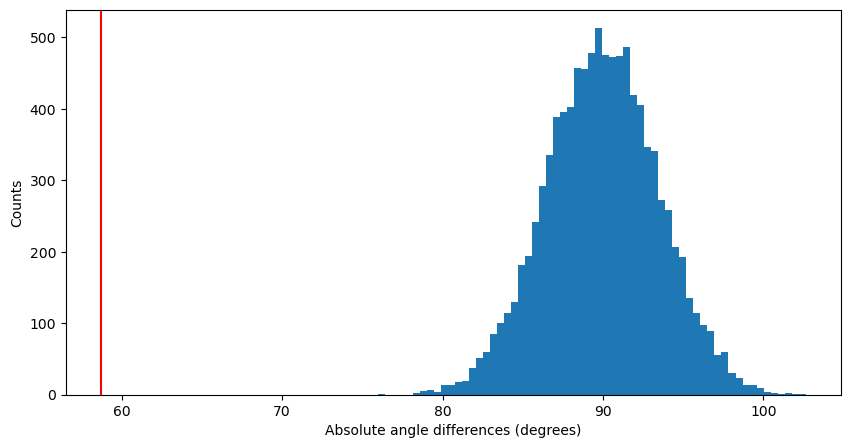

In [42]:
dark_stop_period_start_20s = np.zeros(len(np.argwhere(np.isnan(data_all['output_df_pooled']['PVA_at_restart'])==0)))
dark_stop_period_end_20s = np.zeros(len(np.argwhere(np.isnan(data_all['output_df_pooled']['PVA_at_restart'])==0))) 
long_trial_index = np.argwhere(np.isnan(data_all['output_df_pooled']['PVA_at_restart'])==0)
for i in range(len(dark_stop_period_start_20s )):
    dark_stop_period_start_20s[i] = data_all['output_df_pooled']['PVA_before_stop'][long_trial_index[i][0]]
    dark_stop_period_end_20s[i] =  data_all['output_df_pooled']['PVA_at_restart'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(dark_stop_period_start_20s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(dark_stop_period_start_20s,size = pair_num)
    random_stop_end_angle = np.random.choice(dark_stop_period_end_20s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_dark_diff =  calculate_angle_difference_between_two_time_point(dark_stop_period_start_20s ,dark_stop_period_end_20s)
actual_mean_absolute_angle_diff_dark = np.mean(np.abs(actual_mean_absolute_angle_diff_dark_diff))
actual_mean_absolute_angle_diff_dark     

a = plt.figure(figsize=(10, 5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff_dark, color = 'r')
plt.xlabel('Absolute angle differences (degrees)')
plt.ylabel('Counts')
plt.show()
#a.savefig('PEN-2_syt7f_EB_Shuffle_analysos_Bump_Angle_10s_after_dark', format ='svg')

In [43]:
#df = pd.DataFrame(bootstrap_mean_angle_differences_10000, columns=['Column_Name'])
#df.to_csv('/home/tianhaoqiu/a.csv',encoding = 'utf-8', index=False) 

In [45]:
len(np.argwhere(np.isnan(data_all['output_df_pooled']['PVA_60s_after_stop'])==0))

1

In [46]:
actual_mean_absolute_angle_diff_dark     

58.71134551869345

In [47]:
np.percentile(bootstrap_mean_angle_differences_10000, 0.038)

78.72402994869272

In [11]:
pooled_bump_amplitude_V4_allGenotypes_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/darkcl imaging bump decay/v4/pooled_bump_amplitude_v4.csv')

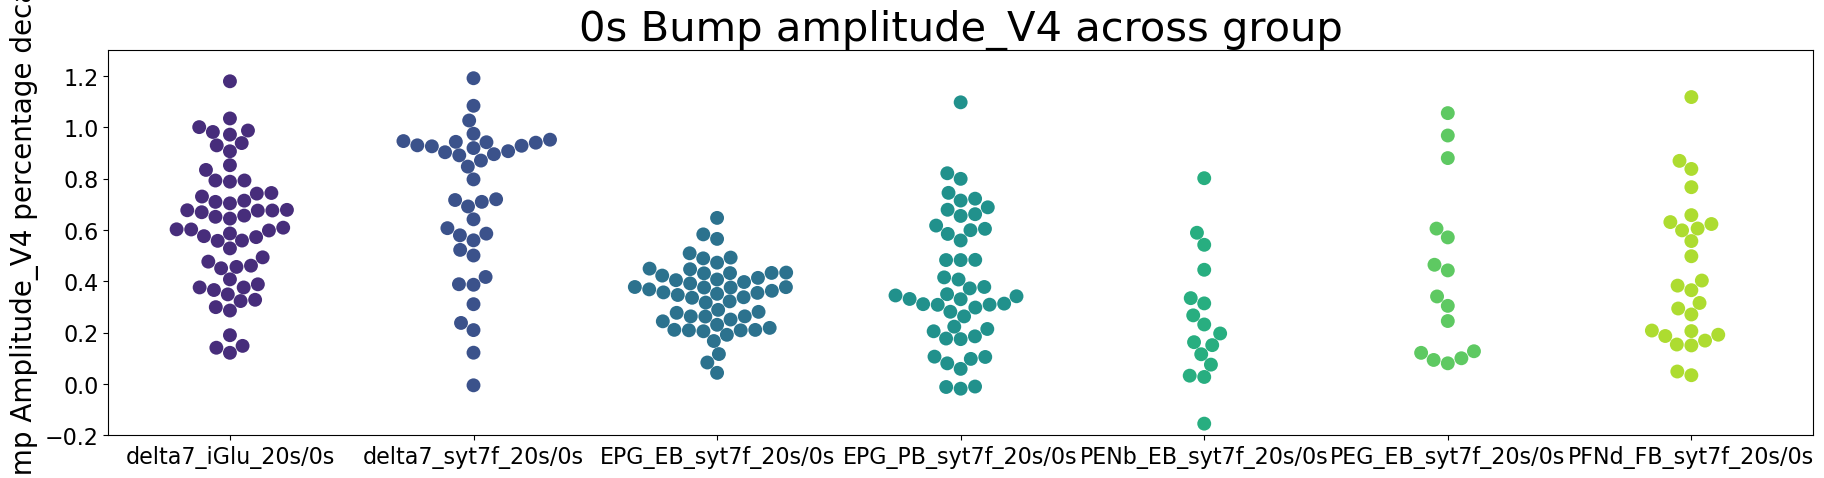

In [15]:

pooled_bump_amplitude_V4_allGenotypes_df

columns_to_plot_v4_percentage_20s = ['delta7_iGlu_20s/0s', 'delta7_syt7f_20s/0s','EPG_EB_syt7f_20s/0s','EPG_PB_syt7f_20s/0s', 'PENb_EB_syt7f_20s/0s', 'PEG_EB_syt7f_20s/0s','PFNd_FB_syt7f_20s/0s']


# Create a swarm plot
plt.figure(figsize=(22, 5))
sns.swarmplot(data=pooled_bump_amplitude_V4_allGenotypes_df[columns_to_plot_v4_percentage_20s ], palette='viridis', size=10)

plt.title('0s Bump amplitude_V4 across group', fontsize = 30)
plt.ylabel('Bump Amplitude_V4 percentage decat',fontsize =20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-0.2,1.3)
plt.show()

In [16]:
run_ANOVA_for_comparing_across_genotypes(pooled_bump_amplitude_V4_allGenotypes_df,columns_to_plot_v4_percentage_20s)

One-way ANOVA Result:
F-statistic: 13.962474353592452
p-value: 1.1188452538118769e-13
Adjusted df between: 6
Adjusted df within: 248
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
 EPG_EB_syt7f_20s/0s  EPG_PB_syt7f_20s/0s   0.0547 0.9298 -0.0942 0.2036  False
 EPG_EB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0869 0.9005 -0.1317 0.3054  False
 EPG_EB_syt7f_20s/0s PENb_EB_syt7f_20s/0s  -0.0815 0.9162 -0.2947 0.1317  False
 EPG_EB_syt7f_20s/0s PFNd_FB_syt7f_20s/0s   0.1274 0.3303 -0.0493 0.3041  False
 EPG_EB_syt7f_20s/0s   delta7_iGlu_20s/0s   0.2723    0.0  0.1297 0.4149   True
 EPG_EB_syt7f_20s/0s  delta7_syt7f_20s/0s   0.3708    0.0  0.2131 0.5285   True
 EPG_PB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0322 0.9995 -0.1889 0.2532  False
 EPG_PB_syt7f_20s/0s PENb_EB_syt7f_20s/0s  -0.1362 0.4973  -0.352 0

In [19]:
pooled_bump_amplitude_V4_allGenotypes_byfly_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/darkcl imaging bump decay/v4/pooled_bump_amplitude_v4_averagebyfly_dark.csv')

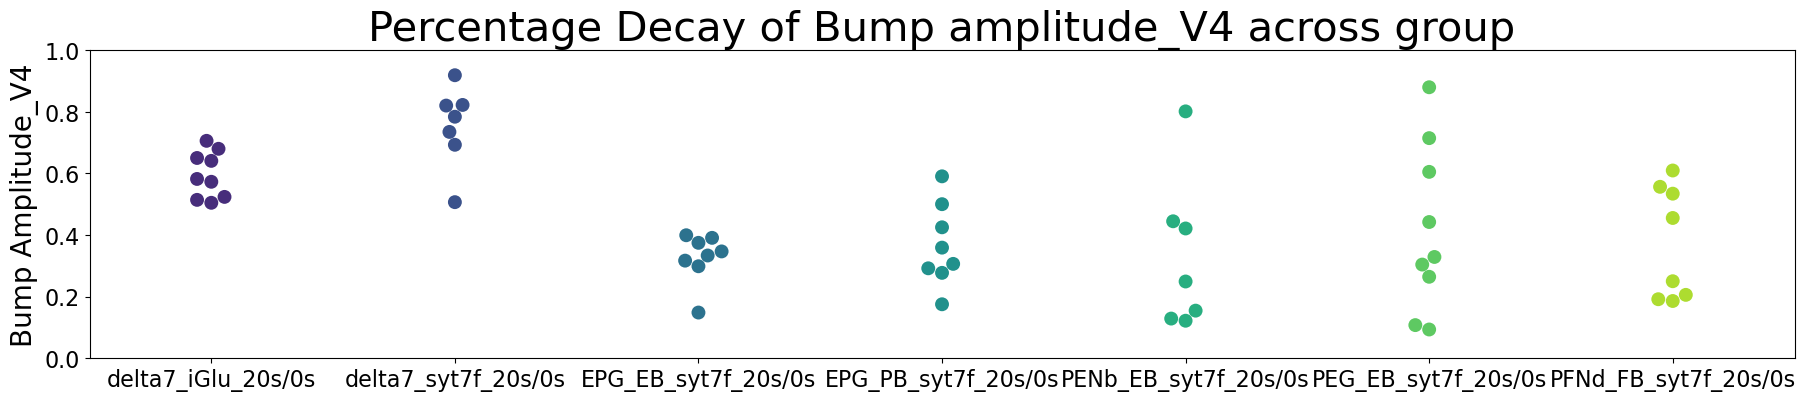

In [22]:
columns_to_plot_v4_percentage_20s_by_fly = ['delta7_iGlu_20s/0s', 'delta7_syt7f_20s/0s','EPG_EB_syt7f_20s/0s','EPG_PB_syt7f_20s/0s', 'PENb_EB_syt7f_20s/0s', 'PEG_EB_syt7f_20s/0s','PFNd_FB_syt7f_20s/0s']

# Create a swarm plot
plt.figure(figsize=(22, 4))
sns.swarmplot(data=pooled_bump_amplitude_V4_allGenotypes_byfly_df[columns_to_plot_v4_percentage_20s_by_fly ], palette='viridis', size=10)

plt.title('Percentage Decay of Bump amplitude_V4 across group', fontsize = 30)
plt.ylabel('Bump Amplitude_V4',fontsize =20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1)
plt.show()

In [23]:
run_ANOVA_for_comparing_across_genotypes(pooled_bump_amplitude_V4_allGenotypes_byfly_df,columns_to_plot_v4_percentage_20s_by_fly)

One-way ANOVA Result:
F-statistic: 6.4179827051628795
p-value: 4.882139037796809e-05
Adjusted df between: 6
Adjusted df within: 49
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
 EPG_EB_syt7f_20s/0s  EPG_PB_syt7f_20s/0s   0.0396 0.9993 -0.2293 0.3084  False
 EPG_EB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0894 0.9387 -0.1718 0.3507  False
 EPG_EB_syt7f_20s/0s PENb_EB_syt7f_20s/0s   0.0055    1.0 -0.2728 0.2838  False
 EPG_EB_syt7f_20s/0s PFNd_FB_syt7f_20s/0s   0.0475  0.998 -0.2214 0.3163  False
 EPG_EB_syt7f_20s/0s   delta7_iGlu_20s/0s    0.271 0.0374  0.0098 0.5323   True
 EPG_EB_syt7f_20s/0s  delta7_syt7f_20s/0s   0.4282 0.0004  0.1499 0.7065   True
 EPG_PB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0498 0.9969 -0.2114 0.3111  False
 EPG_PB_syt7f_20s/0s PENb_EB_syt7f_20s/0s  -0.0341 0.9998 -0.3123 0.2

In [47]:
pooled_PVA_strength_delta7_shi_df= pd.read_csv('/home/tianhaoqiu/Desktop/mean_PVA_strength_per_trial.csv')

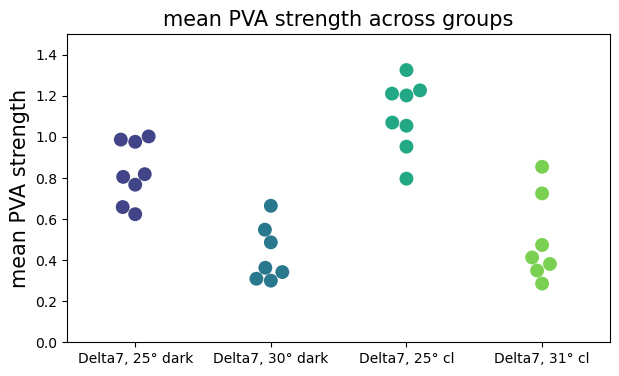

In [48]:
columns_to_plot_PVA_strength = ['Delta7, 25° dark', 'Delta7, 30° dark','Delta7, 25° cl','Delta7, 31° cl']


# Create a swarm plot
plt.figure(figsize=(7, 4))
sns.swarmplot(data=pooled_PVA_strength_delta7_shi_df[columns_to_plot_PVA_strength], palette='viridis', size=10)

plt.title('mean PVA strength across groups', fontsize = 15)
plt.ylabel('mean PVA strength',fontsize =15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0,1.5)
plt.show()

In [49]:
run_ANOVA_for_comparing_across_genotypes(pooled_PVA_strength_delta7_shi_df,columns_to_plot_PVA_strength)

One-way ANOVA Result:
F-statistic: 25.82005175722778
p-value: 5.8414032476720313e-08
Adjusted df between: 3
Adjusted df within: 26
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
  Delta7, 25° cl Delta7, 25° dark  -0.2749 0.0156 -0.5067 -0.0432   True
  Delta7, 25° cl Delta7, 30° dark  -0.6744    0.0 -0.9142 -0.4345   True
  Delta7, 25° cl   Delta7, 31° cl  -0.6074    0.0 -0.8472 -0.3675   True
Delta7, 25° dark Delta7, 30° dark  -0.3994 0.0006 -0.6393 -0.1596   True
Delta7, 25° dark   Delta7, 31° cl  -0.3324 0.0041 -0.5723 -0.0926   True
Delta7, 30° dark   Delta7, 31° cl    0.067 0.8792 -0.1807  0.3147  False
------------------------------------------------------------------------


In [50]:
pooled_PVA_strength_glucl_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/60d05-glucl/60D05_glucl_mean_PVA_strength_per_fly.csv')

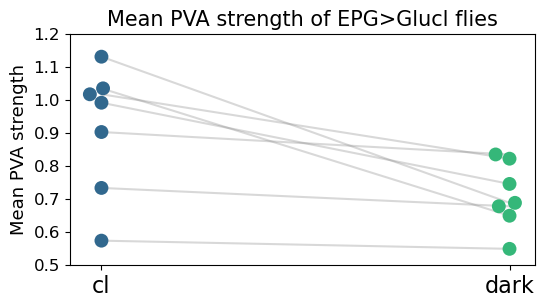

T-statistic: -3.237197374647247
P-value: 0.017749246362167615
Reject the null hypothesis; there is a significant difference between the groups.


In [59]:
from scipy.stats import ttest_rel

# Your list of columns
columns_to_plot_PVA_strength_glucl = ['cl', 'dark']

# Create a swarm plot
plt.figure(figsize=(6, 3))
ax = sns.swarmplot(data=pooled_PVA_strength_glucl_df[columns_to_plot_PVA_strength_glucl], palette='viridis', size=10)

# Connect corresponding dots with lines
for i in range(len(pooled_PVA_strength_glucl_df)):
    plt.plot([0, 1], pooled_PVA_strength_glucl_df.loc[i, columns_to_plot_PVA_strength_glucl].values, color='gray', alpha=0.3)

plt.title('Mean PVA strength of EPG>Glucl flies', fontsize=15)
plt.ylabel('Mean PVA strength', fontsize=13)
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0.5, 1.2)
plt.show()

# Perform paired sample t-test
t_statistic, p_value = ttest_rel(pooled_PVA_strength_glucl_df['dark'], pooled_PVA_strength_glucl_df['cl'])

# Display the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis; there is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the groups.")

In [ ]:

# Beautify the histogram
plt.figure(figsize=(10, 6))  # Set the figure size

combined_data = a  + b
bin_edges = 'auto'

# Histogram plot with customization
plt.hist(a, bins=bin_edges , color='tomato', edgecolor='black', alpha=0.6)  # Alpha controls transparency
plt.hist(b, bins=bin_edges , color='royalblue', edgecolor='black', alpha=0.6)  
plt.title('Distribution of Strong PVA Chunk (at least 2s)', fontsize = 20)  # Add title
plt.xlabel('Duration(s)', fontsize = 15)  # Label x-axis
plt.ylabel('Counts',fontsize = 15)  # Label y-axis
plt.xlim(2,25)
plt.ylim(0,150)

plt.legend([ 'empty>shi, 31°','E-PG>shi, 31°'],fontsize=12)
# Shw the plot
plt.show()